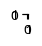

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
# pd.set_option("display.max_columns",999)
# pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance, get_roc
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

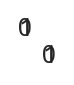

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221028_prime_related_newcore.csv')
ibel = pd.read_csv('../data/mutant/221111_ibel_neoepi_scored_merged.csv')
cp_merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [394]:
from src.partition_tools import pipeline_stratified_kfold

prime_fold = pipeline_stratified_kfold('../../kern_dist/out/221117_prime_related.pep_0.9.out', prime_related.reset_index(drop=True), 
                                       k=10, pep_col = 'Peptide', elrank_col='EL_rank_mut')
prime_fold.to_csv('../data/mutant/221119_prime_related_10fold.csv', index=False) 

read hobohm 2389 739
strat kfold unique 2389 739
manually reassign identical 2389 739
manually reassign related 2389 739
concat 3128
merge 3128
drop duplicated 3109


In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


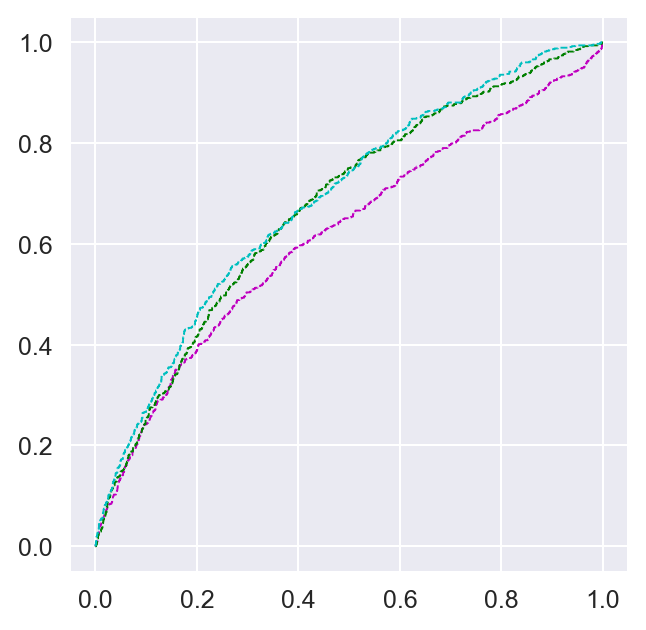

In [5]:
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [6]:
from src.baselines import plot_related_baseline_roc

Text(0.5, 1.0, 'Baseline ROCs on IBEL')

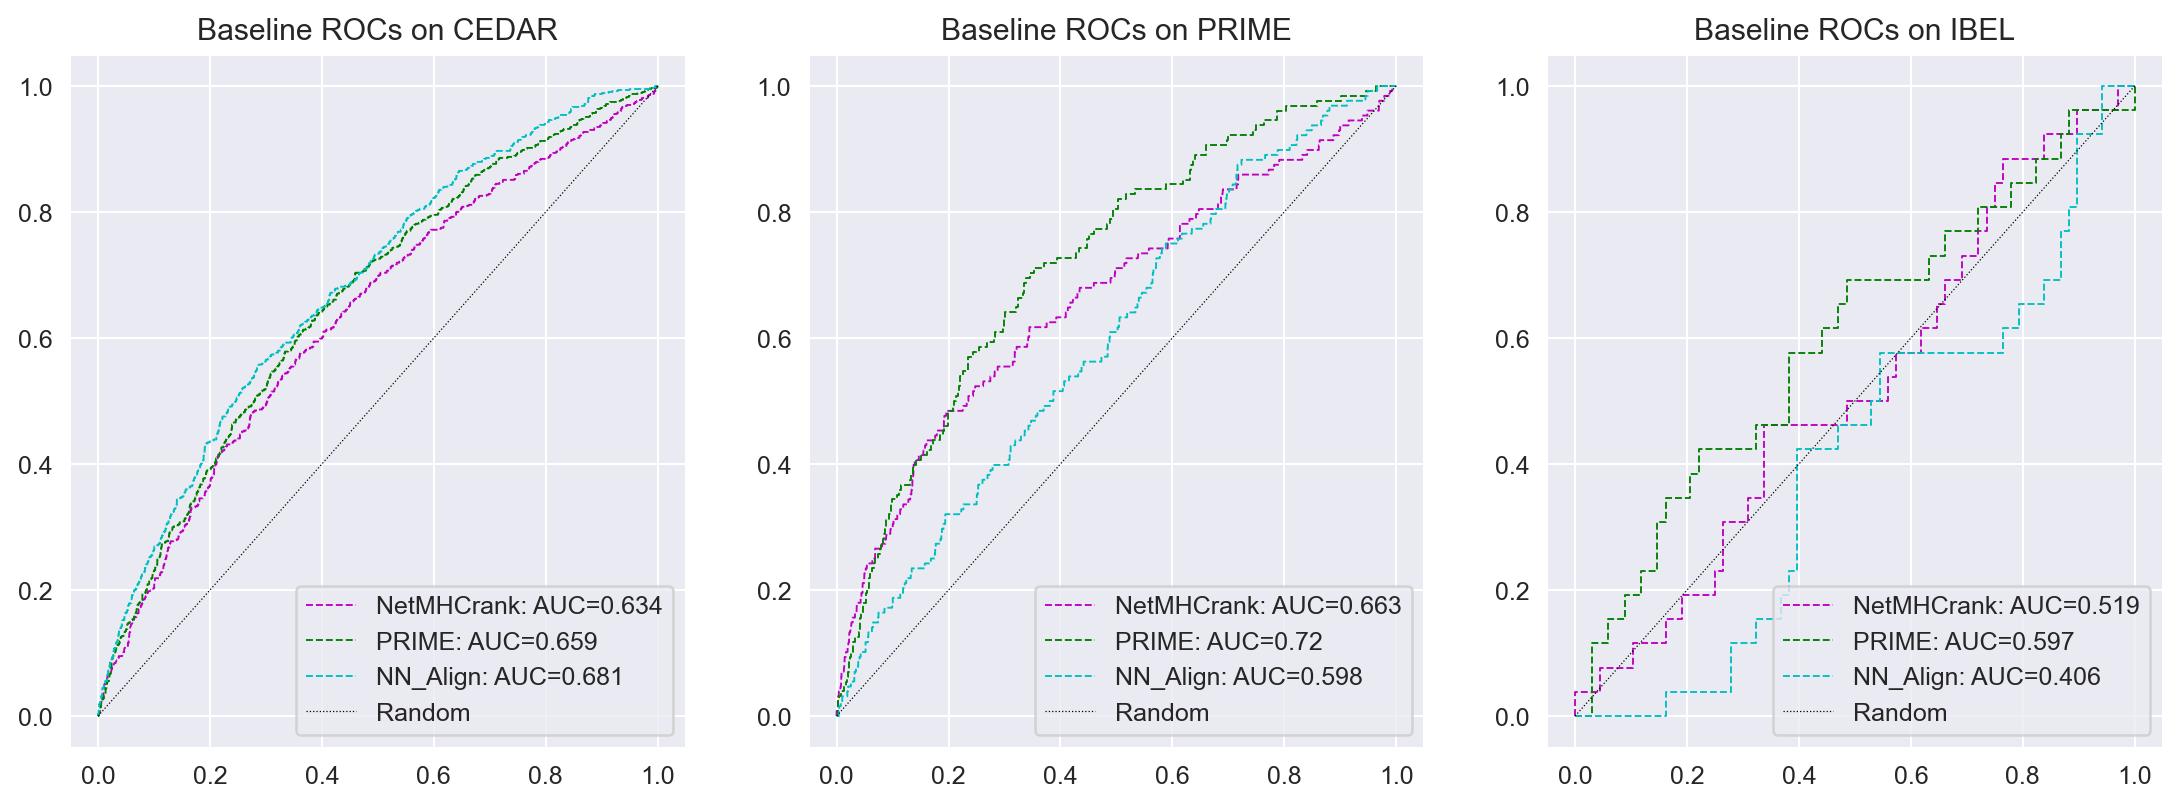

In [7]:
f,a = plt.subplots(1,3, figsize=(15,5))
plot_related_baseline_roc(axis=a[1], dataset=prime_related_baseline)
# a[1].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[1].legend(loc='lower right')
a[1].set_title('Baseline ROCs on PRIME')
plot_related_baseline_roc(axis=a[0], dataset=cedar_related_baseline)
# a[0].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[0].legend(loc='lower right')
a[0].set_title('Baseline ROCs on CEDAR')

plot_related_baseline_roc(axis=a[2], dataset=ibel)
# a[2].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[2].legend(loc='lower right')
a[2].set_title('Baseline ROCs on IBEL')

### Check various nnalign baselines

In [ ]:
cedar_nnalign = pd.read_csv('../../nnalign_cedar/output_baseline/221115_cedar_related.pep_27756/221115_cedar_related.pep_27756.lg6.sorted.pred', sep='\t').sort_values('Peptide')
prime_nnalign = pd.read_csv('../../nnalign_cedar/output_baseline/221115_prime_related.pep_35945/221115_prime_related.pep_35945.lg6.sorted.pred', sep='\t').sort_values('Peptide')
ibel_nnalign = pd.read_csv('../../nnalign_cedar/output_baseline/221115_ibel_related.pep_23423/221115_ibel_related.pep_23423.lg6.sorted.pred', sep='\t').sort_values('Peptide')
merged_nnalign = pd.read_csv('../../nnalign_cedar/output_baseline/221115_cedar_prime_merged.pep_11365/221115_cedar_prime_merged.pep_11365.lg6.sorted.pred', sep='\t').sort_values('Peptide')

In [91]:
cedar_nnalign_len8 = pd.read_csv('../../nnalign_cedar/output_baseline/221115_cedar_related_LEN8.pep/221115_cedar_related.pep_9059.lg8.sorted.pred', sep='\t').sort_values('Peptide')
prime_nnalign_len8 = pd.read_csv('../../nnalign_cedar/output_baseline/221115_prime_related_LEN8.pep_16861/221115_prime_related.pep_16861.lg8.sorted.pred', sep='\t').sort_values('Peptide')
ibel_nnalign_len8 = pd.read_csv('../../nnalign_cedar/output_baseline/221115_ibel_related_LEN8.pep_4773/221115_ibel_related.pep_4773.lg8.sorted.pred', sep='\t').sort_values('Peptide')
merged_nnalign_len8 = pd.read_csv('../../nnalign_cedar/output_baseline/221115_cedar_prime_merged_LEN8.pep_34147/221115_cedar_prime_merged.pep_34147.lg8.sorted.pred', sep='\t').sort_values('Peptide')

Text(0.5, 0.98, 'P1_Rel for different datasets; KDE and histograms')

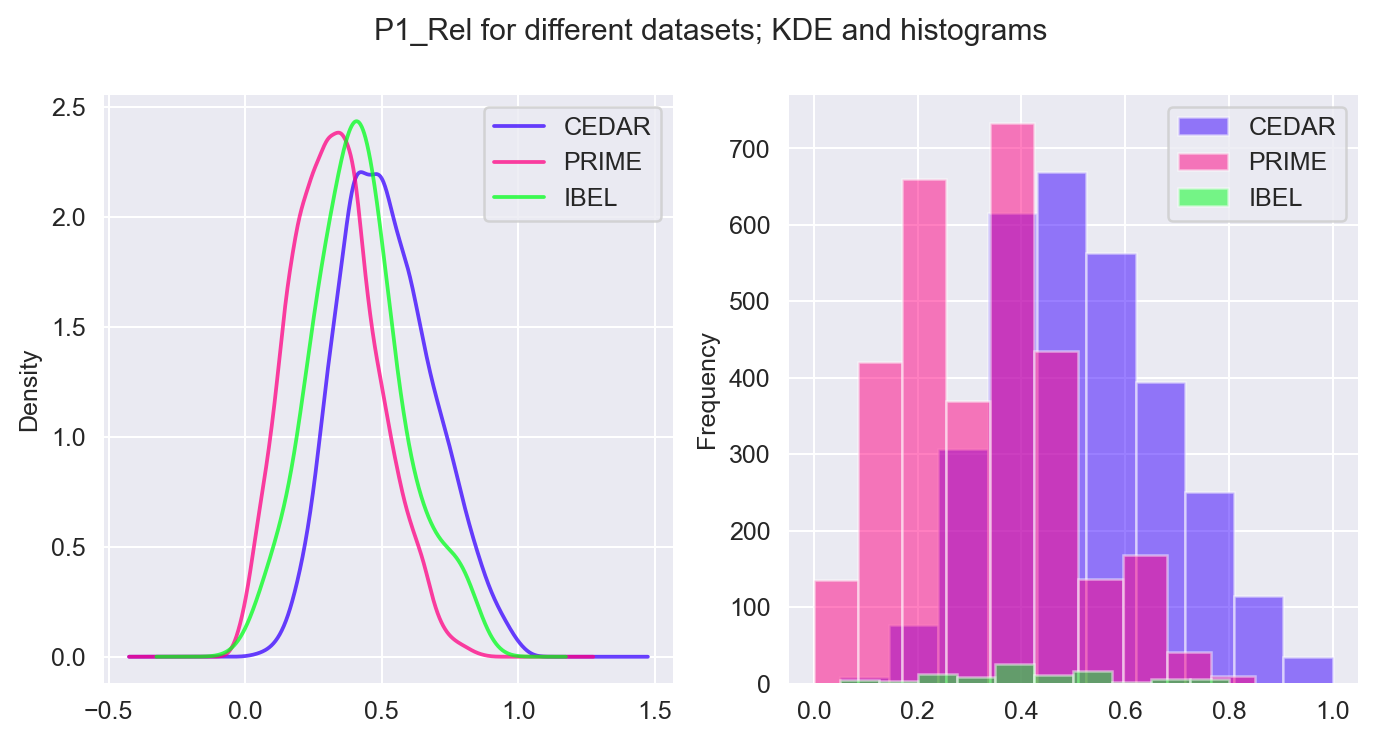

In [84]:
f,a = plt.subplots(1,2, figsize=(9, 4.25))
cedar_nnalign.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[0], label='CEDAR')
prime_nnalign.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[1], label='PRIME')
ibel_nnalign.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[-1], label='IBEL')

cedar_nnalign.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[0], label='CEDAR')
prime_nnalign.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[1], label='PRIME')
ibel_nnalign.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[-1], label='IBEL')
f.suptitle('P1_Rel for different datasets; KDE and histograms')

Text(0.5, 0.98, 'P1_Rel for different datasets; KDE and histograms')

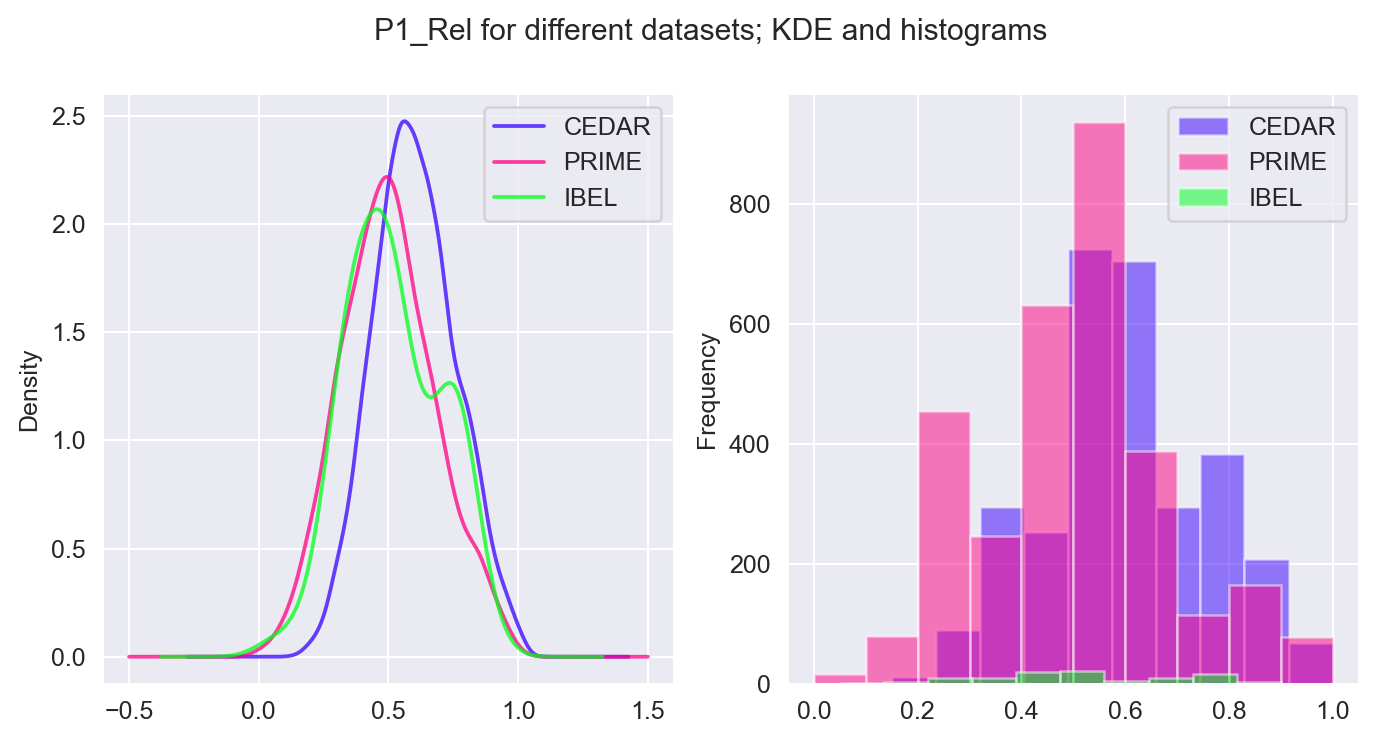

In [92]:
f,a = plt.subplots(1,2, figsize=(9, 4.25))
cedar_nnalign_len8.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[0], label='CEDAR')
prime_nnalign_len8.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[1], label='PRIME')
ibel_nnalign_len8.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[-1], label='IBEL')

cedar_nnalign_len8.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[0], label='CEDAR')
prime_nnalign_len8.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[1], label='PRIME')
ibel_nnalign_len8.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[-1], label='IBEL')
f.suptitle('P1_Rel for different datasets; KDE and histograms')

In [98]:
nnalign_results = {}
print('NNalign scores as baseline')
for name, df in zip(['CEDAR', 'PRIME', 'IBEL', 'MERGED'], [cedar_nnalign,prime_nnalign,ibel_nnalign,merged_nnalign]):
    df['target'] = df.Measure.astype(int)
    nnalign_results[name] = get_roc(df, score='Prediction', target='target')
    print(name, nnalign_results[name]['auc'], nnalign_results[name]['auc01'])

NNalign scores as baseline
CEDAR 0.6775372741415963 0.5539166522962452
PRIME 0.6144527318852734 0.5163612969861756
IBEL 0.40554298642533937 0.47368421052631576
MERGED 0.6702893279732787 0.548123061349165


In [99]:
nnalign_results_len8 = {}
print('NNalign scores as baseline')
for name, df in zip(['CEDAR', 'PRIME', 'IBEL', 'MERGED'], [cedar_nnalign_len8, prime_nnalign_len8, ibel_nnalign_len8, merged_nnalign_len8] ):
    df['target'] = df.Measure.astype(int)
    nnalign_results_len8[name] = get_roc(df, score='Prediction', target='target')
    print(name, nnalign_results[name]['auc'], nnalign_results[name]['auc01'])

NNalign scores as baseline
CEDAR 0.6775372741415963 0.5539166522962452
PRIME 0.6144527318852734 0.5163612969861756
IBEL 0.40554298642533937 0.47368421052631576
MERGED 0.6702893279732787 0.548123061349165


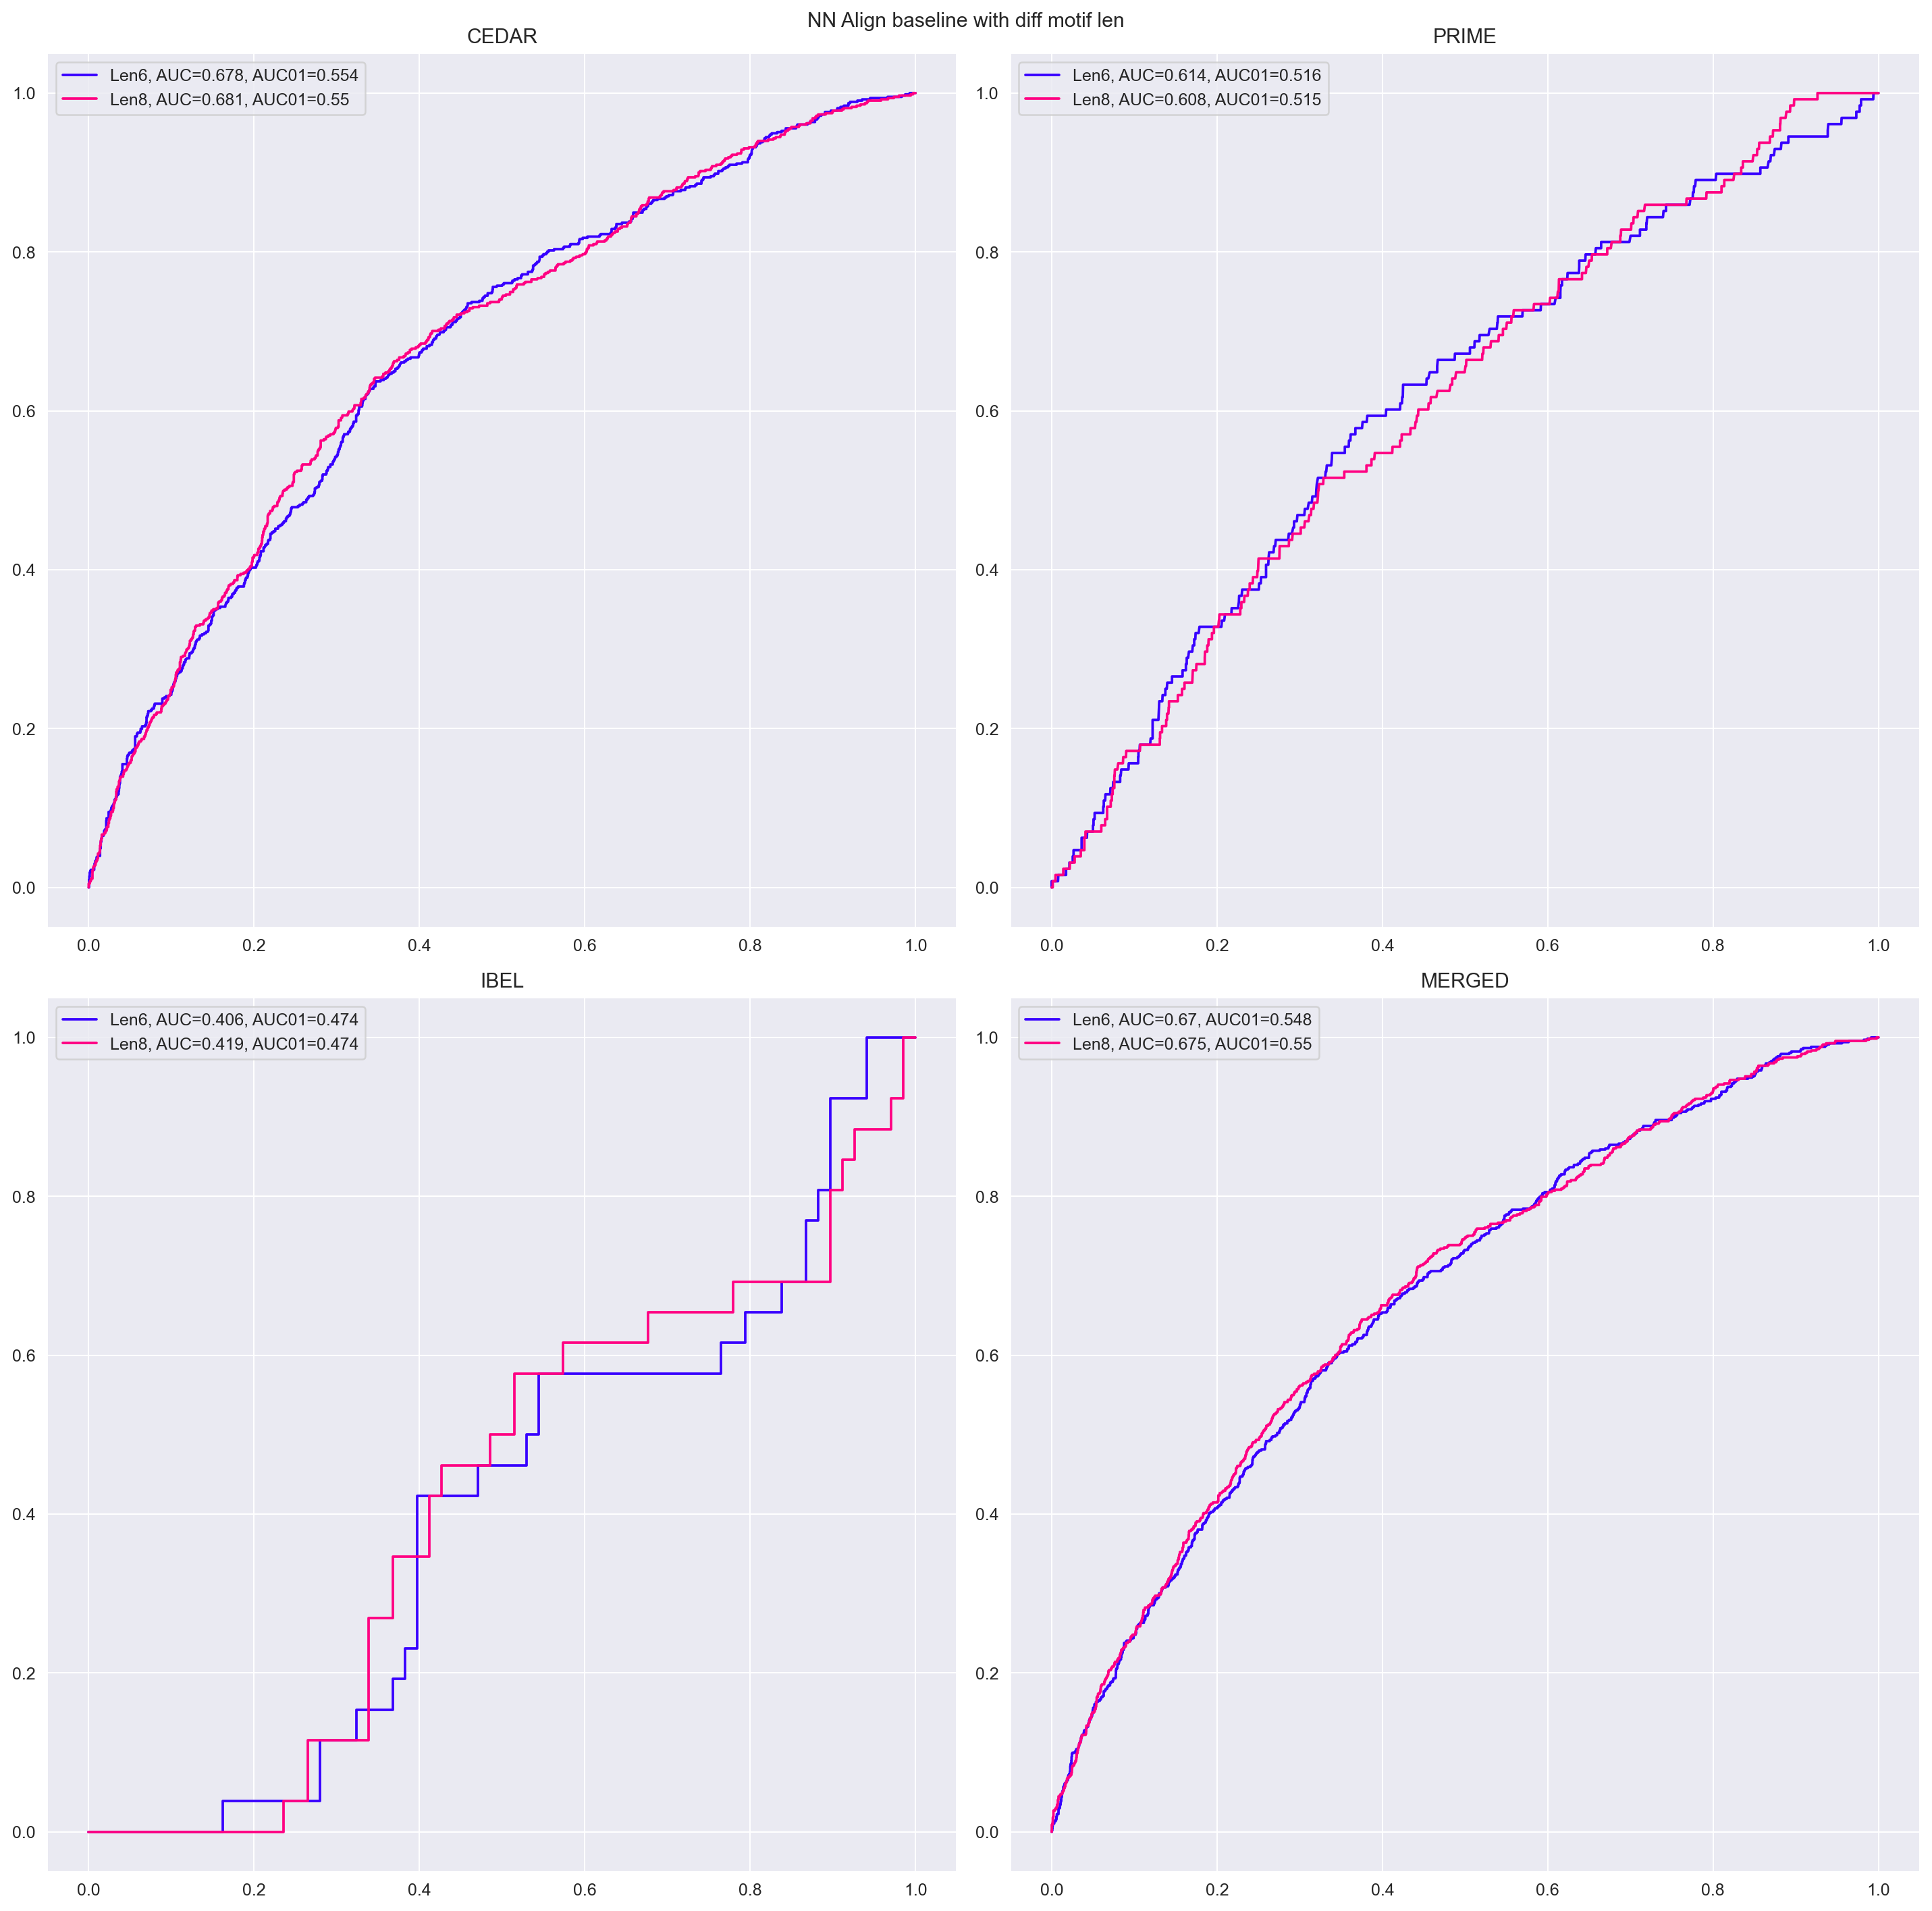

In [103]:
f,a = plt.subplots(2,2,figsize=(16,16))
ax = a.ravel()
for i, k in enumerate(nnalign_results.keys()):
    sns.lineplot(x=nnalign_results[k]['roc'][0], y=nnalign_results[k]['roc'][1], ax=ax[i], estimator=None,
                 label = f"Len6, AUC={round(nnalign_results[k]['auc'],3)}, AUC01={round(nnalign_results[k]['auc01'],3)}")
    sns.lineplot(x=nnalign_results_len8[k]['roc'][0], y=nnalign_results_len8[k]['roc'][1], ax=ax[i], estimator=None,
                 label = f"Len8, AUC={round(nnalign_results_len8[k]['auc'],3)}, AUC01={round(nnalign_results_len8[k]['auc01'],3)}")
    ax[i].set_title(k)
f.suptitle('NN Align baseline with diff motif len')
f.tight_layout()

# Results

In [9]:
df_results_merged = pd.read_csv('../output/221112_new_core_mutscores_mergedtrainset/bootstrapping/total_df.csv')
df_results = pd.read_csv('../output/221112_new_core_mutscores_mergedtrainset/total_df_without_merged_results.csv')
df_results = pd.concat([df_results, df_results_merged])
del df_results_merged
df_results.to_csv('../output/221112_new_core_mutscores_mergedtrainset/total_df_all.csv',index=False)

KeyboardInterrupt: 

In [10]:
df_results = pd.read_csv('../output/221112_new_core_mutscores_mergedtrainset/total_df_all.csv')

In [11]:
def weight_name(weight):
    if weight=='None':
        return weight
    elif 'Inverted' in weight:
        weight = weight.replace('Inverted ', '')
        return f'IC {weight}'
    else:
        return f'(1–IC) {weight}'
df_results['weight'] = df_results['weight'].apply(weight_name)
df_results.weight.unique()

array(['IC Mask', 'IC KL', 'IC Shannon', '(1–IC) Mask', '(1–IC) KL',
       'None', '(1–IC) Shannon'], dtype=object)

## reshape results

In [12]:
score_cols = ['auc', 'prauc', 'AP', 'auc_01', 'f1', 'accuracy', 'precision', 'recall']
feat_cols = ['encoding', 'weight','pep_col', 'rank_col', 'key']

df_prime = df_results.query('evalset=="PRIME"').drop(columns=['evalset']).reset_index(drop=True)
df_prime.rename(columns = {k:f'{k}_prime' for k in score_cols}, inplace=True)

df_cedar = df_results.query('evalset=="CEDAR"').drop(columns=['evalset']).reset_index(drop=True)
df_cedar.rename(columns = {k:f'{k}_cedar' for k in score_cols}, inplace=True)

df_ibel = df_results.query('evalset=="IBEL"').drop(columns=['evalset']).reset_index(drop=True)
df_ibel.rename(columns = {k:f'{k}_ibel' for k in score_cols}, inplace=True)

df_merged = df_results.query('evalset=="MERGED"').drop(columns=['evalset']).reset_index(drop=True)
df_merged.rename(columns = {k:f'{k}_merged' for k in score_cols}, inplace=True)

df_reshape = df_cedar.merge(df_prime.drop(columns = feat_cols), left_index=True, right_index=True)\
                     .merge(df_ibel.drop(columns = feat_cols), left_index=True, right_index=True)\
                     .merge(df_merged.drop(columns= feat_cols), left_index=True, right_index=True)

del df_prime
del df_cedar
del df_ibel
del df_merged

## gb_agg checks

In [14]:
# Only keep models that use EL rank mut as rank 
gb_agg = df_results.query('rank_col=="EL_rank_mut"').groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key', 'evalset']).agg(max_AUC=('auc', 'max'),
                                                                                                 mean_AUC=('auc', 'mean'),
                                                                                                 med_AUC=('auc', 'median'),
                                                                                                 std_AUC=('auc', 'std'), 
                                                                                                 max_PRAUC=('prauc', 'max'),
                                                                                                 mean_PRAUC=('prauc', 'mean'),
                                                                                                 med_PRAUC=('prauc', 'median'),
                                                                                                 std_PRAUC=('prauc', 'std')).reset_index('evalset')

gb_reshape = df_reshape.groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key']).agg(max_AUC_cedar=('auc_cedar', 'max'),
                                                                                          mean_AUC_cedar=('auc_cedar', 'mean'),
                                                                                          max_PRAUC_cedar=('prauc_cedar', 'max'),
                                                                                          mean_PRAUC_cedar=('prauc_cedar', 'mean'),
                                                                                          max_AUC_prime=('auc_prime', 'max'),
                                                                                          mean_AUC_prime=('auc_prime', 'mean'),
                                                                                          max_PRAUC_prime=('prauc_prime', 'max'),
                                                                                          mean_PRAUC_prime=('prauc_prime', 'mean'),
                                                                                          max_AUC_ibel=('auc_ibel', 'max'),
                                                                                          mean_AUC_ibel=('auc_ibel', 'mean'),
                                                                                          max_PRAUC_ibel=('prauc_ibel', 'max'),
                                                                                          mean_PRAUC_ibel=('prauc_ibel', 'mean'),
                                                                                          max_AUC_merged=('auc_merged', 'max'),
                                                                                          mean_AUC_merged=('auc_merged', 'mean'),
                                                                                          max_PRAUC_merged=('prauc_merged', 'max'),
                                                                                          mean_PRAUC_merged=('prauc_merged', 'mean'))

## top means etc

In [15]:
top25_mean_cedar = gb_reshape.sort_values('mean_AUC_cedar', ascending=False).head(25)
top25_mean_prime = gb_reshape.sort_values('mean_AUC_prime', ascending=False).head(25)
top25_mean_ibel = gb_reshape.sort_values('mean_AUC_ibel', ascending=False).head(25)
top25_mean_merged = gb_reshape.sort_values('mean_AUC_merged', ascending=False).head(25)


In [21]:
auc_cols = list(filter(lambda x: 'PR' not in x and 'AUC' in x and 'mean' in x, top25_mean_cedar.columns))
auc_cols

['mean_AUC_cedar', 'mean_AUC_prime', 'mean_AUC_ibel', 'mean_AUC_merged']

In [22]:
# MERGED
from IPython.core.display import display, HTML
output = top25_mean_merged[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))

In [132]:
tmp = top25_mean_merged.reset_index('weight').groupby('weight').agg(x=('max_AUC_merged','count'))

In [133]:
tmp

x
weight           
(1–IC) KL       8
(1–IC) Shannon  8
IC Mask         7
None            2

In [143]:
tmp_feats = top25_mean_merged.reset_index('key').groupby('key').agg(x=('max_AUC_merged','count'))
tmp_weight = top25_mean_merged.reset_index('weight').groupby('weight').agg(x=('max_AUC_merged','count'))
feat_merged_appearances={}
idx=list(tmp_feat.index)
vals=tmp_feats.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in feat_merged_appearances.keys():
            feat_merged_appearances[n]+=v
        else:
            feat_merged_appearances[n]=v
print('feats', feat_merged_appearances)

weight_merged_appearances={}
idx=list(tmp_weight.index)
vals=tmp_weight.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in weight_merged_appearances.keys():
            weight_merged_appearances[n]+=v
        else:
            weight_merged_appearances[n]=v
print('weight', weight_merged_appearances)

feats {'blsm_mut_score': 13, 'mutation_score': 25, 'ratio_rank': 11, 'dissimilarity_score': 12}
weight {'(1–IC) KL': 8, '(1–IC) Shannon': 8, 'IC Mask': 7, 'None': 2}


In [24]:
from IPython.core.display import display, HTML
output = top25_mean_cedar[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))

In [142]:
tmp_feats = top25_mean_cedar.reset_index('key').groupby('key').agg(x=('max_AUC_cedar','count'))
tmp_weight = top25_mean_cedar.reset_index('weight').groupby('weight').agg(x=('max_AUC_cedar','count'))
feat_cedar_appearances={}
idx=list(tmp_feat.index)
vals=tmp_feats.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in feat_cedar_appearances.keys():
            feat_cedar_appearances[n]+=v
        else:
            feat_cedar_appearances[n]=v
print('feats', feat_cedar_appearances)

weight_cedar_appearances={}
idx=list(tmp_weight.index)
vals=tmp_weight.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in weight_cedar_appearances.keys():
            weight_cedar_appearances[n]+=v
        else:
            weight_cedar_appearances[n]=v
print('weight', weight_cedar_appearances)

feats {'blsm_mut_score': 15, 'mutation_score': 22, 'ratio_rank': 7, 'dissimilarity_score': 7}
weight {'IC KL': 11, 'IC Shannon': 14}


### PRIME

In [26]:
from IPython.core.display import display, HTML
output = top25_mean_prime[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))

In [141]:
tmp_feats = top25_mean_prime.reset_index('key').groupby('key').agg(x=('max_AUC_prime','count'))
tmp_weight = top25_mean_prime.reset_index('weight').groupby('weight').agg(x=('max_AUC_prime','count'))
feat_prime_appearances={}
idx=list(tmp_feat.index)
vals=tmp_feats.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in feat_prime_appearances.keys():
            feat_prime_appearances[n]+=v
        else:
            feat_prime_appearances[n]=v
print('feats', feat_prime_appearances)

weight_prime_appearances={}
idx=list(tmp_weight.index)
vals=tmp_weight.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in weight_prime_appearances.keys():
            weight_prime_appearances[n]+=v
        else:
            weight_prime_appearances[n]=v
print('weight', weight_prime_appearances)

feats {'blsm_mut_score': 9, 'mutation_score': 19, 'ratio_rank': 12, 'dissimilarity_score': 9}
weight {'(1–IC) KL': 1, '(1–IC) Mask': 23, '(1–IC) Shannon': 1}


### IBEL

In [28]:
from IPython.core.display import display, HTML
output = top25_mean_ibel[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))

In [140]:
tmp_feats = top25_mean_ibel.reset_index('key').groupby('key').agg(x=('max_AUC_ibel','count'))
tmp_weight = top25_mean_ibel.reset_index('weight').groupby('weight').agg(x=('max_AUC_ibel','count'))
feat_ibel_appearances={}
idx=list(tmp_feat.index)
vals=tmp_feats.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in feat_ibel_appearances.keys():
            feat_ibel_appearances[n]+=v
        else:
            feat_ibel_appearances[n]=v
print('feats', feat_ibel_appearances)

weight_ibel_appearances={}
idx=list(tmp_weight.index)
vals=tmp_weight.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in weight_ibel_appearances.keys():
            weight_ibel_appearances[n]+=v
        else:
            weight_ibel_appearances[n]=v
print('weight', weight_ibel_appearances)

feats {'blsm_mut_score': 17, 'mutation_score': 25, 'ratio_rank': 11, 'dissimilarity_score': 16}
weight {'(1–IC) KL': 8, '(1–IC) Shannon': 11, 'IC KL': 2, 'IC Mask': 2, 'None': 2}


In [145]:
print('cedarfeat', feat_cedar_appearances)
print('primefeat', feat_prime_appearances)
print('ibel_feat', feat_ibel_appearances)
print('merged feat', feat_merged_appearances)
print('\n')
print('cedar weight', weight_cedar_appearances)
print('prime weight', weight_prime_appearances)
print('ibel_ weight', weight_ibel_appearances)
print('merged weight', weight_merged_appearances)


cedarfeat {'blsm_mut_score': 15, 'mutation_score': 22, 'ratio_rank': 7, 'dissimilarity_score': 7}
primefeat {'blsm_mut_score': 9, 'mutation_score': 19, 'ratio_rank': 12, 'dissimilarity_score': 9}
ibel_feat {'blsm_mut_score': 17, 'mutation_score': 25, 'ratio_rank': 11, 'dissimilarity_score': 16}
merged feat {'blsm_mut_score': 13, 'mutation_score': 25, 'ratio_rank': 11, 'dissimilarity_score': 12}


cedar weight {'IC KL': 11, 'IC Shannon': 14}
prime weight {'(1–IC) KL': 1, '(1–IC) Mask': 23, '(1–IC) Shannon': 1}
ibel_ weight {'(1–IC) KL': 8, '(1–IC) Shannon': 11, 'IC KL': 2, 'IC Mask': 2, 'None': 2}
merged weight {'(1–IC) KL': 8, '(1–IC) Shannon': 8, 'IC Mask': 7, 'None': 2}


## quick pvalue stuff

In [293]:
gb_agg.sort_values('mean_AUC', ascending=False).head(20).reset_index()\
                                        .query('evalset=="CEDAR"')[['encoding', 'weight', 'pep_col', 'rank_col' ,'key']].values

array([['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut', 'aa_props'],
       ['onehot', 'Inverted Shannon', 'icore_mut', 'EL_rank_mut',
        'aa_props'],
       ['onehot', 'Inverted Shannon', 'Peptide', 'EL_rank_mut',
        'aa_props'],
       ['onehot', 'Inverted KL', 'icore_mut', 'EL_rank_mut', 'aa_props'],
       ['onehot', 'Inverted KL', 'Peptide', 'trueHLA_EL_rank',
        'aa_props'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'mutation_score-ratio_rank'],
       ['BL62FREQ', 'Inverted Shannon', 'icore_mut', 'EL_rank_mut',
        'aa_props'],
       ['onehot', 'Inverted Shannon', 'Peptide', 'trueHLA_EL_rank',
        'aa_props'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'blsm_mut_score-mutation_score'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'core_blsm_mut_score-ratio_rank'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'blsm_mut_score-ratio_rank'],
       ['onehot', 'Inve

In [180]:
auc_a = df_a.auc.values
auc_b = df_results.query('encoding=="BL62FREQ" and evalset=="CEDAR" and rank_col=="EL_rank_mut" and key=="aa_props" and pep_col=="icore_mut" and weight=="Shannon"').auc.values
a_over_b = [x>y for x,y in zip(auc_a, auc_b)]
pval = 1 - (len((auc_a>auc_b).astype(int).nonzero()[0]) / 10000 )
pval

0.0010999999999999899

In [248]:
df_results.columns

Index(['auc', 'prauc', 'AP', 'auc_01', 'f1', 'accuracy', 'precision', 'recall',
       'encoding', 'weight', 'pep_col', 'rank_col', 'key', 'evalset'],
      dtype='object')

# plots

## ROCs

In [31]:
print('top25_mean_cedar')
display(top25_mean_cedar.head(1)[auc_cols])
print('top25_mean_prime')
display(top25_mean_prime.head(1)[auc_cols])
print('top25_mean_ibel')
display(top25_mean_ibel.head(1)[auc_cols])
print('top25_mean_merged')
display(top25_mean_merged.head(1)[auc_cols])

gb_reshape['mean_CEDAR_PRIME_AUC'] = gb_reshape.apply(lambda x: np.mean([x['mean_AUC_cedar'], x['mean_AUC_prime'], x['mean_AUC_ibel']]), axis=1)
gb_reshape['mean_CEDAR_PRIME_AUC_weighted'] = 0.75*gb_reshape['mean_AUC_cedar']+0.25*gb_reshape['mean_AUC_prime']+0.25*gb_reshape['mean_AUC_ibel']
print('mean')
display(gb_reshape.sort_values('mean_CEDAR_PRIME_AUC',ascending=False).head(1)[auc_cols])
print('weighted')
display(gb_reshape.sort_values('mean_CEDAR_PRIME_AUC_weighted',ascending=False).head(1)[auc_cols])

top25_mean_cedar


mean_AUC_cedar  mean_AUC_prime  \
encoding weight pep_col rank_col    key                                        
onehot   IC KL  Peptide EL_rank_mut aa_props        0.728261        0.687683   

                                              mean_AUC_ibel  mean_AUC_merged  
encoding weight pep_col rank_col    key                                       
onehot   IC KL  Peptide EL_rank_mut aa_props       0.573483         0.723463

top25_mean_prime


mean_AUC_cedar  \
encoding weight      pep_col rank_col    key                                                       
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_mutation_score        0.700505   

                                                                                  mean_AUC_prime  \
encoding weight      pep_col rank_col    key                                                       
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_mutation_score        0.727533   

                                                                                  mean_AUC_ibel  \
encoding weight      pep_col rank_col    key                                                      
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_mutation_score       0.549523   

                                                                                  mean_AUC_merged  
encoding weight      pep_col rank_col    key                                                       
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_mutation_score         0.712286

top25_mean_ibel


mean_AUC_cedar  \
encoding weight         pep_col rank_col        key                                                                 
onehot   (1–IC) Shannon Peptide trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score        0.696682   

                                                                                                   mean_AUC_prime  \
encoding weight         pep_col rank_col        key                                                                 
onehot   (1–IC) Shannon Peptide trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score        0.660428   

                                                                                                   mean_AUC_ibel  \
encoding weight         pep_col rank_col        key                                                                
onehot   (1–IC) Shannon Peptide trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score       0.678363   

                                                                                                   mean_AUC_merged  
encoding weight         pep_col rank_col        key                                                                 
onehot   (1–IC) Shannon Peptide trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score         0.813261

top25_mean_merged


mean_AUC_cedar  \
encoding weight         pep_col   rank_col    key                                                                 
onehot   (1–IC) Shannon icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score-mutation_score        0.714302   

                                                                                                 mean_AUC_prime  \
encoding weight         pep_col   rank_col    key                                                                 
onehot   (1–IC) Shannon icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score-mutation_score        0.670563   

                                                                                                 mean_AUC_ibel  \
encoding weight         pep_col   rank_col    key                                                                
onehot   (1–IC) Shannon icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score-mutation_score       0.643095   

                                                                                                 mean_AUC_merged  
encoding weight         pep_col   rank_col    key                                                                 
onehot   (1–IC) Shannon icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score-mutation_score         0.826389

mean


mean_AUC_cedar  \
encoding weight         pep_col rank_col    key                                             
onehot   (1–IC) Shannon Peptide EL_rank_mut blsm_mut_score-mutation_score        0.707047   

                                                                           mean_AUC_prime  \
encoding weight         pep_col rank_col    key                                             
onehot   (1–IC) Shannon Peptide EL_rank_mut blsm_mut_score-mutation_score        0.684864   

                                                                           mean_AUC_ibel  \
encoding weight         pep_col rank_col    key                                            
onehot   (1–IC) Shannon Peptide EL_rank_mut blsm_mut_score-mutation_score       0.662822   

                                                                           mean_AUC_merged  
encoding weight         pep_col rank_col    key                                             
onehot   (1–IC) Shannon Peptide EL_rank_mut blsm_mut_score-mutation_score         0.819113

weighted


mean_AUC_cedar  \
encoding weight         pep_col   rank_col    key                                             
onehot   (1–IC) Shannon icore_mut EL_rank_mut blsm_mut_score-mutation_score        0.713107   

                                                                             mean_AUC_prime  \
encoding weight         pep_col   rank_col    key                                             
onehot   (1–IC) Shannon icore_mut EL_rank_mut blsm_mut_score-mutation_score        0.680473   

                                                                             mean_AUC_ibel  \
encoding weight         pep_col   rank_col    key                                            
onehot   (1–IC) Shannon icore_mut EL_rank_mut blsm_mut_score-mutation_score       0.652141   

                                                                             mean_AUC_merged  
encoding weight         pep_col   rank_col    key                                             
onehot   (1–IC) Shannon icore_mut EL_rank_mut blsm_mut_score-mutation_score          0.82628

### get and load best cdts

In [33]:
best_cedar_cdt = 'onehot_Inverted-KL_Peptide_EL_rank_mut_aa_props'
best_prime_cdt = 'onehot_Mask_Peptide_EL_rank_mut_dissimilarity_score-core_mutation_score'
best_ibel_cdt = 'onehot_Shannon_Peptide_EL_rank_mut_dissimilarity_score-blsm_mut_score-mutation_score'
best_merged_cdt = 'onehot_Shannon_icore_mut_EL_rank_mut_dissimilarity_score-blsm_mut_score-mutation_score'
best_mean_cdt = 'onehot_Shannon_Peptide_EL_rank_mut_blsm_mut_score-mutation_score'
best_weighted_cdt = 'onehot_Shannon_icore_mut_EL_rank_mut_blsm_mut_score-mutation_score'

In [34]:
dir_ = '../output/221112_new_core_mutscores_mergedtrainset/bootstrapping/'
# Best cedar cdt
best_cedar_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_cedar_cdt}.pkl')
best_cedar_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_cedar_cdt}.pkl')
best_cedar_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_cedar_cdt}.pkl')
best_cedar_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_cedar_cdt}.pkl')

# best prime cdt
best_prime_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_prime_cdt}.pkl')
best_prime_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_prime_cdt}.pkl')
best_prime_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_prime_cdt}.pkl')
best_prime_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_prime_cdt}.pkl')

# Best IBEL cdt
best_ibel_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_ibel_cdt}.pkl')
best_ibel_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_ibel_cdt}.pkl')
best_ibel_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_ibel_cdt}.pkl')
best_ibel_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_ibel_cdt}.pkl')

# Best MERGED cdt
best_merged_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_merged_cdt}.pkl')
best_merged_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_merged_cdt}.pkl')
best_merged_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_merged_cdt}.pkl')
best_merged_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_merged_cdt}.pkl')

# best mean cdt
best_mean_cdt_cedar_roc =  pkl_load(f'{dir_}cedar_mean_rocs_{best_mean_cdt}.pkl')
best_mean_cdt_prime_roc =  pkl_load(f'{dir_}prime_mean_rocs_{best_mean_cdt}.pkl')
best_mean_cdt_ibel_roc =  pkl_load(f'{dir_}ibel_mean_rocs_{best_mean_cdt}.pkl')
best_mean_cdt_ibel_roc =  pkl_load(f'{dir_}ibel_mean_rocs_{best_mean_cdt}.pkl')
# best weighted mean cdt
best_weighted_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_weighted_cdt}.pkl')
best_weighted_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_weighted_cdt}.pkl')
best_weighted_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_weighted_cdt}.pkl')
best_weighted_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_weighted_cdt}.pkl')

In [53]:
dir_raw = '../output/221112_new_core_mutscores_mergedtrainset/raw/'

# Best cedar cdt
best_cedar_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_cedar_cdt}.csv') 
best_cedar_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_cedar_cdt}.csv') 
best_cedar_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_cedar_cdt}.csv') 
best_cedar_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_cedar_cdt}.csv') 

# best prime cdt
best_prime_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_prime_cdt}.csv') 
best_prime_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_prime_cdt}.csv') 
best_prime_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_prime_cdt}.csv') 
best_prime_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_prime_cdt}.csv') 

# Best IBEL cdt
best_ibel_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_ibel_cdt}.csv') 
best_ibel_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_ibel_cdt}.csv') 
best_ibel_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_ibel_cdt}.csv') 
best_ibel_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_ibel_cdt}.csv') 

# Best MERGED cdt
best_merged_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_merged_cdt}.csv') 
best_merged_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_merged_cdt}.csv') 
best_merged_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_merged_cdt}.csv') 
best_merged_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_merged_cdt}.csv') 

# best mean cdt
best_mean_cdt_cedar_preds =  pd.read_csv(f'{dir_raw}cedar_preds_{best_mean_cdt}.csv') 
best_mean_cdt_prime_preds =  pd.read_csv(f'{dir_raw}prime_preds_{best_mean_cdt}.csv') 
best_mean_cdt_ibel_preds =  pd.read_csv(f'{dir_raw}ibel_preds_{best_mean_cdt}.csv') 
best_mean_cdt_merged_preds =  pd.read_csv(f'{dir_raw}merged_preds_{best_mean_cdt}.csv') 
# best weighted mean cdt
best_weighted_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_weighted_cdt}.csv') 
best_weighted_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_weighted_cdt}.csv') 
best_weighted_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_weighted_cdt}.csv') 
best_weighted_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_weighted_cdt}.csv') 

### plotting

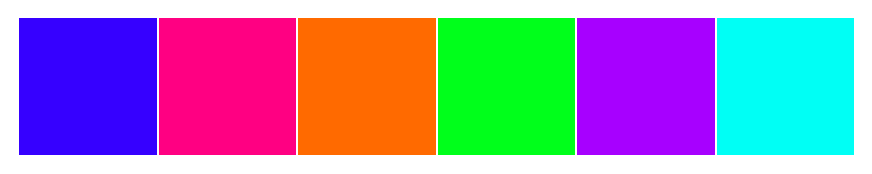

In [50]:
palette = HSV + [sns.color_palette('hsv', n_colors=13)[-3], sns.color_palette('hsv', n_colors=13)[6]]
sns.palplot(palette)

In [64]:
cpmerge_a = cp_merged.merge(cedar_related_baseline[['Peptide', 'HLA', 'EL_rank_mut', 'PRIME_score', 'nnalign_score']], left_on=['Peptide', 'HLA', 'EL_rank_mut'], right_on=['Peptide', 'HLA', 'EL_rank_mut'])
cpmerge_b = cp_merged.merge(prime_related_baseline[['Peptide', 'HLA', 'EL_rank_mut', 'PRIME_score', 'nnalign_score']], left_on=['Peptide', 'HLA', 'EL_rank_mut'], right_on=['Peptide', 'HLA', 'EL_rank_mut'])

In [69]:
cp_merged = pd.concat([cpmerge_a, cpmerge_b.query('Peptide not in @cpmerge_a.Peptide.unique()')])

### groupedby

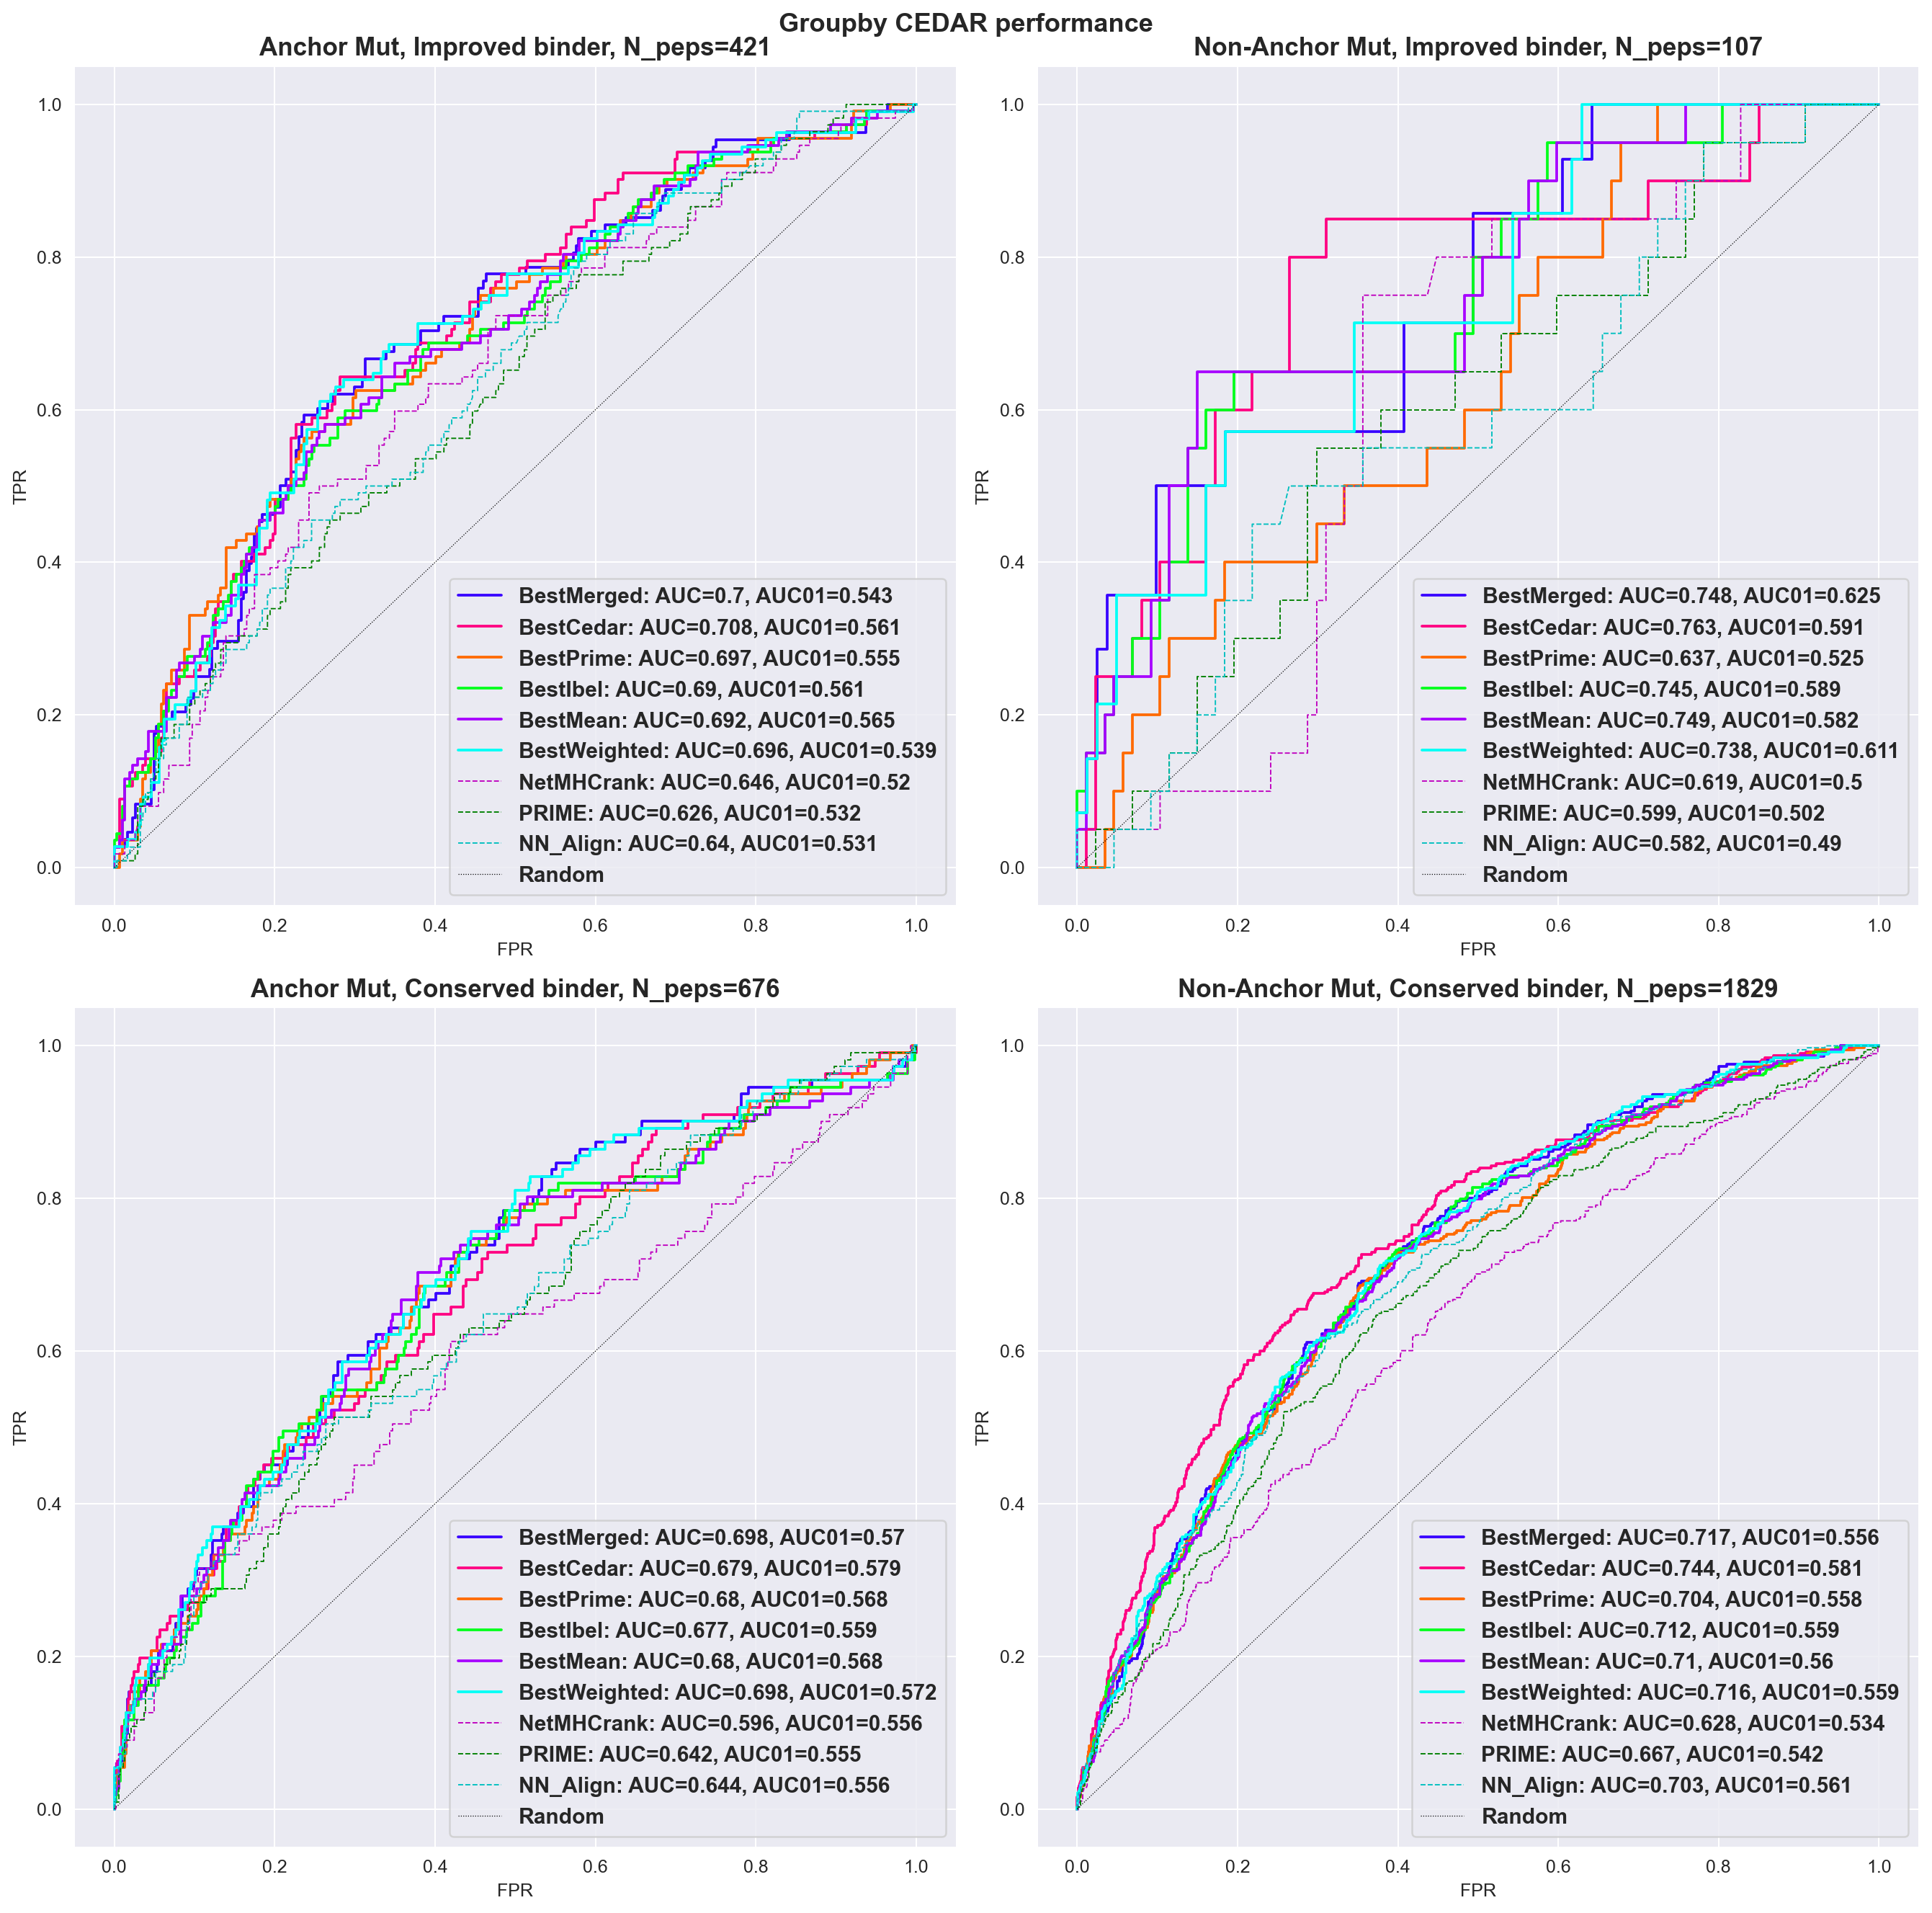

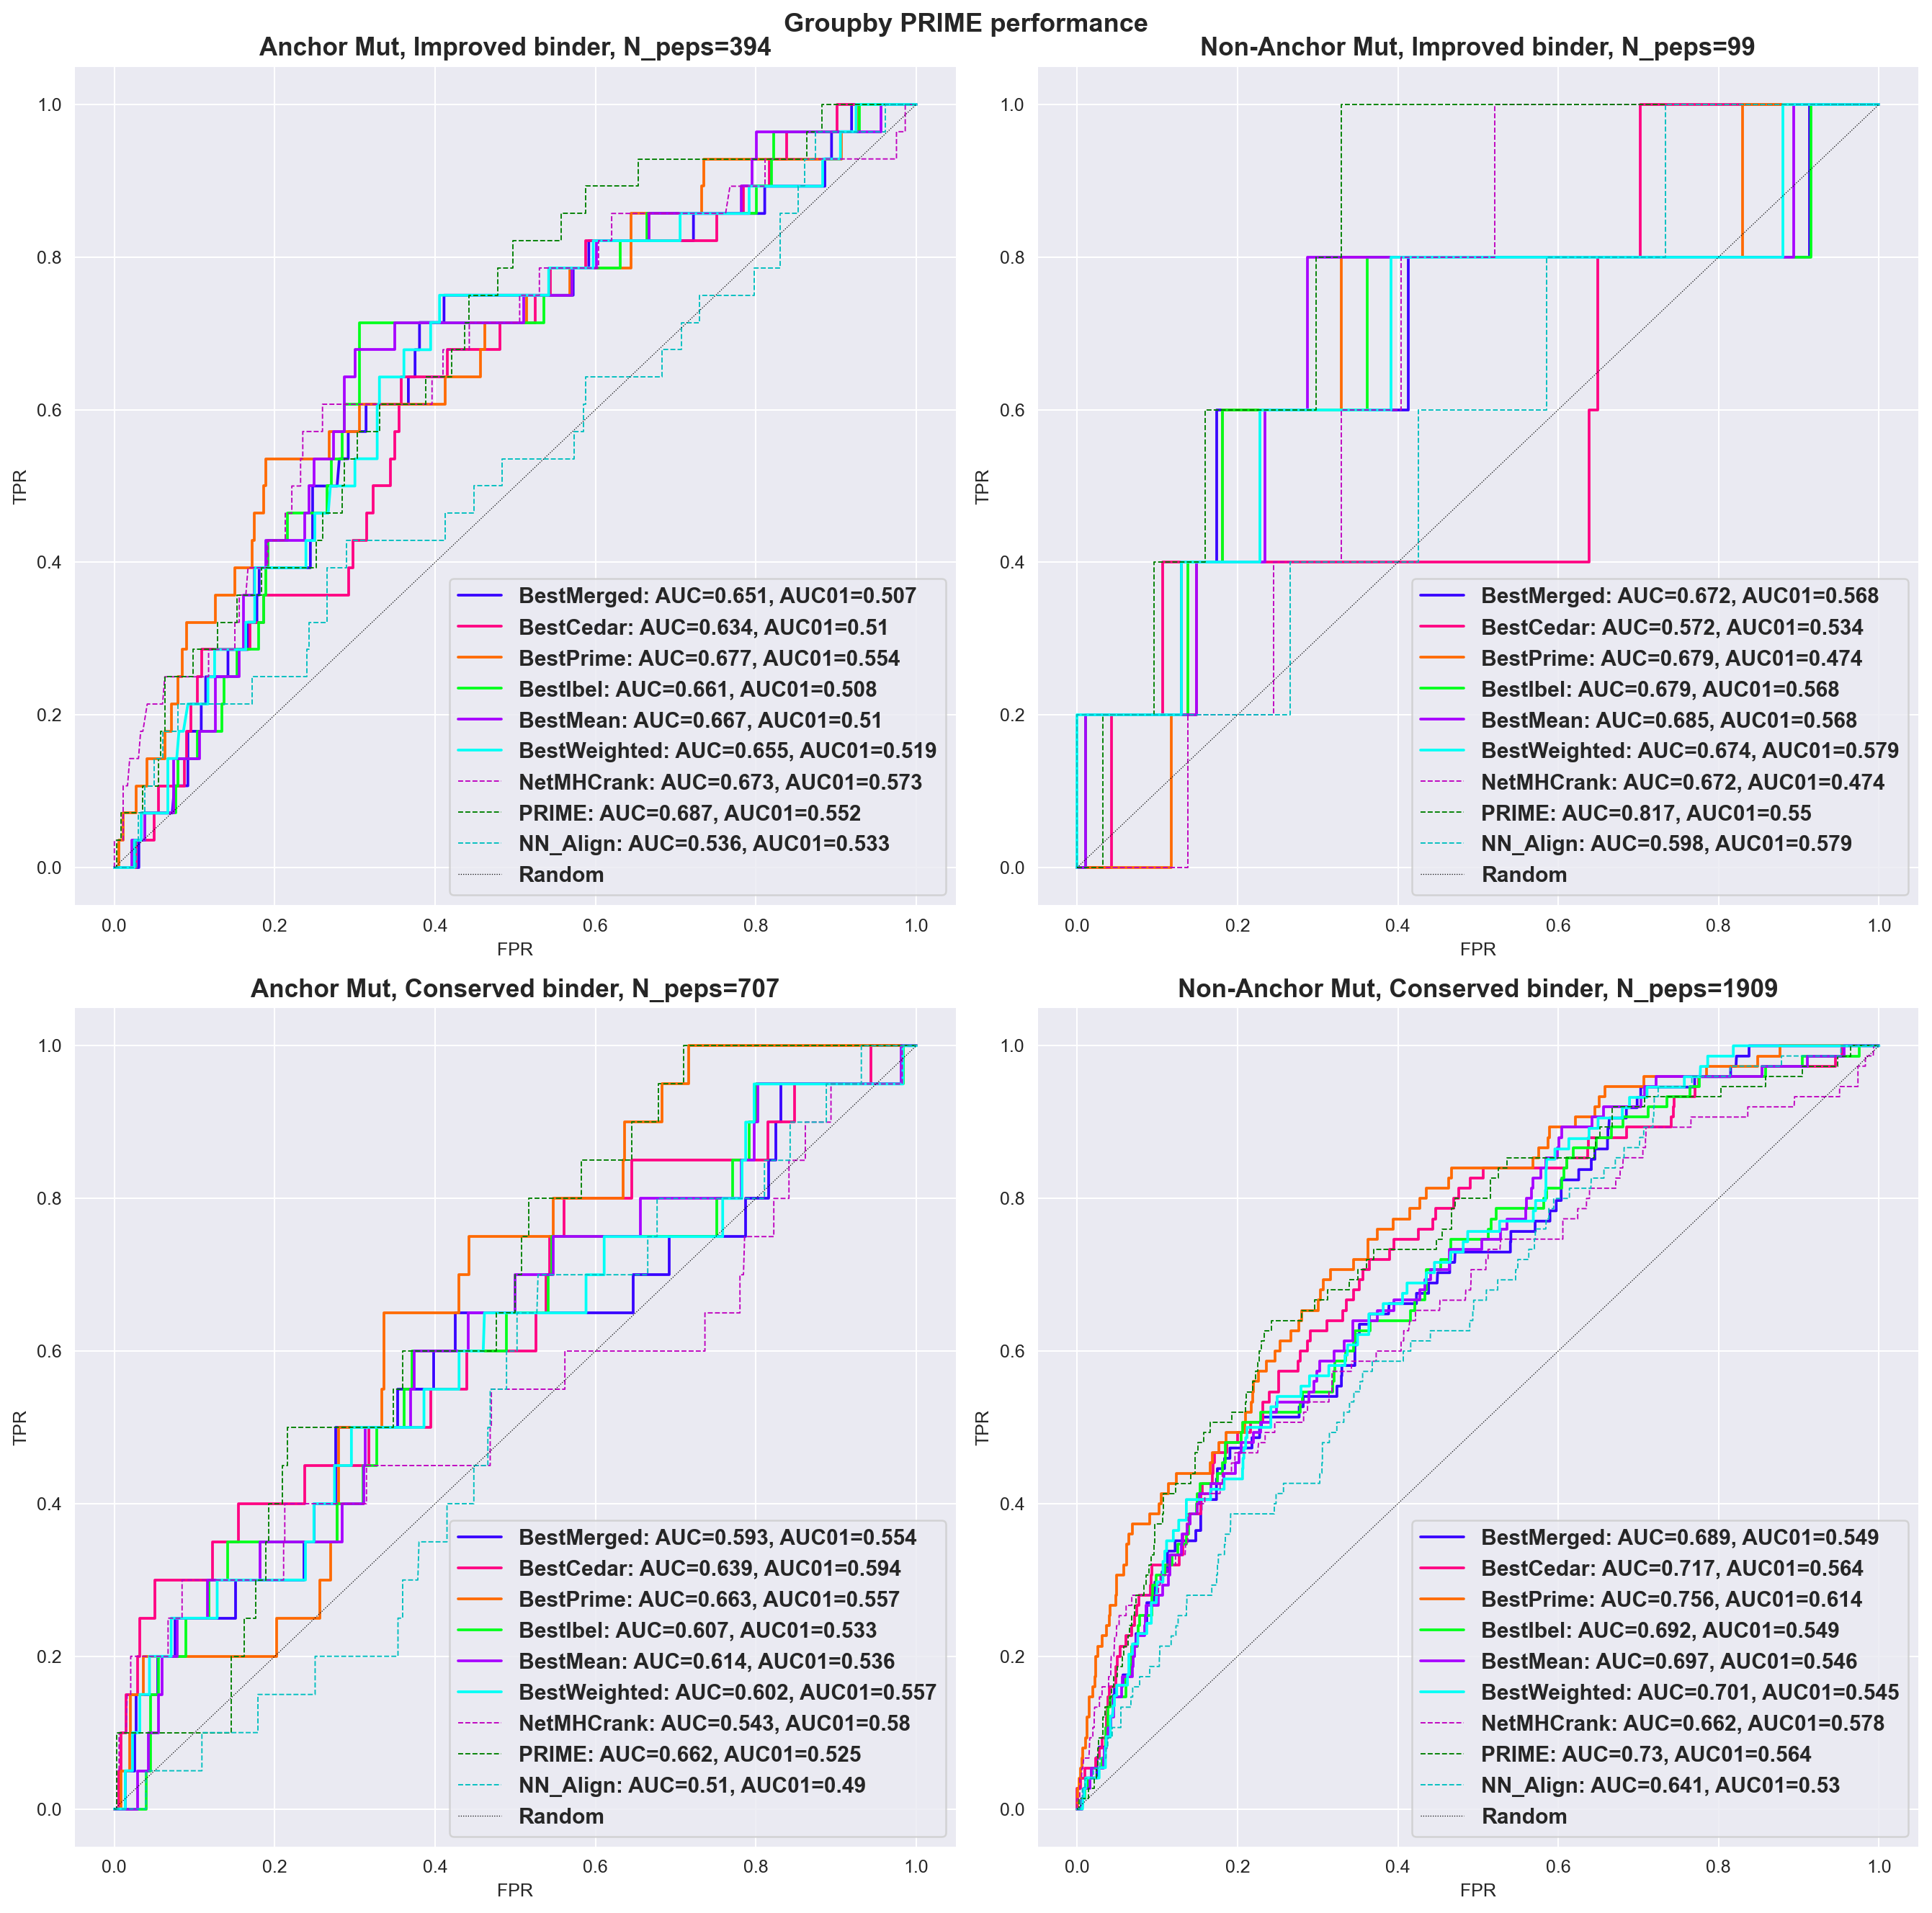

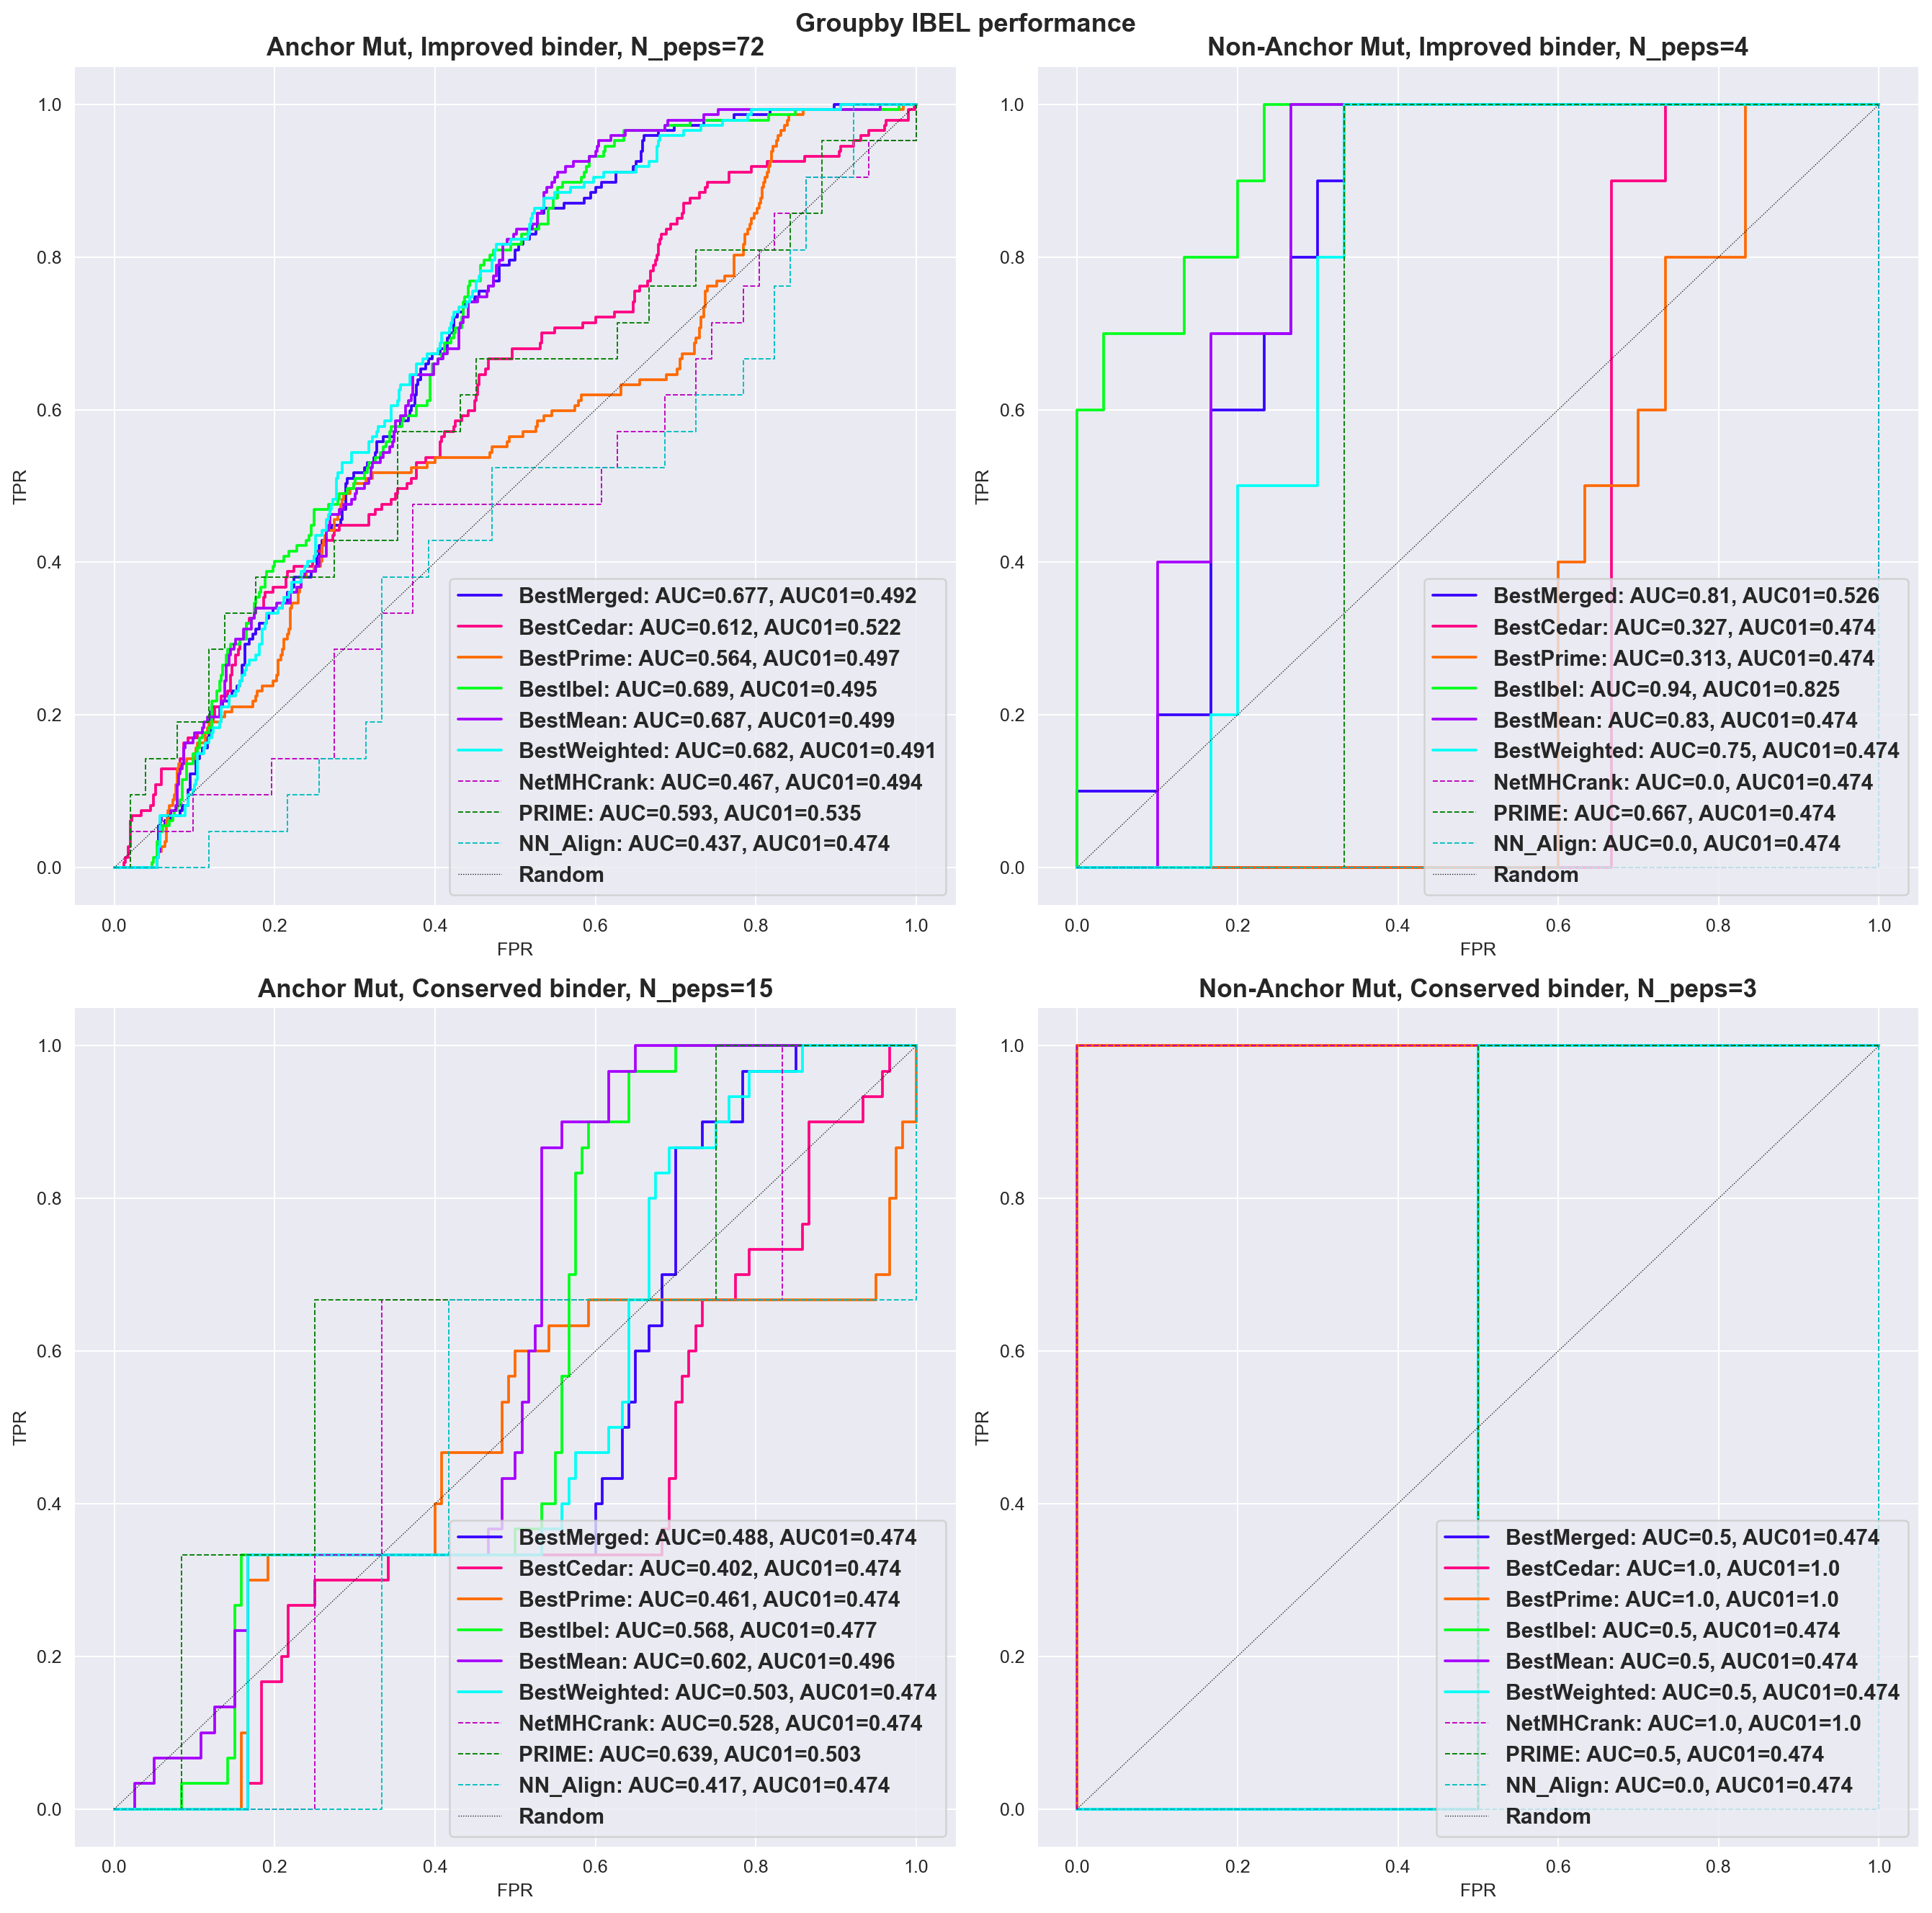

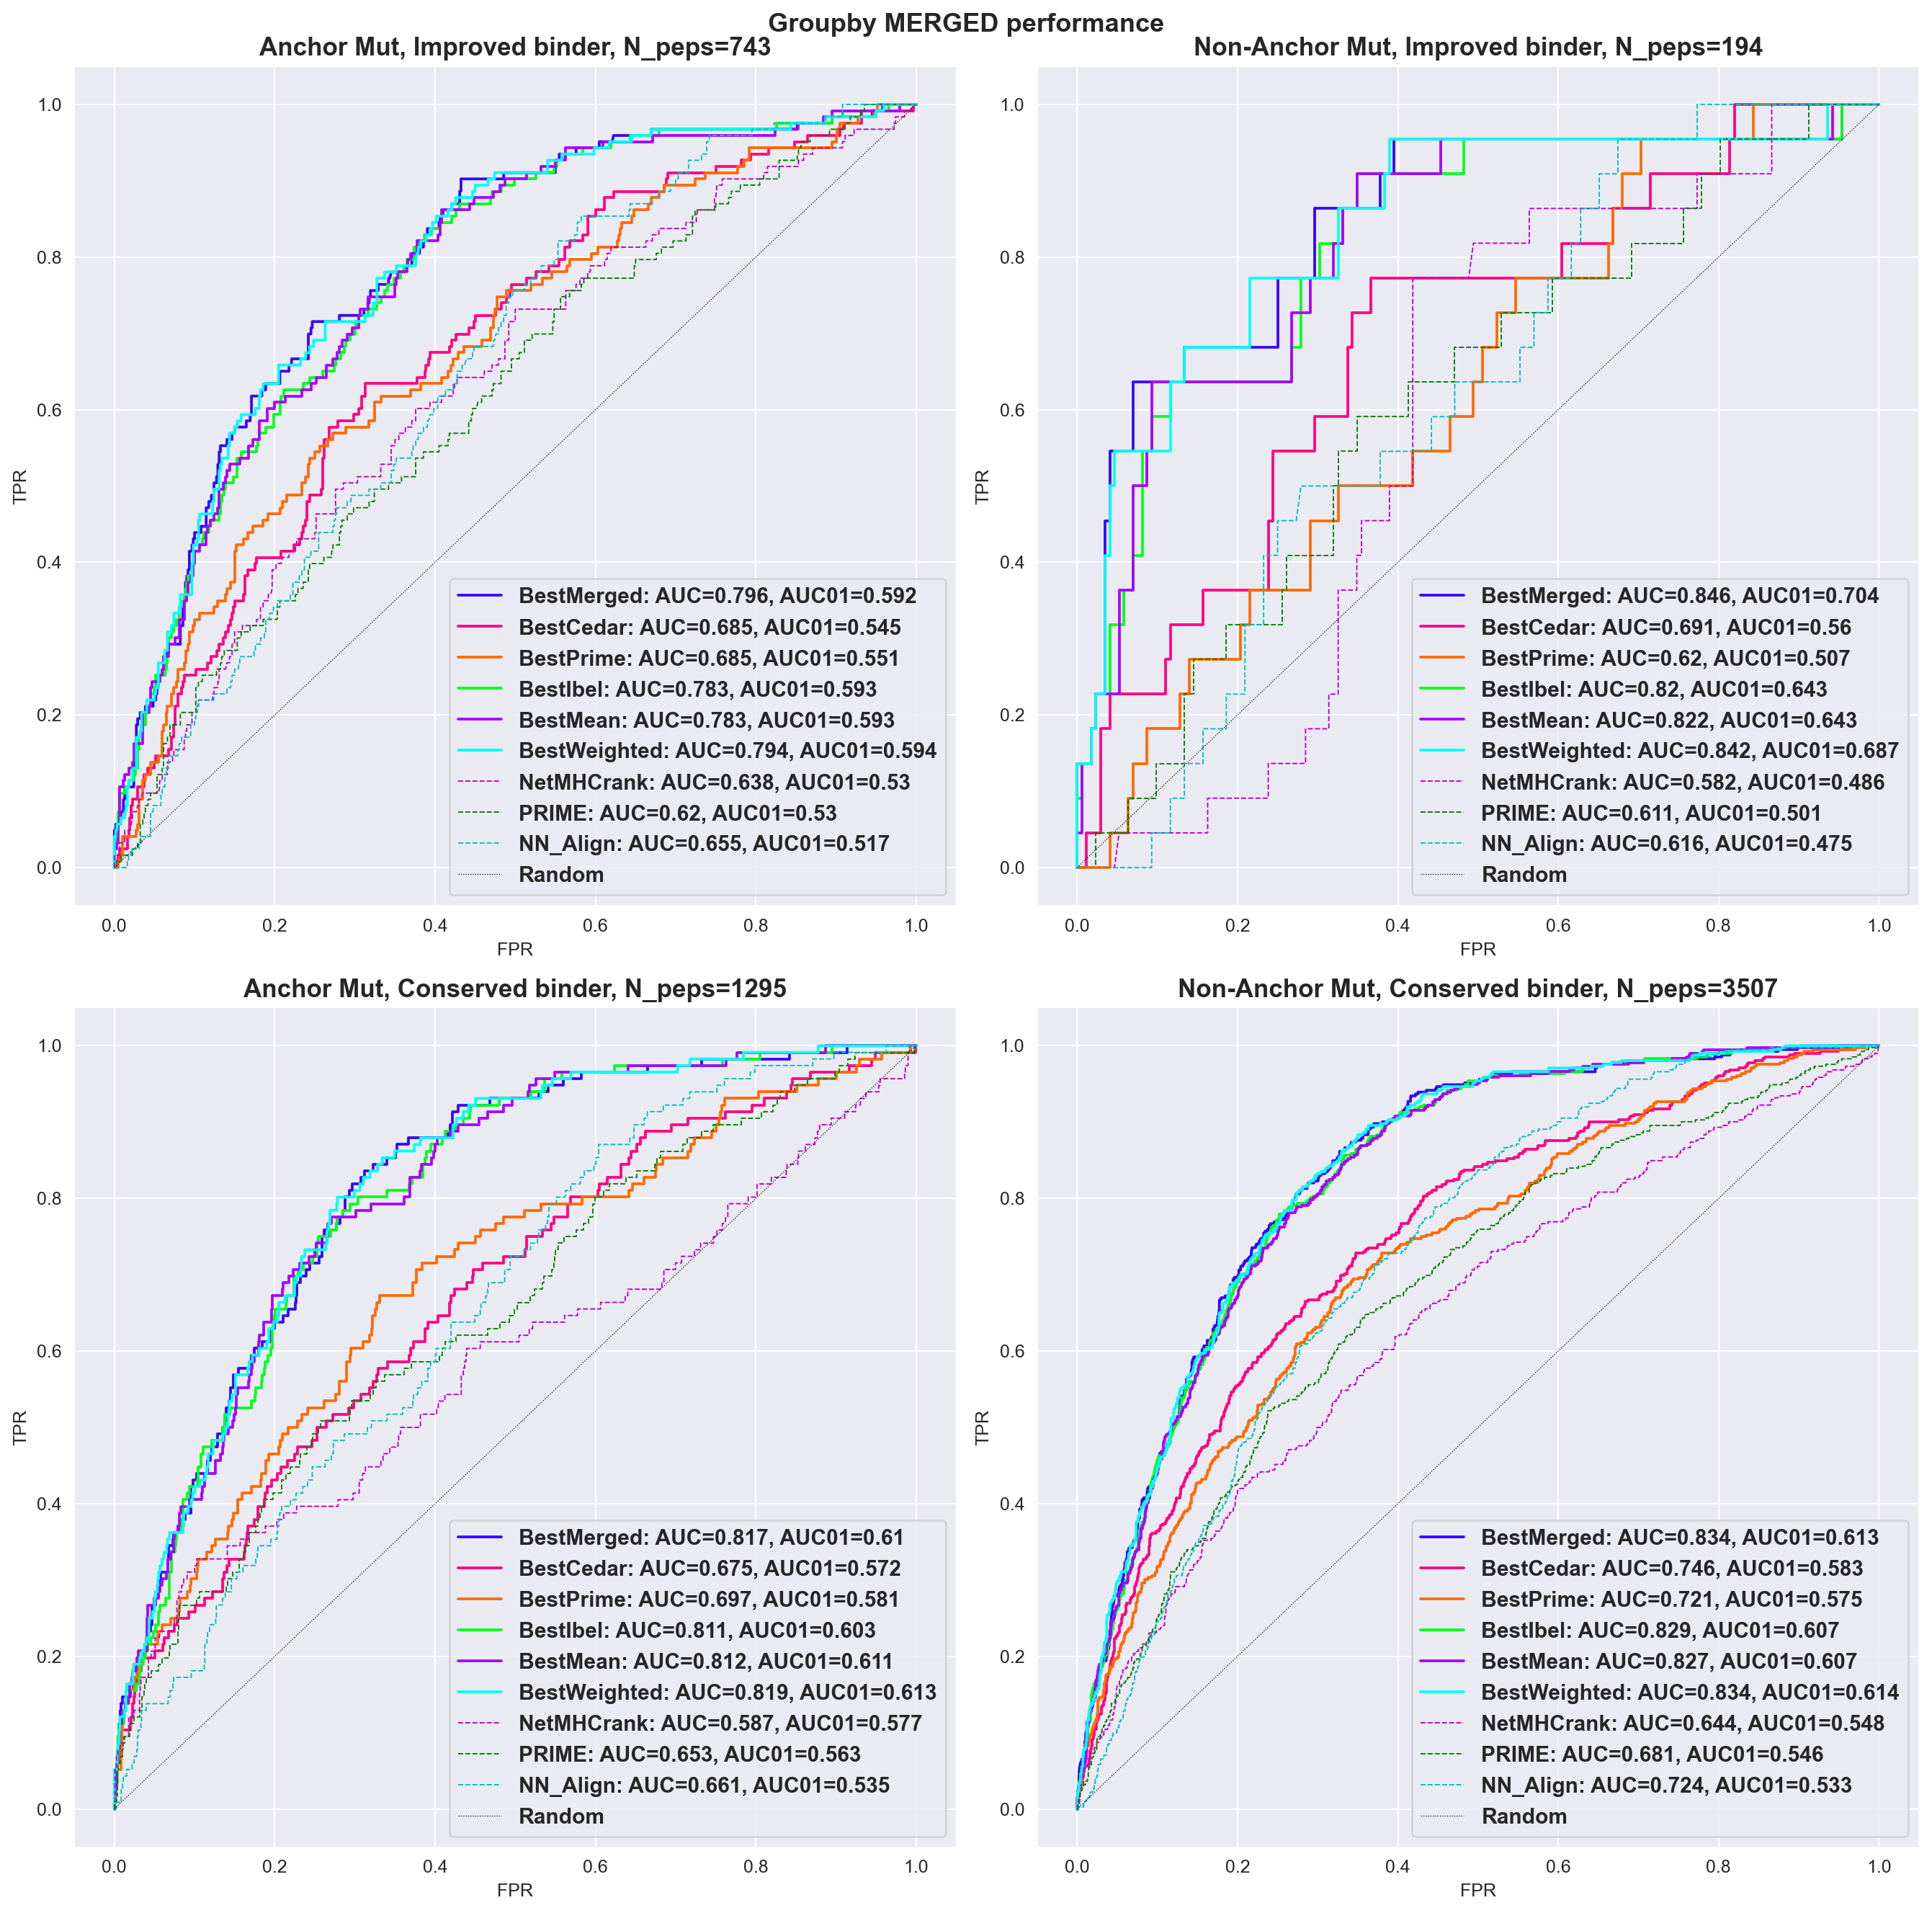

In [71]:
sns.set_palette(palette)
f_cedar,a_cedar = plt.subplots(2,2, figsize= (15,15))
ax_cedar = a_cedar.ravel()

f_prime,a_prime = plt.subplots(2,2, figsize= (15,15))
ax_prime = a_prime.ravel()

f_ibel, a_ibel = plt.subplots(2,2, figsize= (15,15))
ax_ibel = a_ibel.ravel()

f_merged, a_merged = plt.subplots(2,2, figsize= (15,15))
ax_merged = a_merged.ravel()
i=0
for binder in ['Improved', 'Conserved']:
    for anc in [True, False]:
        xd = 'Anchor Mut' if anc else 'Non-Anchor Mut'
        name = f'{xd}, {binder} binder'
        for k, df_ced, df_pr, df_ibel, df_merged in zip(['BestMerged','BestCedar', 'BestPrime', 'BestIbel', 'BestMean', 'BestWeighted'],
                                            [best_merged_cdt_cedar_preds, best_cedar_cdt_cedar_preds, best_prime_cdt_cedar_preds, best_ibel_cdt_cedar_preds, best_mean_cdt_cedar_preds, best_weighted_cdt_cedar_preds],
                                            [best_merged_cdt_prime_preds, best_cedar_cdt_prime_preds, best_prime_cdt_prime_preds, best_ibel_cdt_prime_preds, best_mean_cdt_prime_preds, best_weighted_cdt_prime_preds],
                                            [best_merged_cdt_ibel_preds, best_cedar_cdt_ibel_preds, best_prime_cdt_ibel_preds, best_ibel_cdt_ibel_preds, best_mean_cdt_ibel_preds, best_weighted_cdt_ibel_preds], 
                                            [best_merged_cdt_merged_preds, best_cedar_cdt_merged_preds, best_prime_cdt_merged_preds, best_ibel_cdt_merged_preds, best_mean_cdt_merged_preds, best_weighted_cdt_merged_preds]):
            
            values_cedar = get_roc(df_ced, 'pred','agg_label',  binder, anc)
            sns.lineplot(x=values_cedar['roc'][0], y=values_cedar['roc'][1], label=f"{k}: AUC={round(values_cedar['auc'],3)}, AUC01={round(values_cedar['auc01'],3)}", 
                         estimator = None, ax=ax_cedar[i])
            ax_cedar[i].set_title(f"{name}, N_peps={len(cedar_related.query('anchor_mutation==@anc and binder==@binder'))}", fontweight='semibold', fontsize=14)
            ax_cedar[i].set_xlabel('FPR')
            ax_cedar[i].set_ylabel('TPR')
            
            values_prime = get_roc(df_pr, 'mean_pred', 'agg_label', binder, anc)
            sns.lineplot(x=values_prime['roc'][0], y=values_prime['roc'][1], label=f"{k}: AUC={round(values_prime['auc'],3)}, AUC01={round(values_prime['auc01'],3)}", 
                         estimator = None, ax=ax_prime[i])
            ax_prime[i].set_title(f"{name}, N_peps={len(prime_related.query('anchor_mutation==@anc and binder==@binder'))}", fontweight='semibold', fontsize=14)
            ax_prime[i].set_xlabel('FPR')
            ax_prime[i].set_ylabel('TPR')
            
            
            values_ibel = get_roc(df_ibel, 'pred', 'agg_label', binder, anc)
            sns.lineplot(x=values_ibel['roc'][0], y=values_ibel['roc'][1], label=f"{k}: AUC={round(values_ibel['auc'],3)}, AUC01={round(values_ibel['auc01'],3)}", 
                         estimator = None, ax=ax_ibel[i])
            ax_ibel[i].set_title(f"{name}, N_peps={len(ibel.query('anchor_mutation==@anc and binder==@binder'))}", fontweight='semibold', fontsize=14)
            ax_ibel[i].set_xlabel('FPR')
            ax_ibel[i].set_ylabel('TPR')
            
            values_merged = get_roc(df_merged, 'pred', 'agg_label', binder, anc)
            sns.lineplot(x=values_merged['roc'][0], y=values_merged['roc'][1], label=f"{k}: AUC={round(values_merged['auc'],3)}, AUC01={round(values_merged['auc01'],3)}", 
                         estimator = None, ax=ax_merged[i])
            ax_merged[i].set_title(f"{name}, N_peps={len(cp_merged.query('anchor_mutation==@anc and binder==@binder'))}", fontweight='semibold', fontsize=14)
            ax_merged[i].set_xlabel('FPR')
            ax_merged[i].set_ylabel('TPR')
        
        plot_related_baseline_roc(ax_cedar[i], cedar_related_baseline, binder, anc, auc01=True)
        plot_related_baseline_roc(ax_prime[i], prime_related_baseline ,binder, anc, auc01=True)
        plot_related_baseline_roc(ax_ibel[i], ibel, binder, anc, auc01=True)
        plot_related_baseline_roc(ax_merged[i], cp_merged, binder, anc, auc01=True)

        ax_cedar[i].legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
        ax_prime[i].legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
        ax_ibel[i].legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
        ax_merged[i].legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
        
        f_cedar.suptitle('Groupby CEDAR performance', fontweight='semibold', fontsize=14.5)
        f_cedar.tight_layout()
        f_prime.suptitle('Groupby PRIME performance', fontweight='semibold', fontsize=14.5)
        f_prime.tight_layout()
        f_ibel.suptitle('Groupby IBEL performance', fontweight='semibold', fontsize=14.5)
        f_ibel.tight_layout()
        f_merged.suptitle('Groupby MERGED performance', fontweight='semibold', fontsize=14.5)
        f_merged.tight_layout()
        i+=1

### Standalone

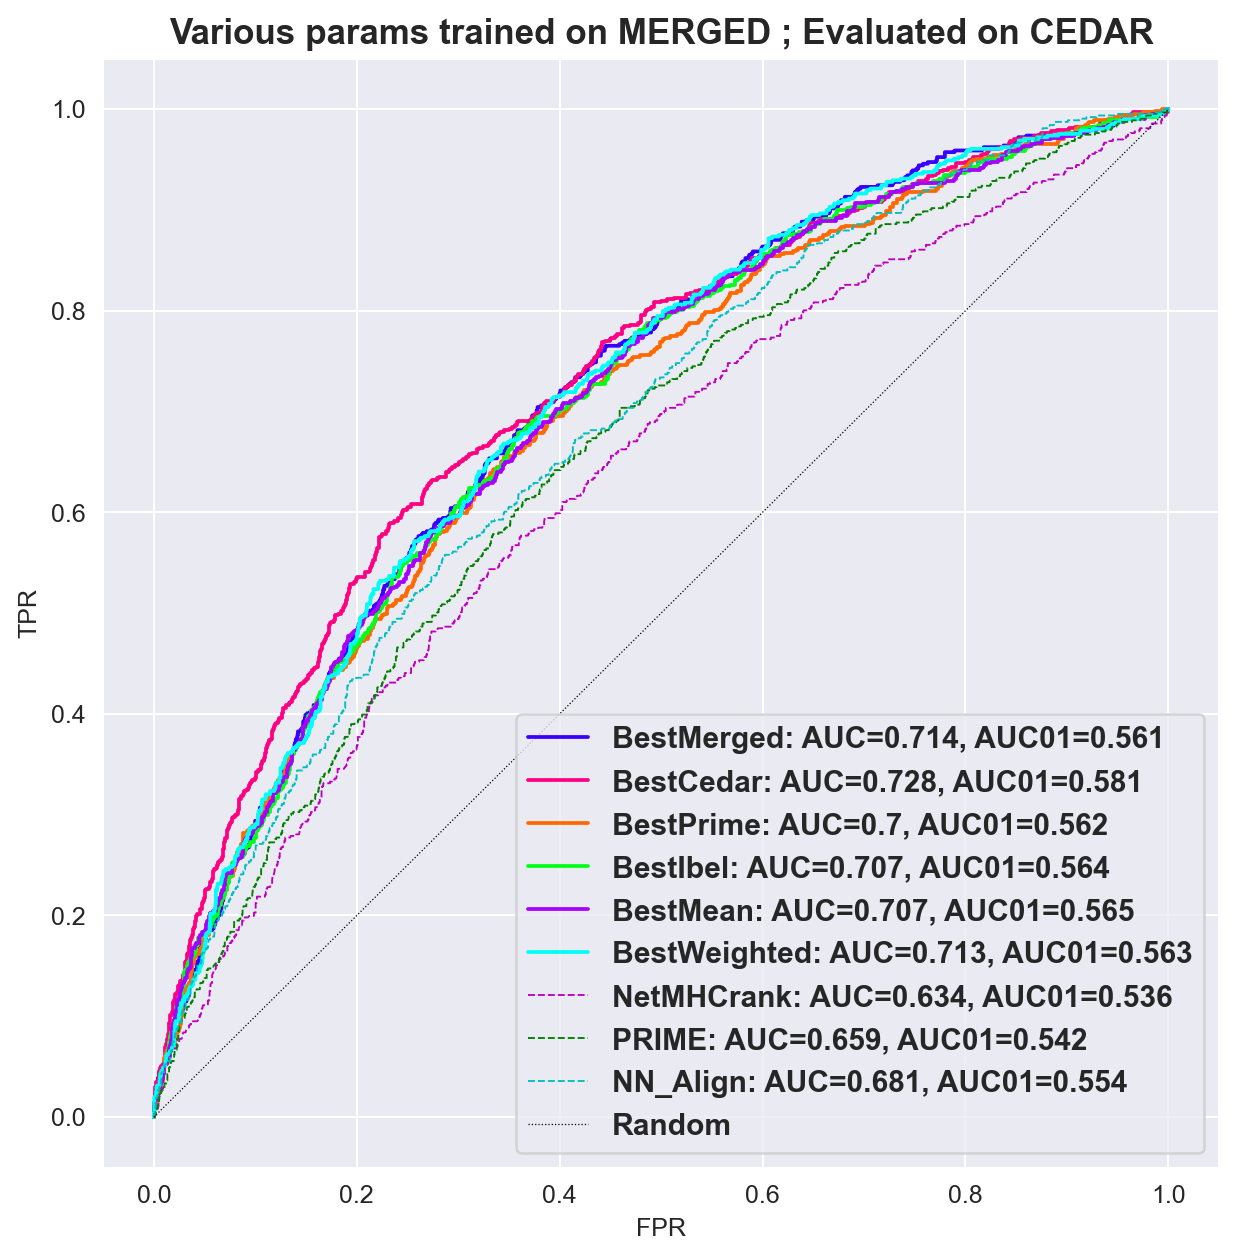

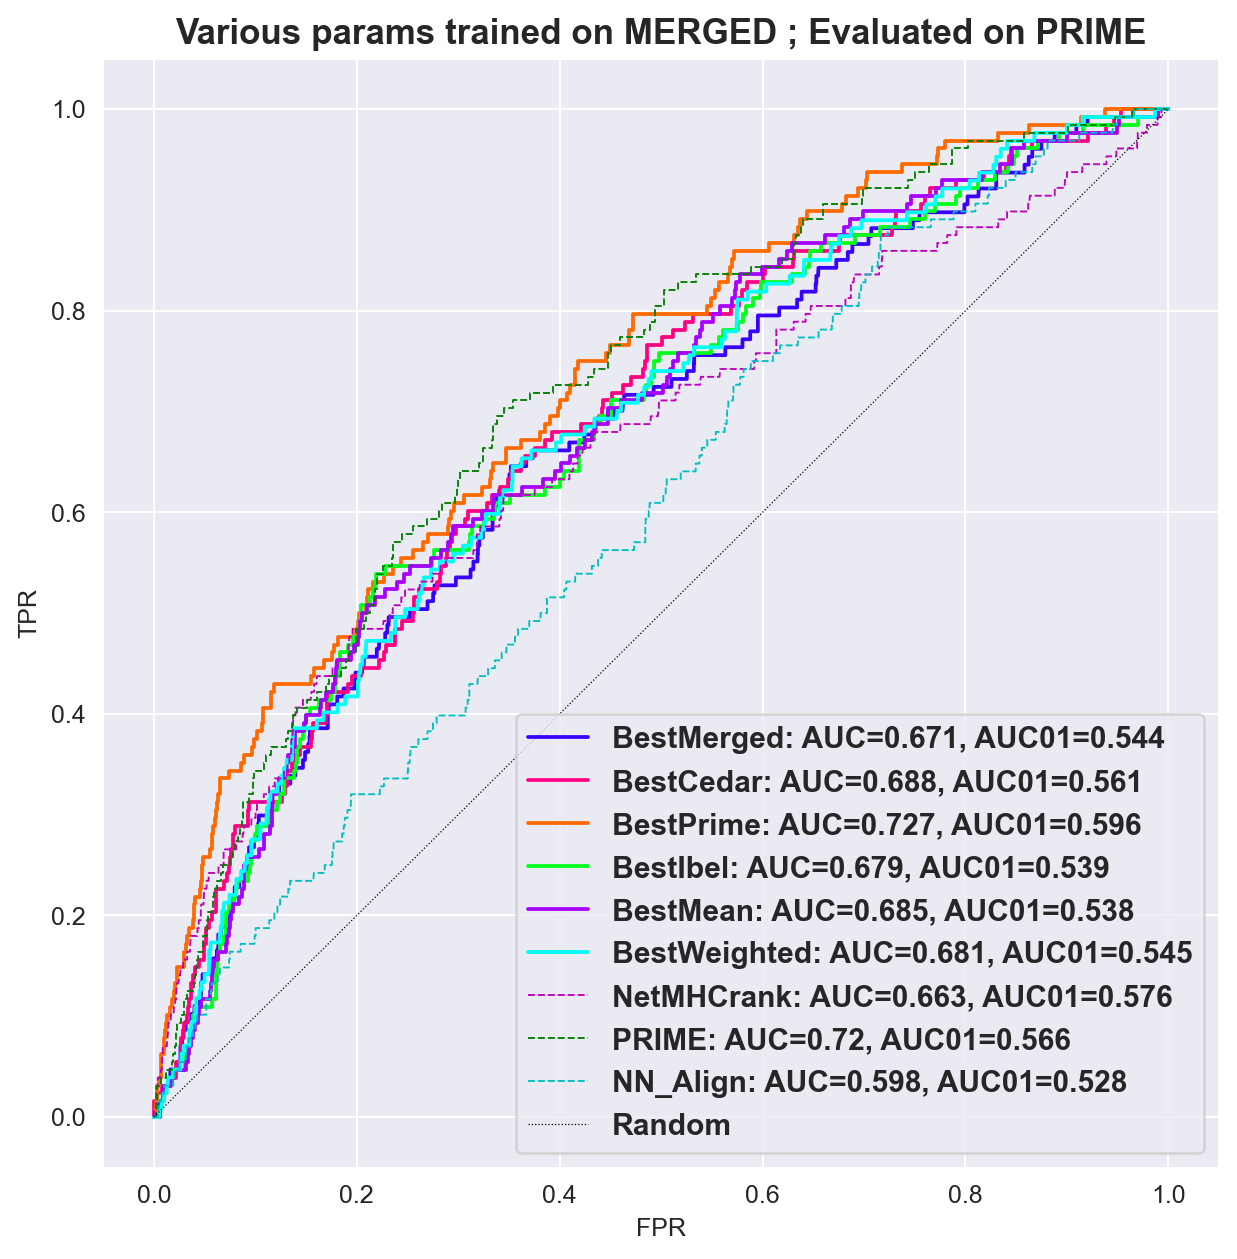

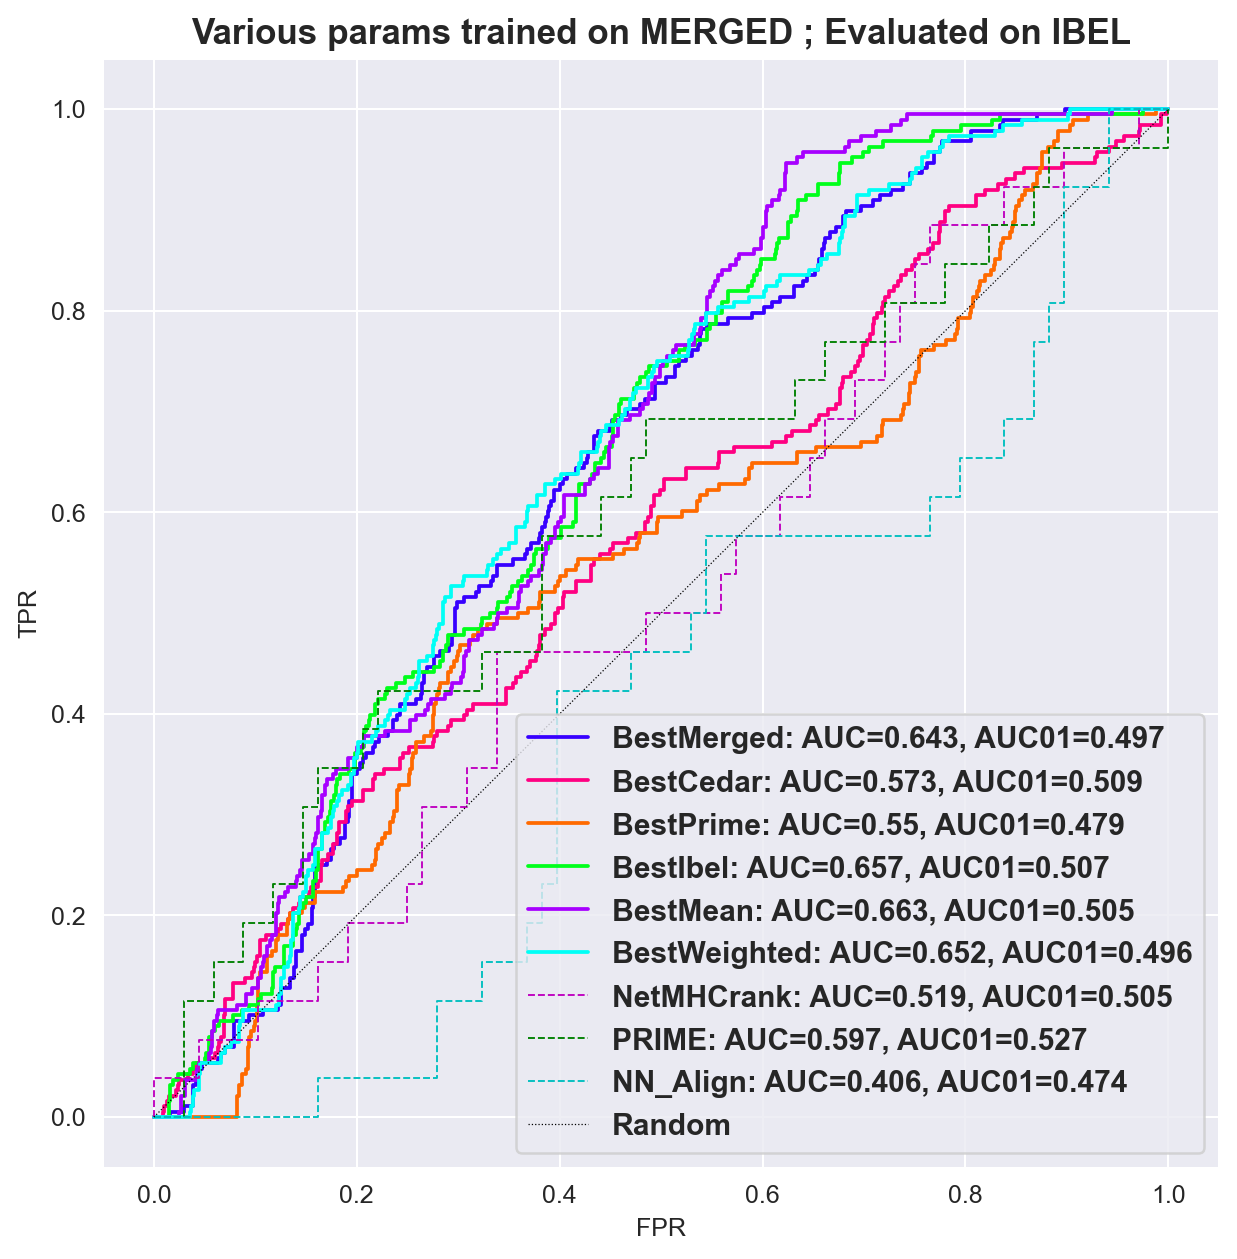

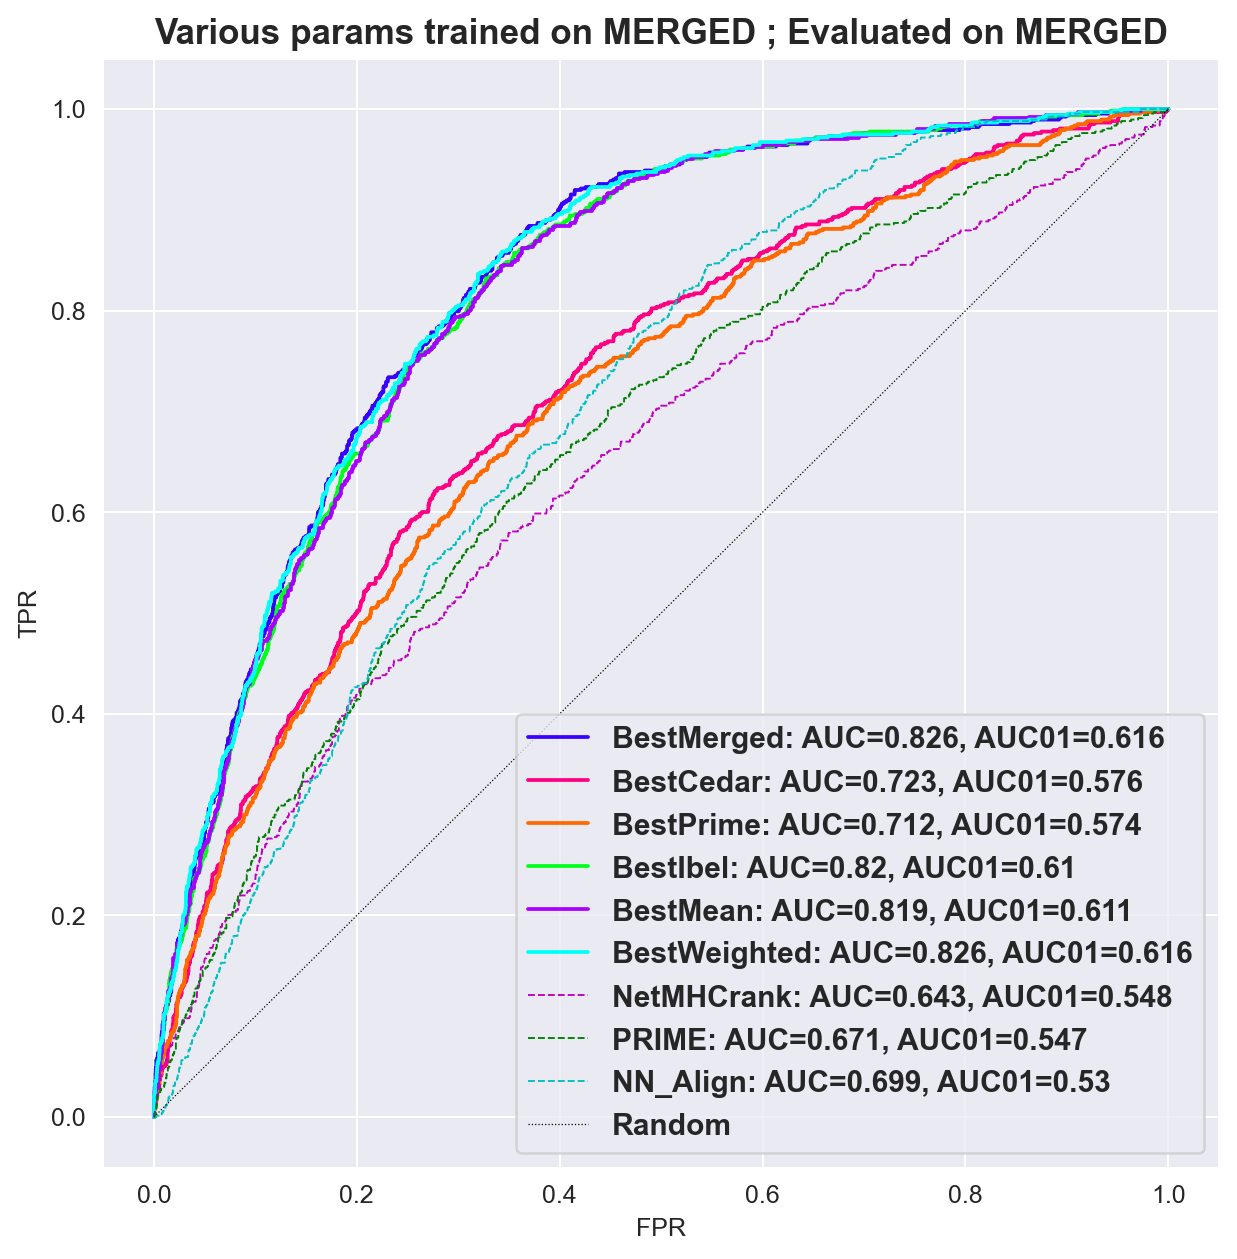

In [82]:
sns.set_palette(palette)
f_cedar,ax_cedar = plt.subplots(1,1, figsize=(8,8))

f_prime,ax_prime = plt.subplots(1,1, figsize=(8,8))

f_ibel, ax_ibel = plt.subplots(1,1, figsize=(8,8))

f_merged, ax_merged = plt.subplots(1,1, figsize=(8,8))
for k, df_ced, df_pr, df_ibel, df_merged in zip(['BestMerged','BestCedar', 'BestPrime', 'BestIbel', 'BestMean', 'BestWeighted'],
                                            [best_merged_cdt_cedar_preds, best_cedar_cdt_cedar_preds, best_prime_cdt_cedar_preds, best_ibel_cdt_cedar_preds, best_mean_cdt_cedar_preds, best_weighted_cdt_cedar_preds],
                                            [best_merged_cdt_prime_preds, best_cedar_cdt_prime_preds, best_prime_cdt_prime_preds, best_ibel_cdt_prime_preds, best_mean_cdt_prime_preds, best_weighted_cdt_prime_preds],
                                            [best_merged_cdt_ibel_preds, best_cedar_cdt_ibel_preds, best_prime_cdt_ibel_preds, best_ibel_cdt_ibel_preds, best_mean_cdt_ibel_preds, best_weighted_cdt_ibel_preds], 
                                            [best_merged_cdt_merged_preds, best_cedar_cdt_merged_preds, best_prime_cdt_merged_preds, best_ibel_cdt_merged_preds, best_mean_cdt_merged_preds, best_weighted_cdt_merged_preds]):
            
    values_cedar = get_roc(df_ced, 'pred','agg_label',  None, None)
    sns.lineplot(x=values_cedar['roc'][0], y=values_cedar['roc'][1], label=f"{k}: AUC={round(values_cedar['auc'],3)}, AUC01={round(values_cedar['auc01'],3)}", 
                 estimator = None, ax=ax_cedar)

    
    values_prime = get_roc(df_pr, 'mean_pred', 'agg_label', None, None)
    sns.lineplot(x=values_prime['roc'][0], y=values_prime['roc'][1], label=f"{k}: AUC={round(values_prime['auc'],3)}, AUC01={round(values_prime['auc01'],3)}", 
                 estimator = None, ax=ax_prime)
    
  
    values_ibel = get_roc(df_ibel, 'pred', 'agg_label', None, None)
    sns.lineplot(x=values_ibel['roc'][0], y=values_ibel['roc'][1], label=f"{k}: AUC={round(values_ibel['auc'],3)}, AUC01={round(values_ibel['auc01'],3)}", 
                 estimator = None, ax=ax_ibel)
    
    values_merged = get_roc(df_merged, 'pred', 'agg_label', None, None)
    sns.lineplot(x=values_merged['roc'][0], y=values_merged['roc'][1], label=f"{k}: AUC={round(values_merged['auc'],3)}, AUC01={round(values_merged['auc01'],3)}", 
                 estimator = None, ax=ax_merged)

ax_cedar.set_title("Various params trained on MERGED ; Evaluated on CEDAR", fontweight='semibold', fontsize=14)
ax_cedar.set_xlabel('FPR')
ax_cedar.set_ylabel('TPR')

ax_prime.set_title("Various params trained on MERGED ; Evaluated on PRIME", fontweight='semibold', fontsize=14)
ax_prime.set_xlabel('FPR')
ax_prime.set_ylabel('TPR')

ax_ibel.set_title("Various params trained on MERGED ; Evaluated on IBEL", fontweight='semibold', fontsize=14)
ax_ibel.set_xlabel('FPR')
ax_ibel.set_ylabel('TPR')

ax_merged.set_title("Various params trained on MERGED ; Evaluated on MERGED", fontweight='semibold', fontsize=14)
ax_merged.set_xlabel('FPR')
ax_merged.set_ylabel('TPR')
plot_related_baseline_roc(ax_cedar, cedar_related_baseline, binder=None, anchor_mutation=None, auc01=True)
plot_related_baseline_roc(ax_prime, prime_related_baseline ,binder=None, anchor_mutation=None, auc01=True)
plot_related_baseline_roc(ax_ibel, ibel, binder=None, anchor_mutation=None, auc01=True)
plot_related_baseline_roc(ax_merged, cp_merged, binder=None, anchor_mutation=None, auc01=True)

ax_cedar.legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
ax_prime.legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
ax_ibel.legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
ax_merged.legend(loc='lower right',  prop={'weight':'semibold', 'size':12})


# Retrain best models

Because I forgot to include predicted labels and not only scores lol

In [478]:
from joblib import Parallel, delayed
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def bootstrap_wrapper(y_score, y_true, seed):
    np.random.seed(seed)
    sample_idx = np.random.randint(0, len(y_score), len(y_score))
    sample_score = y_score[sample_idx]
    sample_true = y_true[sample_idx]

    try:
        test_results = get_metrics(sample_true, sample_score)
    except:
        return pd.DataFrame(), (None, None, None, None)

    # Save to get mean curves after
    roc_curve = (test_results.pop('roc_curve'), test_results['auc'])
    # Same
    pr_curve = (test_results.pop('pr_curve'), test_results['prauc'])
    return pd.DataFrame(test_results, index=[0]), roc_curve


def bootstrap_eval(y_score, y_true, n_rounds=10000, n_jobs=16):
    wrapper = partial(bootstrap_wrapper,
                      y_score=y_score, y_true=y_true)
    print('Sampling')
    output = Parallel(n_jobs=n_jobs)(delayed(wrapper)(seed=seed) for seed in
                                     tqdm(range(n_rounds), desc='Bootstrapping rounds', position=1, leave=False))

    print('Making results DF and curves')
    result_df = pd.concat([x[0] for x in output])
    mean_roc_curve = get_mean_roc_curve([x[1] for x in output if x[1][0] is not None])
    # mean_pr_curve = get_mean_pr_curve([x[2] for x in output])
    return result_df, mean_roc_curve


def assert_encoding_kwargs(encoding_kwargs, mode_eval=False):
    """
    Assertion / checks for encoding kwargs and verify all the necessary key-values 
    are in
    """
    # Making a deep copy since dicts are mutable between fct calls
    encoding_kwargs = deepcopy(encoding_kwargs)
    if encoding_kwargs is None:
        encoding_kwargs = {'max_len': 12,
                           'encoding': 'onehot',
                           'blosum_matrix': None,
                           'standardize': False}
    essential_keys = ['max_len', 'encoding', 'blosum_matrix', 'standardize']
    assert all([x in encoding_kwargs.keys() for x in
                essential_keys]), f'Encoding kwargs don\'t contain the essential key-value pairs! ' \
                                  f"{'max_len', 'encoding', 'blosum_matrix', 'standardize'} are required."

    if mode_eval:
        if any([(x not in encoding_kwargs.keys()) for x in ['seq_col', 'hla_col', 'target_col', 'rank_col']]):
            if 'seq_col' not in encoding_kwargs.keys():
                encoding_kwargs.update({'seq_col': 'Peptide'})
            if 'hla_col' not in encoding_kwargs.keys():
                encoding_kwargs.update({'hla_col': 'HLA'})
            if 'target_col' not in encoding_kwargs.keys():
                encoding_kwargs.update({'target_col': 'agg_label'})
            if 'rank_col' not in encoding_kwargs.keys():
                encoding_kwargs.update({'seq_col': 'trueHLA_EL_rank'})

        # This KWARGS not needed in eval mode since I'm using Pipeline and Wrapper
        del encoding_kwargs['standardize']
    return encoding_kwargs


def get_predictions(df, models, ics_dict, encoding_kwargs):
    """
    Args:
        models (list) : list of all the models for a given fold. Should be a LIST
        ics_dict (dict): weights or None
        encoding_kwargs: the kwargs needed to process the df
        metrics (dict):

    Returns:
        predictions_df (pd
        df (pd.DataFrame): DataFrame containing the Peptide-HLA pairs to evaluate
        models (list): A.DataFrame): Original DataFrame + a column predictions which are the scores + y_true
    """

    df = df.copy()

    # HERE NEED TO DO SWITCH CASES
    x, y = get_mutation_dataset(df, ics_dict, **encoding_kwargs)

    # Take the first model in the list and get its class
    model_class = models[0].__class__

    # If model is a scikit-learn model, get pred prob
    # if issubclass(model_class, sklearn.base.BaseEstimator):
    average_predictions = [model.predict_proba(x)[:, 1] \
                           for model in models]

    average_predictions = np.mean(np.stack(average_predictions), axis=0)
    # assert len(average_predictions)==len(df), f'Wrong shapes passed preds:{len(average_predictions)},df:{len(df)}'
    output_df = df.copy(deep=True)
    output_df['pred'] = average_predictions
    return output_df


# TRAIN WITH PARALLEL WRAPPER
def parallel_inner_train_wrapper(train_dataframe, x_test, base_model, ics_dict,
                                 encoding_kwargs, standardize, fold_out, fold_in):
    seed = fold_out * 10 + fold_in
    # Copy the base model, resets the seed
    model = sklearn.base.clone(base_model)
    model.set_params(random_state=seed)
    if standardize:
        model = Pipeline([('scaler', StandardScaler()), ('model', model)])

    # Here resets model weight at every fold, using the fold number (range(0, n_folds*(n_folds-1)) ) as seed
    # Query subset dataframe and get encoded data and targets
    train = train_dataframe.query('fold != @fold_out and fold != @fold_in').reset_index(drop=True)
    valid = train_dataframe.query('fold == @fold_in').reset_index(drop=True)
    # Get datasets
    x_train, y_train = get_mutation_dataset(train, ics_dict, **encoding_kwargs)
    x_valid, y_valid = get_mutation_dataset(valid, ics_dict, **encoding_kwargs)

    # Fit the model and append it to the list
    model.fit(x_train, y_train)

    # Get the prediction values on both the train and validation set
    y_train_pred, y_train_score = model.predict(x_train), model.predict_proba(x_train)[:, 1]
    y_val_pred, y_val_score = model.predict(x_valid), model.predict_proba(x_valid)[:, 1]
    # Get the metrics and save them
    train_metrics = get_metrics(y_train, y_train_score, y_train_pred)
    valid_metrics = get_metrics(y_valid, y_val_score, y_val_pred)
    y_pred_test = model.predict_proba(x_test)[:, 1]

    return model, train_metrics, valid_metrics, y_pred_test


def nested_kcv_train_mut(dataframe, base_model, ics_dict, encoding_kwargs: dict = None, n_jobs=None):
    """
    Args:
        dataframe:
        base_model:
        ics_dict:
        encoding_kwargs:

    Returns:
        models_fold
        train_results
        test_results
    """
    encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=False)
    #
    models_dict = {}
    test_metrics = {}
    train_metrics = {}
    folds = sorted(dataframe.fold.unique())
    std = encoding_kwargs.pop('standardize')
    for fold_out in tqdm(folds, leave=False, desc='Outer fold', position=2):
        # Get test set & init models list to house all models trained in inner fold
        test = dataframe.query('fold == @fold_out').reset_index(drop=True)
        x_test, y_test = get_mutation_dataset(test, ics_dict, **encoding_kwargs)
        # For a given fold, all the models that are trained should be appended to this list
        inner_folds = sorted([f for f in folds if f != fold_out])
        n_jobs = len(inner_folds) if n_jobs is None else n_jobs
        # Create the sub-dict and put the model into the models dict
        train_wrapper_ = partial(parallel_inner_train_wrapper, train_dataframe=dataframe, x_test=x_test,
                                 base_model=base_model, ics_dict=ics_dict, encoding_kwargs=encoding_kwargs,
                                 standardize=std, fold_out=fold_out)
        output = Parallel(n_jobs=n_jobs)(
            delayed(train_wrapper_)(fold_in=fold_in) for fold_in in tqdm(inner_folds,
                                                                         desc='Inner Folds',
                                                                         leave=False, position=1))
        models_dict[fold_out] = [x[0] for x in output]
        train_tmp = [x[1] for x in output]
        valid_tmp = [x[2] for x in output]
        avg_prediction = [x[3] for x in output]
        avg_prediction = np.mean(np.stack(avg_prediction), axis=0)
        train_metrics[fold_out] = {k: {'train': v_train,
                                       'valid': v_valid} for k, v_train, v_valid in
                                   zip(inner_folds, train_tmp, valid_tmp)}
        test_metrics[fold_out] = get_metrics(y_test, avg_prediction)

    return models_dict, train_metrics, test_metrics


# EVAL WITH PARALLEL WRAPPER
def parallel_eval_wrapper(test_dataframe, models_list, ics_dict,
                          train_dataframe, encoding_kwargs, fold_out):
    # If no train dataframe provided and test_dataframe is partitioned,
    # It will eval on each of the folds
    if 'fold' in test_dataframe.columns and test_dataframe.equals(train_dataframe):
        test_df = test_dataframe.query('fold==@fold_out')
    else:
        test_df = test_dataframe.copy().reset_index(drop=True)

    if train_dataframe is not None and not train_dataframe.equals(test_dataframe):
        tmp = train_dataframe.query('fold != @fold_out')
        train_peps = tmp[encoding_kwargs['seq_col']].unique()
        test_df = test_df.query(f'{encoding_kwargs["seq_col"]} not in @train_peps')

    predictions_df = get_predictions(test_df, models_list, ics_dict, encoding_kwargs)
    test_metrics = get_metrics(predictions_df[encoding_kwargs['target_col']].values,
                               predictions_df['pred'].values)
    return predictions_df, test_metrics


def evaluate_trained_models_mut(test_dataframe, models_dict, ics_dict,
                                train_dataframe=None,
                                encoding_kwargs: dict = None,
                                concatenated=False, only_concat=False):
    """

    Args:
        dataframe:
        models_dict:
        ics_dict:
        train_metrics (dict): Should be used if standardize in encoding_kwargs is True...
        encoding_kwargs:
        concatenated:
        only_concat:

    Returns:
        test_results
        predictions_df
    """
    encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=True)
    # Wrapper and parallel evaluation
    eval_wrapper_ = partial(parallel_eval_wrapper, test_dataframe=test_dataframe, ics_dict=ics_dict,
                            train_dataframe=train_dataframe, encoding_kwargs=encoding_kwargs)

    output = Parallel(n_jobs=8)(delayed(eval_wrapper_)(fold_out=fold_out, models_list=models_list) \
                                for (fold_out, models_list) in tqdm(models_dict.items(),
                                                                    desc='Eval Folds',
                                                                    leave=False,
                                                                    position=2))
    predictions_df = [x[0] for x in output]
    # print('here', len(predictions_df), len(predictions_df[0]))
    test_metrics = [x[1] for x in output]

    test_results = {k: v for k, v in zip(models_dict.keys(), test_metrics)}

    # Here simply concatenates it to get all the predictions from the folds
    predictions_df = pd.concat(predictions_df)

    # Here get the concat results
    if concatenated:
        test_results['concatenated'] = get_metrics(predictions_df[encoding_kwargs['target_col']].values,
                                                   predictions_df['pred'].values)
    # Either concatenated, or mean predictions
    else:
        # obj_cols = [x for x,y in zip(predictions_df.dtypes.index, predictions_df.dtypes.values) if y=='object']
        cols = [encoding_kwargs['seq_col'], encoding_kwargs['hla_col'], encoding_kwargs['target_col']]
        mean_preds = predictions_df.groupby(cols).agg(mean_pred=('pred', 'mean'))
        predictions_df = test_dataframe.merge(mean_preds, left_on=cols, right_on=cols, suffixes=[None, None])
    # print('there', len(predictions_df))

    if only_concat and concatenated:
        keys_del = [k for k in test_results if k != 'concatenated']
        for k in keys_del:
            del test_results[k]

    return test_results, predictions_df


## fix prediction bullshit

In [351]:
sample_models = pkl_load('../output/sample_models_only_rank_noweights_onehot.pkl')
models = sample_models[0]


In [ ]:
cedar_rela

In [362]:
from src.data_processing import get_mutation_dataset
encoding_kwargs={'encoding':'onehot',
                 'blosum_matrix':None,
                 'max_len':12,
                 'add_rank':True,
                 'mask':False,
                 'add_aaprop':False,
                 'remove_pep':False,
                 'standardize':True,
                 'target_col':'agg_label',
                 'mut_col':[]}

std = encoding_kwargs.pop('standardize')
# fixing the get prediction fct
cedar_related['sample_weight'] = 3*(cedar_related['agg_label']+1)
df = cedar_related.sample(100, weights='sample_weight').copy()
# HERE NEED TO DO SWITCH CASES
x, y = get_mutation_dataset(df, None, **encoding_kwargs)

# Take the first model in the list and get its class
model_class = models[0].__class__

# If model is a scikit-learn model, get pred prob
# if issubclass(model_class, sklearn.base.BaseEstimator):

# THESE ARE SCORES
average_predictions_scores = [model.predict_proba(x)[:, 1] \
                       for model in models]
average_predictions_scores = np.mean(np.stack(average_predictions_scores), axis=0)
# assert len(average_predictions)==len(df), f'Wrong shapes passed preds:{len(average_predictions)},df:{len(df)}'
output_df = df.copy(deep=True)
output_df['pred'] = average_predictions_scores

In [376]:
# If I threshold like this, might not be an accurate prediction as it doesnt take into account the other folds
# Could make the function so that it sums/combines all the predictions and then just divides by the total number
# of models that has evaluated it, using a prediction + a count column, then the final prediction is just
# 1 if sum(preds)/count > 0.5, else 0
np.array([0 if x<.5 else 1 for x in average_predictions])


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [386]:
output_df.iloc[[13]]

Peptide        HLA  EL_rank_mut  agg_label  fold  EL_rank_wt  \
2513  TLHGFMMYL  HLA-A3002       1.1989          1     3       1.441   

         PMIDs Peptide_mut Peptide_wt  Pos_mut  ...  aliphatic_index  \
2513  31243155    TLHGFMMY   TLDGFMMY        0  ...        86.666667   

         boman  hydrophobicity  isoelectric_point     VHSE1  VHSE3     VHSE7  \
2513 -1.232222        0.955556           7.542349  0.655556    0.1 -0.188889   

         VHSE8 sample_weight      pred  
2513 -0.402222             6  0.482564  

[1 rows x 58 columns]

In [384]:
average_predictions[13]

0.4444444444444444

## Best params

In [584]:
prime_replaced_AC = prime_related.copy()
prime_replaced_AC['Peptide'] = prime_replaced_AC['Peptide'].str.replace('C','A')
prime_replaced_AC['icore_mut'] = prime_replaced_AC['icore_mut'].str.replace('C','A')

merged_cedar_prime = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')


In [483]:
from copy import deepcopy
_, aacols = get_aa_properties(cedar_related.sample(3))

encoding_kwargs={'encoding':'onehot',
 'blosum_matrix':None,
 'max_len':12,
 'add_rank':True,
 'mask':False,
 'add_aaprop':False,
 'remove_pep':False,
 'standardize':True,
 'target_col':'agg_label'}

best_cedar='Inverted-KLXXPeptideXXEL_rank_mutXXaa_props'
best_prime='MaskXXPeptideXXEL_rank_mutXXcore_blsm_mut_score-core_mutation_score'
best_merged='ShannonXXicore_mutXXEL_rank_mutXXdissimilarity_score-blsm_mut_score-mutation_score'
best_mean='ShannonXXPeptideXXEL_rank_mutXXblsm_mut_score-mutation_score'
best_weighted='ShannonXXicore_mutXXEL_rank_mutXXblsm_mut_score-mutation_score'

best_kwarg_cedar = deepcopy(encoding_kwargs)
best_kwarg_prime = deepcopy(encoding_kwargs)
best_kwarg_merged = deepcopy(encoding_kwargs)
best_kwarg_mean = deepcopy(encoding_kwargs)
best_kwarg_weighted = deepcopy(encoding_kwargs)

cedar_all_results={}
prime_all_results={}
prime_replaced_all_results={}

for name, params, kwargs in zip(['best_cedar','best_prime', 'best_merged', 'best_mean','best_weighted'],
                                [best_cedar, best_prime, best_merged, best_mean, best_weighted],
                                [best_kwarg_cedar, best_kwarg_prime, best_kwarg_merged,  best_kwarg_mean, best_kwarg_weighted]):
    params = params.split('XX')
    ic = ics_shannon if 'Mask' in params[0] else ics_kl
    kwargs['invert'] = True if 'Inverted' in params[0] else False
    kwargs['seq_col'] = params[1]
    kwargs['rank_col'] = params[2]
    kwargs['mut_col'] = params[3].split('-') if params[3] != 'aa_props' else aacols
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=5, n_estimators=300,
                                   max_depth=8, ccp_alpha=9.945e-6)
    
    # model = XGBClassifier(n_jobs=1, n_estimators=300, max_depth=8, reg_alpha=1e-1, reg_lambda=1e-6, random_state=13)
    print('Training')
    trained_models, train_metrics, _ = nested_kcv_train_mut(merged_cedar_prime, model,
                                                            ics_dict=ic,
                                                            encoding_kwargs=kwargs,
                                                            n_jobs=8)
    cedar_results, cedar_preds = evaluate_trained_models_mut(cedar_related, trained_models,
                                                             ic, merged_cedar_prime, kwargs, concatenated=True)
    
    prime_results, prime_preds = evaluate_trained_models_mut(prime_related, trained_models, 
                                                             ic, merged_cedar_prime, kwargs, concatenated=True)
    
    
    prime_replaced_results, prime_replaced_preds = evaluate_trained_models_mut(prime_replaced_AC, trained_models, 
                                                                   ic, merged_cedar_prime, kwargs, concatenated=True)
    
    cedar_all_results[name] = cedar_results['concatenated'], cedar_preds
    prime_all_results[name] = prime_results['concatenated'], prime_preds
    prime_replaced_all_results[name] = prime_replaced_results['concatenated'], prime_AC_preds
    print(name, 'CEDAR\t', cedar_results['concatenated']['auc'], cedar_results['concatenated']['auc_01'])#get_roc(ibel_preds, 'pred', None, None)[-2])
    print(name, 'PRIME\t', prime_results['concatenated']['auc'], prime_results['concatenated']['auc_01'])#get_roc(prime_preds, 'pred', None, None)[-2])
    print(name, 'PRIME A-C\t', prime_replaced_results['concatenated']['auc'], prime_replaced_results['concatenated']['auc_01'])#get_roc(cedar_preds, 'pred', None, None)[-2])

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

best_cedar CEDAR	 0.7281821408730972 0.580788356576376
best_cedar PRIME	 0.68879989936263 0.5606508435000618
best_cedar PRIME A-C	 0.7976866370563778 0.6490560880212763
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

best_prime CEDAR	 0.7067314480405262 0.5632570211286518
best_prime PRIME	 0.710704251928883 0.5847398104662865
best_prime PRIME A-C	 0.8421953711455776 0.6641298510996312
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

best_merged CEDAR	 0.7128923858700107 0.5594050709300404
best_merged PRIME	 0.658968356228314 0.5401304709534728
best_merged PRIME A-C	 0.8089057722399005 0.6011490046658705
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

best_mean CEDAR	 0.7090512264607807 0.565473179723656
best_mean PRIME	 0.6849630996309963 0.5372915526404067
best_mean PRIME A-C	 0.8182649600544903 0.5845984425097596
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

best_weighted CEDAR	 0.7123419787524482 0.5616348128913298
best_weighted PRIME	 0.6675070511129599 0.5426027657663527
best_weighted PRIME A-C	 0.8121309826811327 0.596353073019024


## Remaking the baselines with AC switch

Need to rescore NNAlign, NetMHCpan, PRIME

In [498]:
prime_replaced_AC.HLA.unique()

array(['HLA-B0702', 'HLA-A1101', 'HLA-A0301', 'HLA-B1501', 'HLA-A6801',
       'HLA-C0303', 'HLA-A3101', 'HLA-B3501', 'HLA-B4403', 'HLA-A2402',
       'HLA-A3301', 'HLA-C0602', 'HLA-A0201', 'HLA-A0206', 'HLA-A0101',
       'HLA-A0211', 'HLA-C1502', 'HLA-A6901', 'HLA-A6802', 'HLA-C0702',
       'HLA-B5101', 'HLA-A2601', 'HLA-C1403', 'HLA-B1801', 'HLA-B0801',
       'HLA-C0701', 'HLA-B2705', 'HLA-C0102', 'HLA-A2501', 'HLA-B4402',
       'HLA-B3801', 'HLA-C1203', 'HLA-B5601', 'HLA-C0304', 'HLA-B3901',
       'HLA-C0802', 'HLA-A3001', 'HLA-B3701', 'HLA-C0501', 'HLA-B4102',
       'HLA-A2902', 'HLA-C0401', 'HLA-B3503', 'HLA-B4001', 'HLA-B3906',
       'HLA-B4901', 'HLA-B2702', 'HLA-B5701'], dtype=object)

In [525]:
# NN Align
prime_replaced_AC[['Peptide','agg_label']].to_csv('../../nnalign_cedar/baseline/baseline_data/221121_prime_AC.pep', 
                                                  index=False, header=False, sep = '\t')
# NetMHCpan
prime_replaced_AC['seq_id'] = [f'seq_{i}' for i in range(len(prime_replaced_AC))]
with open('../../netmhcpan/score_shift/data/221121_prime_AC.fa', 'w') as f:
    for _, row in prime_replaced_AC[['seq_id', 'Peptide']].iterrows():
        f.write(f">{row['seq_id']}\n")
        f.write(f"{row['Peptide']}\n")
# PRIME
prime_replaced_AC[['Peptide']].to_csv('../../gfeller_tools/PRIME-master/data/prime_replaced.txt', index=False, header=False)
print(",".join(sorted(prime_replaced_AC.HLA.str.replace('HLA-','').unique())))

A0101,A0201,A0206,A0211,A0301,A1101,A2402,A2501,A2601,A2902,A3001,A3101,A3301,A6801,A6802,A6901,B0702,B0801,B1501,B1801,B2702,B2705,B3501,B3503,B3701,B3801,B3901,B3906,B4001,B4102,B4402,B4403,B4901,B5101,B5601,B5701,C0102,C0303,C0304,C0401,C0501,C0602,C0701,C0702,C0802,C1203,C1403,C1502


## Plotting the results with switched AC etc

In [530]:
switched_primescores = pd.read_csv('../../gfeller_tools/PRIME-master/output/prime_AC_out.txt',
                                   sep='\t', comment='#')

In [537]:
switched_nnalignscores = pd.read_csv('../../nnalign_cedar/baseline/output_baseline/221121_prime_AC.pep_27712/221121_prime_AC.pep_27712.lg8.sorted.pred', sep='\t')

Core  P1  Measure  Prediction      Peptide  Gap_pos  Gap_lgt  \
1311  AAAAAAAV   1    0.001     0.03466   AAAAAAAAVL        0        0   
1567  AAAAAAVL   1    0.001     0.04198    AAAAAAAVL        0        0   
2822  AAALHMQR   1    0.001     0.05028    AAAALHMQR        0        0   
1919  AKAKNIPK   2    0.001     0.03549   AAAKAKNIPK        0        0   
2552  APAVGPPL   2    0.001     0.03714   AAAPAVGPPL        0        0   
...        ...  ..      ...         ...          ...      ...      ...   
2177  AEVLPGEI   2    0.001     0.04578   YYAEVLPGEI        0        0   
2463  YAHWGYEV   1    0.001     0.06121    YYAHWGYEV        0        0   
3104  YEDIKNDF   1    0.001     0.04548    YYEDIKNDF        0        0   
1566  YNAAFTRN   1    0.001     0.04524   YYNAAFTRNI        0        0   
1310  YNAAFTRN   1    0.001     0.04464  YYNAAFTRNII        0        0   

      Insert_pos  Insert_lgt  Core+gap  P1_Rel  
1311           0           0  AAAAAAAV    0.35  
1567           0           0  AAAAAAVL    0.30  
2822           0           0  AAALHMQR    0.30  
1919           0           0  AKAKNIPK    0.40  
2552           0           0  APAVGPPL    0.30  
...          ...         ...       ...     ...  
2177           0           0  AEVLPGEI    0.50  
2463           0           0  YAHWGYEV    0.90  
3104           0           0  YEDIKNDF    0.35  
1566           0           0  YNAAFTRN    0.40  
1310           0           0  YNAAFTRN    0.30  

[3109 rows x 11 columns]

In [542]:
from sklearn.metrics import roc_auc_score, roc_curve
prime_AC_scored = prime_replaced_AC.merge(switched_primescores[['%Rank_bestAllele', 'Score_bestAllele']], left_index=True, right_index=True)
prime_AC_scored = prime_AC_scored.merge(switched_nnalignscores.sort_values('Peptide').rename(columns={'Prediction':'nnalign'})[['nnalign']],
                                         left_index=True, right_index=True)
switch_auc = round(roc_auc_score(prime_AC_scored['agg_label'].values, prime_AC_scored['Score_bestAllele'].values), 4)
switch_auc01 = round(roc_auc_score(prime_AC_scored['agg_label'].values, prime_AC_scored['Score_bestAllele'].values, max_fpr=0.1), 4)
switch_rocx, switch_rocy, _ = roc_curve(prime_AC_scored['agg_label'].values, prime_AC_scored['Score_bestAllele'].values)

switch_nn_auc = round(roc_auc_score(prime_AC_scored['agg_label'].values, prime_AC_scored['nnalign'].values), 4)
switch_nn_auc01 = round(roc_auc_score(prime_AC_scored['agg_label'].values, prime_AC_scored['nnalign'].values, max_fpr=0.1), 4)
switch_nn_rocx, switch_nn_rocy, _ = roc_curve(prime_AC_scored['agg_label'].values, prime_AC_scored['nnalign'].values)

Text(0.5, 1.0, 'ROCs of all methods evaluated on PRIME (with C->A switch)')

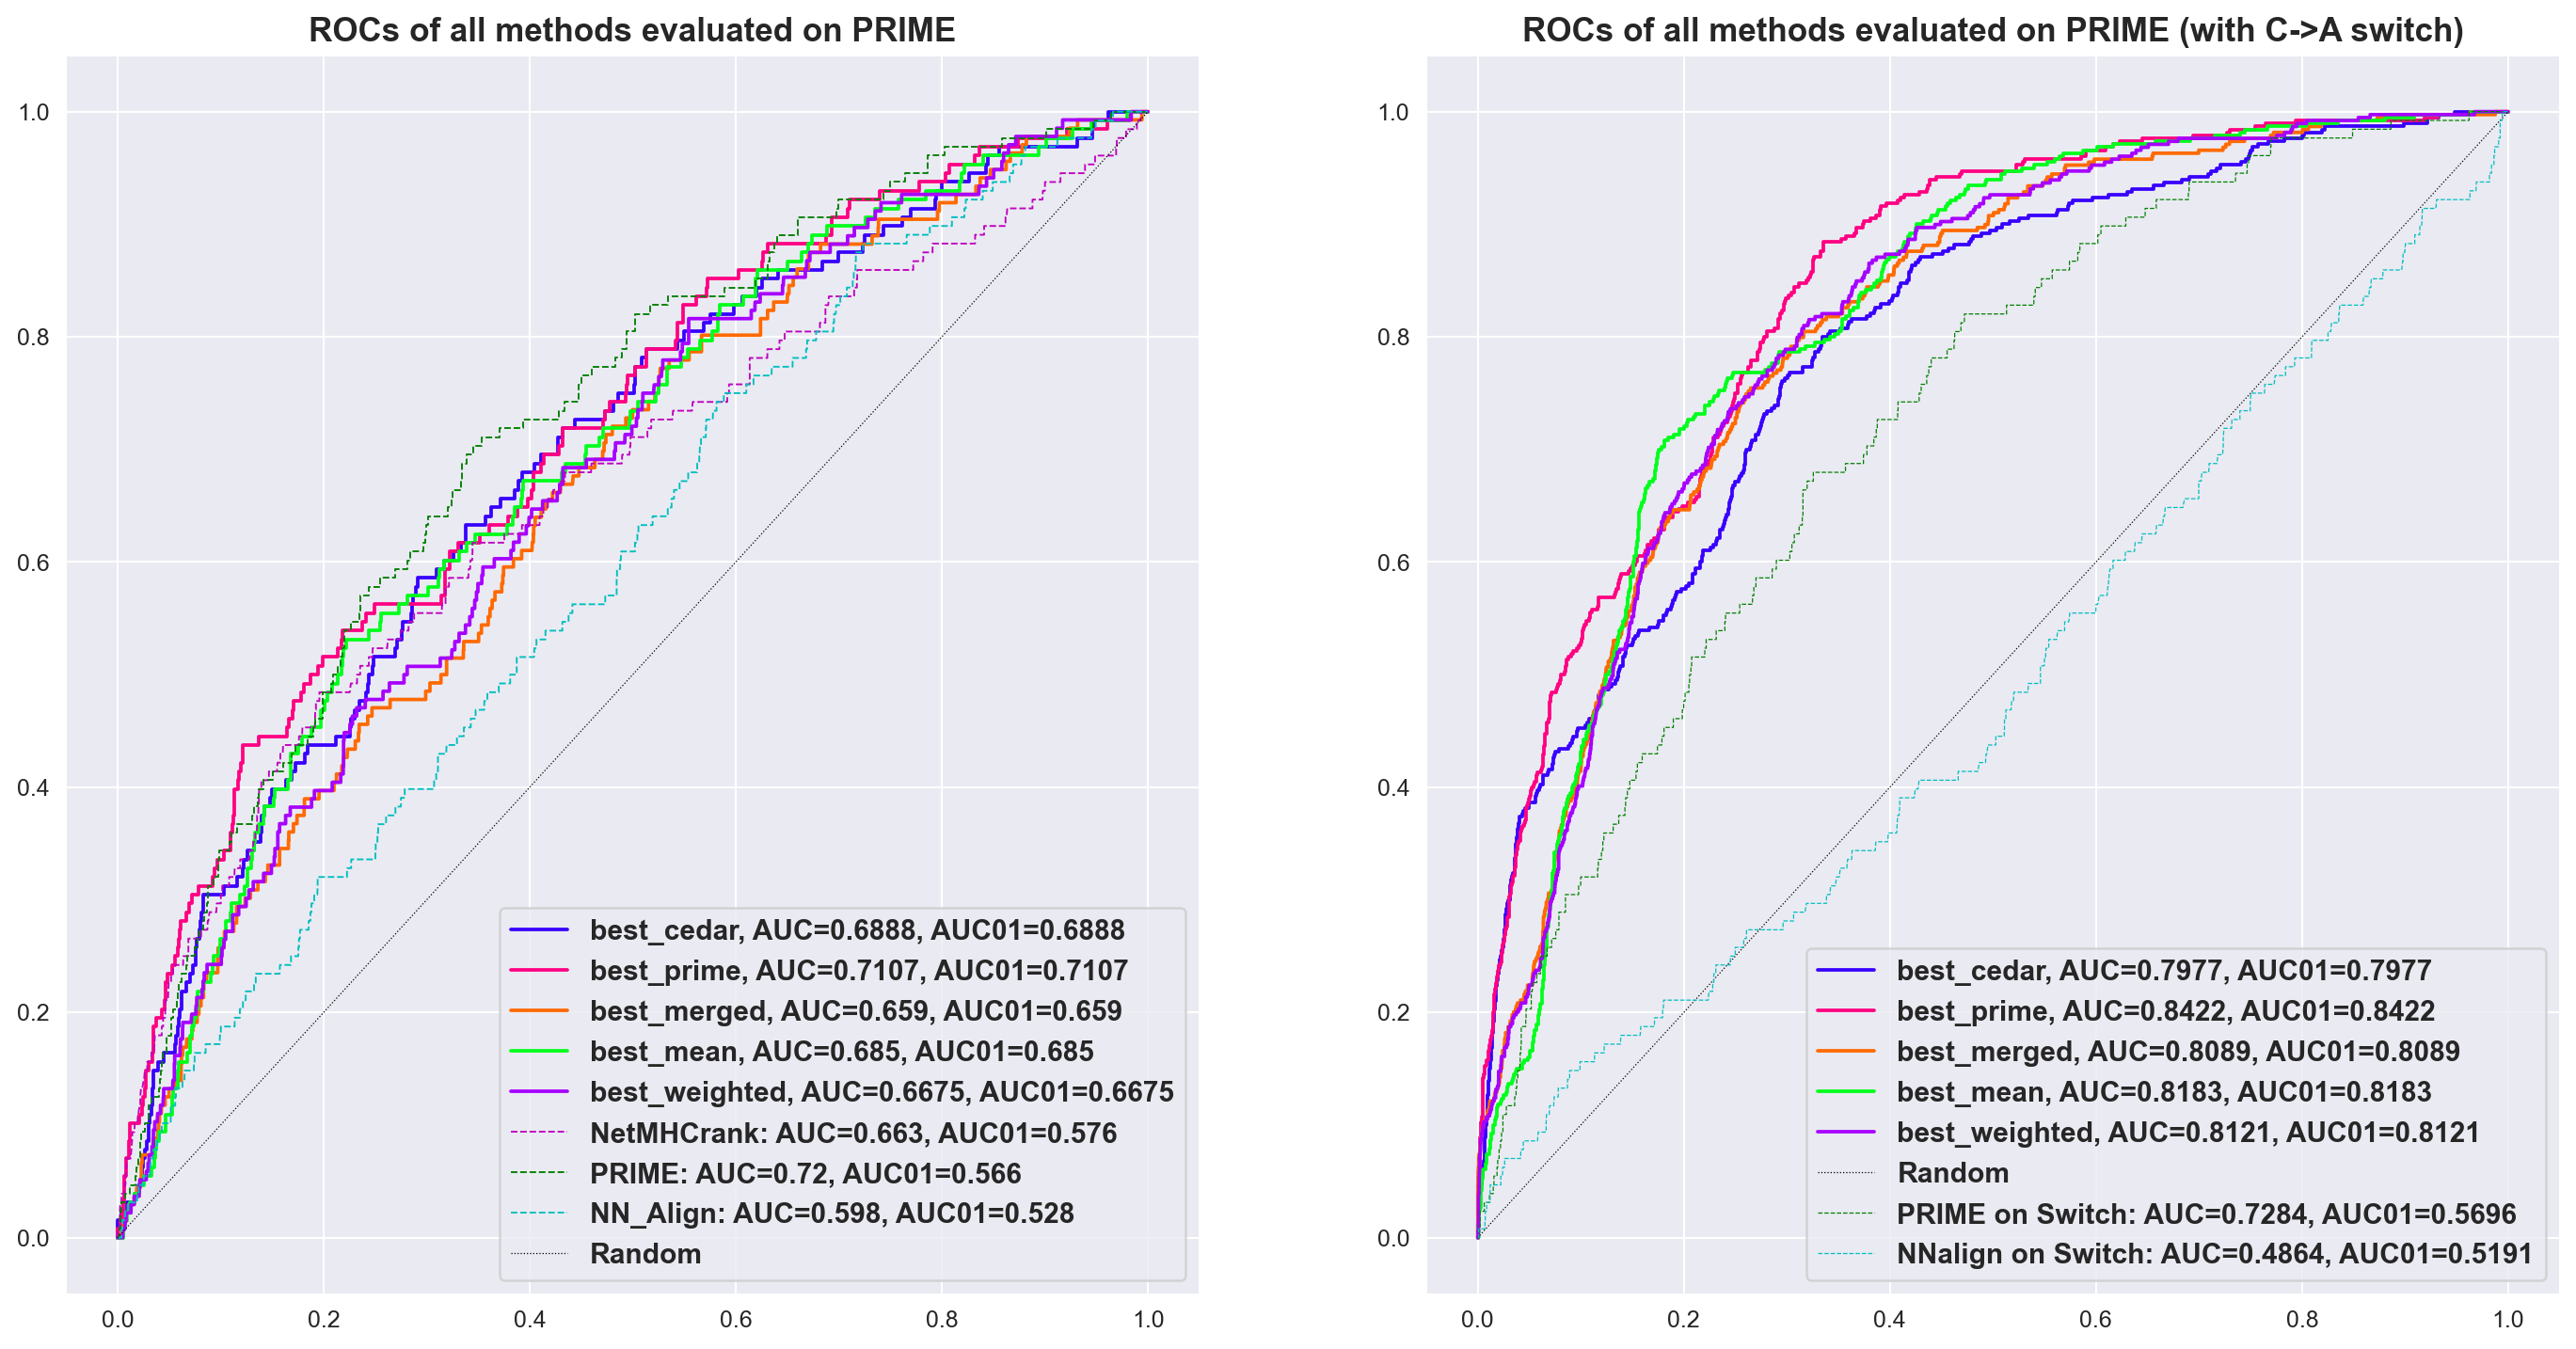

In [543]:
f,a = plt.subplots(1,2, figsize=(19,9.5))

for k,v in prime_all_results.items():
    tmp = v[0]
    sns.lineplot(x=tmp['roc_curve'][0], y=tmp['roc_curve'][1], label = f'{k}, AUC={round(tmp["auc"],4)}, AUC01={round(tmp["auc"],4)}',
                 estimator=None, ax=a[0])
plot_related_baseline_roc(a[0], prime_related, auc01=True)
a[0].set_title('ROCs of all methods evaluated on PRIME', fontweight='semibold', fontsize=14)
a[0].legend(loc='lower right', prop={'size':12, 'weight':'semibold'})
for k,v in prime_replaced_all_results.items():
    tmp = v[0]
    sns.lineplot(x=tmp['roc_curve'][0], y=tmp['roc_curve'][1], label = f'{k}, AUC={round(tmp["auc"],4)}, AUC01={round(tmp["auc"],4)}',
                 estimator=None, ax=a[1])
a[1].plot([0,1], [0,1], label='Random', ls=':', lw=0.5, c='k')
a[1].plot(switch_rocx, switch_rocy, label=f'PRIME on Switch: AUC={switch_auc}, AUC01={switch_auc01}',
          ls='--', lw=0.5, c='g')

a[1].plot(switch_nn_rocx, switch_nn_rocy, label=f'NNalign on Switch: AUC={switch_nn_auc}, AUC01={switch_nn_auc01}',
          ls='--', lw=0.5, c='c')
a[1].legend(prop={'size':12, 'weight':'semibold'}, loc='lower right')
a[1].set_title('ROCs of all methods evaluated on PRIME (with C->A switch)', fontweight='semibold', fontsize=14)

# Checking disagreement between top CEDAR / PRIME / MERGED models

check predictions for each set, false positives and negatives
What threshold ? 

## initial checks

In [91]:
def get_fp_fn(df, score='pred', target='agg_label'):
    score = 'pred' if 'pred' in df.columns else 'mean_pred' if 'mean_pred' in df.columns else score
    df['fp'] = df.apply(lambda x: (x[score]>.5 and x[target]==0), axis=1)
    df['fn'] = df.apply(lambda x: (x[score]<=.5 and x[target]==1), axis=1)
    return df

In [95]:
# Reload just in case
dir_raw = '../output/221112_new_core_mutscores_mergedtrainset/raw/'

# Best cedar cdt
best_cedar_cdt_cedar_preds = get_fp_fn(pd.read_csv(f'{dir_raw}cedar_preds_{best_cedar_cdt}.csv'))
best_cedar_cdt_prime_preds = get_fp_fn(pd.read_csv(f'{dir_raw}prime_preds_{best_cedar_cdt}.csv'))
# best_cedar_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_cedar_cdt}.csv') 

# best prime cdt
best_prime_cdt_cedar_preds = get_fp_fn(pd.read_csv(f'{dir_raw}cedar_preds_{best_prime_cdt}.csv'))
best_prime_cdt_prime_preds = get_fp_fn(pd.read_csv(f'{dir_raw}prime_preds_{best_prime_cdt}.csv'))
# best_prime_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_prime_cdt}.csv') 

# # Best MERGED cdt
# best_merged_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_merged_cdt}.csv') 
# best_merged_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_merged_cdt}.csv') 
# best_merged_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_merged_cdt}.csv') 

<AxesSubplot:ylabel='Frequency'>

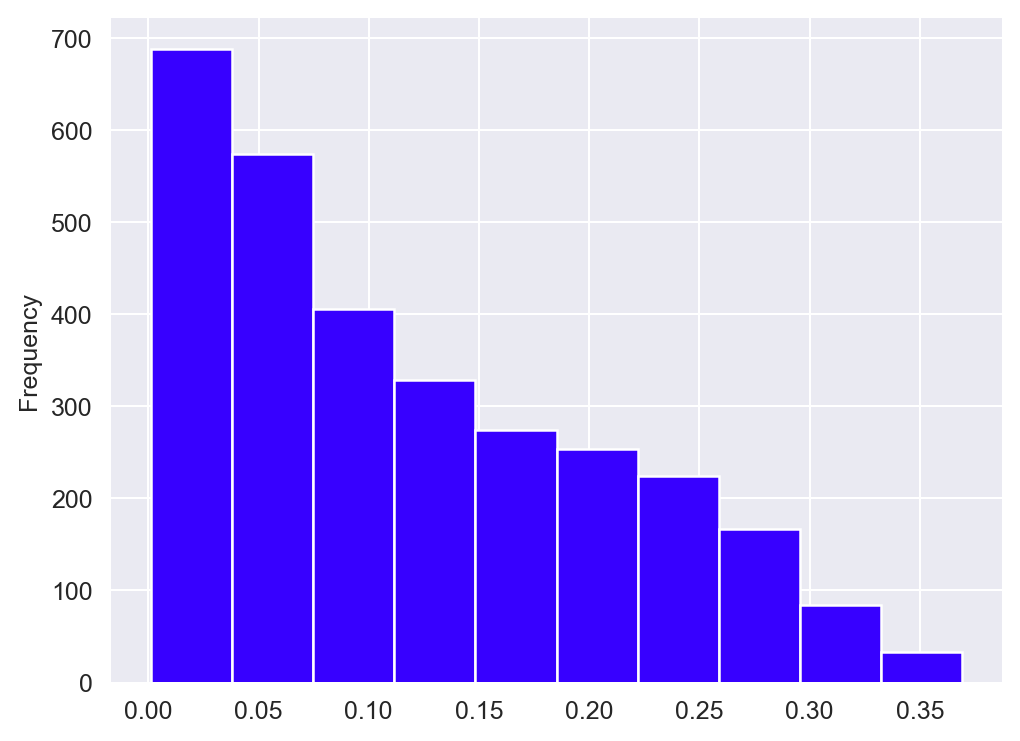

In [ ]:
cedar_related_baseline.PRIME_score.plot(kind='hist')

In [ ]:
best_cedar_cdt_cedar_preds.pred.describe()

count    3033.000000
mean        0.122798
std         0.071014
min         0.027270
25%         0.072385
50%         0.103016
75%         0.153595
max         0.522047
Name: pred, dtype: float64

In [ ]:
prime_related_baseline.PRIME_score.describe()

count    3109.000000
mean        0.107891
std         0.084132
min         0.000287
25%         0.037986
50%         0.082493
75%         0.163341
max         0.380764
Name: PRIME_score, dtype: float64

## merging scores

In [224]:
from src.data_processing import get_aa_properties
_, aacols = get_aa_properties(cedar_baseline)
cols_ = ['Peptide', 'HLA', 'agg_label', 'EL_rank_mut', 'EL_rank_wt',
          'anchor_mutation', 'binder', 'core_mut', 'core_wt', 'icore_mut', 'icore_wt', 'len']
feat_cols = aacols + list(filter(lambda x: 'score' in x.lower(), cedar_related.columns))
mrg_cols = ['Peptide','HLA']
pred_cols = ['pred_bestCedar', 'pred_bestPrime', 'PRIME_score', 'nnalign_score']

In [229]:
pd.set_option('display.max_rows', 10)
prime_related_baseline['pred']=0
merged_preds_prime = prime_related[cols_+feat_cols].merge(prime_related_baseline[['Peptide', 'HLA', 'PRIME_score', 'nnalign_score', 'pred']])\
                                                     .merge(best_cedar_cdt_prime_preds.rename(columns={'mean_pred':'pred'})[['Peptide', 'HLA', 'pred']],
                                                            left_on = mrg_cols, right_on = mrg_cols,
                                                            suffixes=['', '_bestCedar'])\
                                                     .merge(best_prime_cdt_prime_preds.rename(columns={'mean_pred':'pred'})[['Peptide', 'HLA', 'pred']],
                                                            left_on = mrg_cols, right_on = mrg_cols,
                                                            suffixes=['', '_bestPrime']).drop(columns=['pred'])
cedar_related_baseline['pred']=0
merged_preds_cedar = cedar_related[cols_+feat_cols].merge(cedar_related_baseline[['Peptide', 'HLA', 'PRIME_score', 'nnalign_score', 'pred']],
                                                            left_on = mrg_cols, right_on = mrg_cols)\
                                                     .merge(best_cedar_cdt_cedar_preds[['Peptide', 'HLA', 'pred']],
                                                            left_on = mrg_cols, right_on = mrg_cols,
                                                            suffixes=['', '_bestCedar'])\
                                                     .merge(best_prime_cdt_cedar_preds[['Peptide', 'HLA', 'pred']],
                                                            left_on = mrg_cols, right_on = mrg_cols,
                                                            suffixes=['', '_bestPrime']).drop(columns=['pred'])

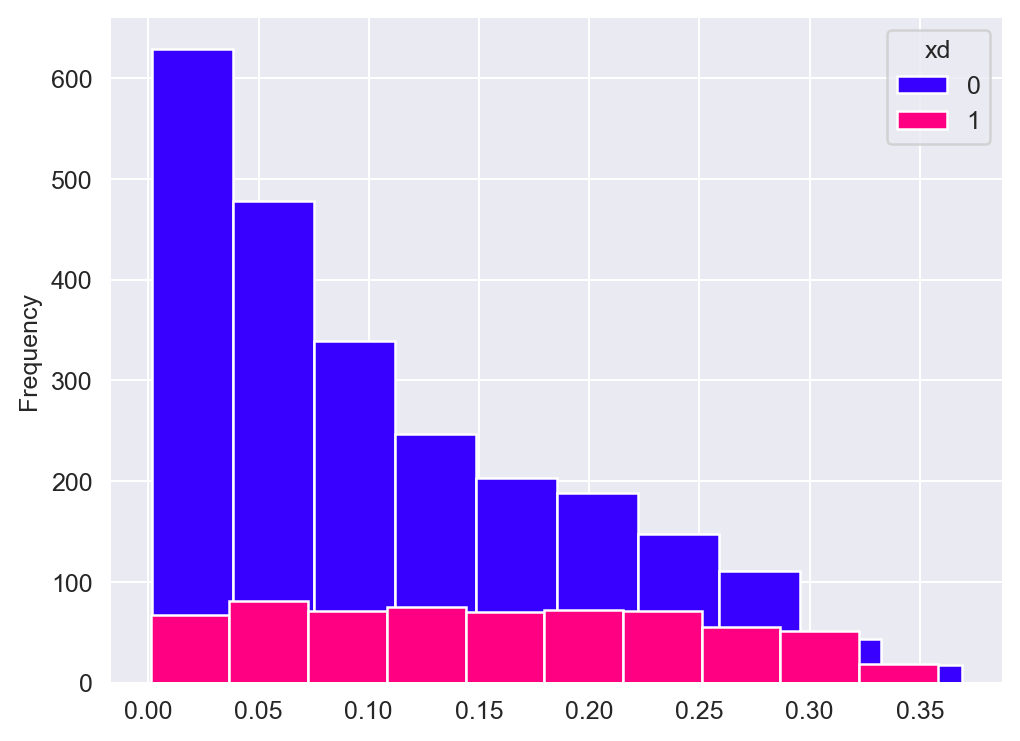

In [239]:
merged_preds_cedar.groupby('agg_label')['PRIME_score'].plot(kind='hist')
plt.legend(title='xd')

## Groupby plots of scores 

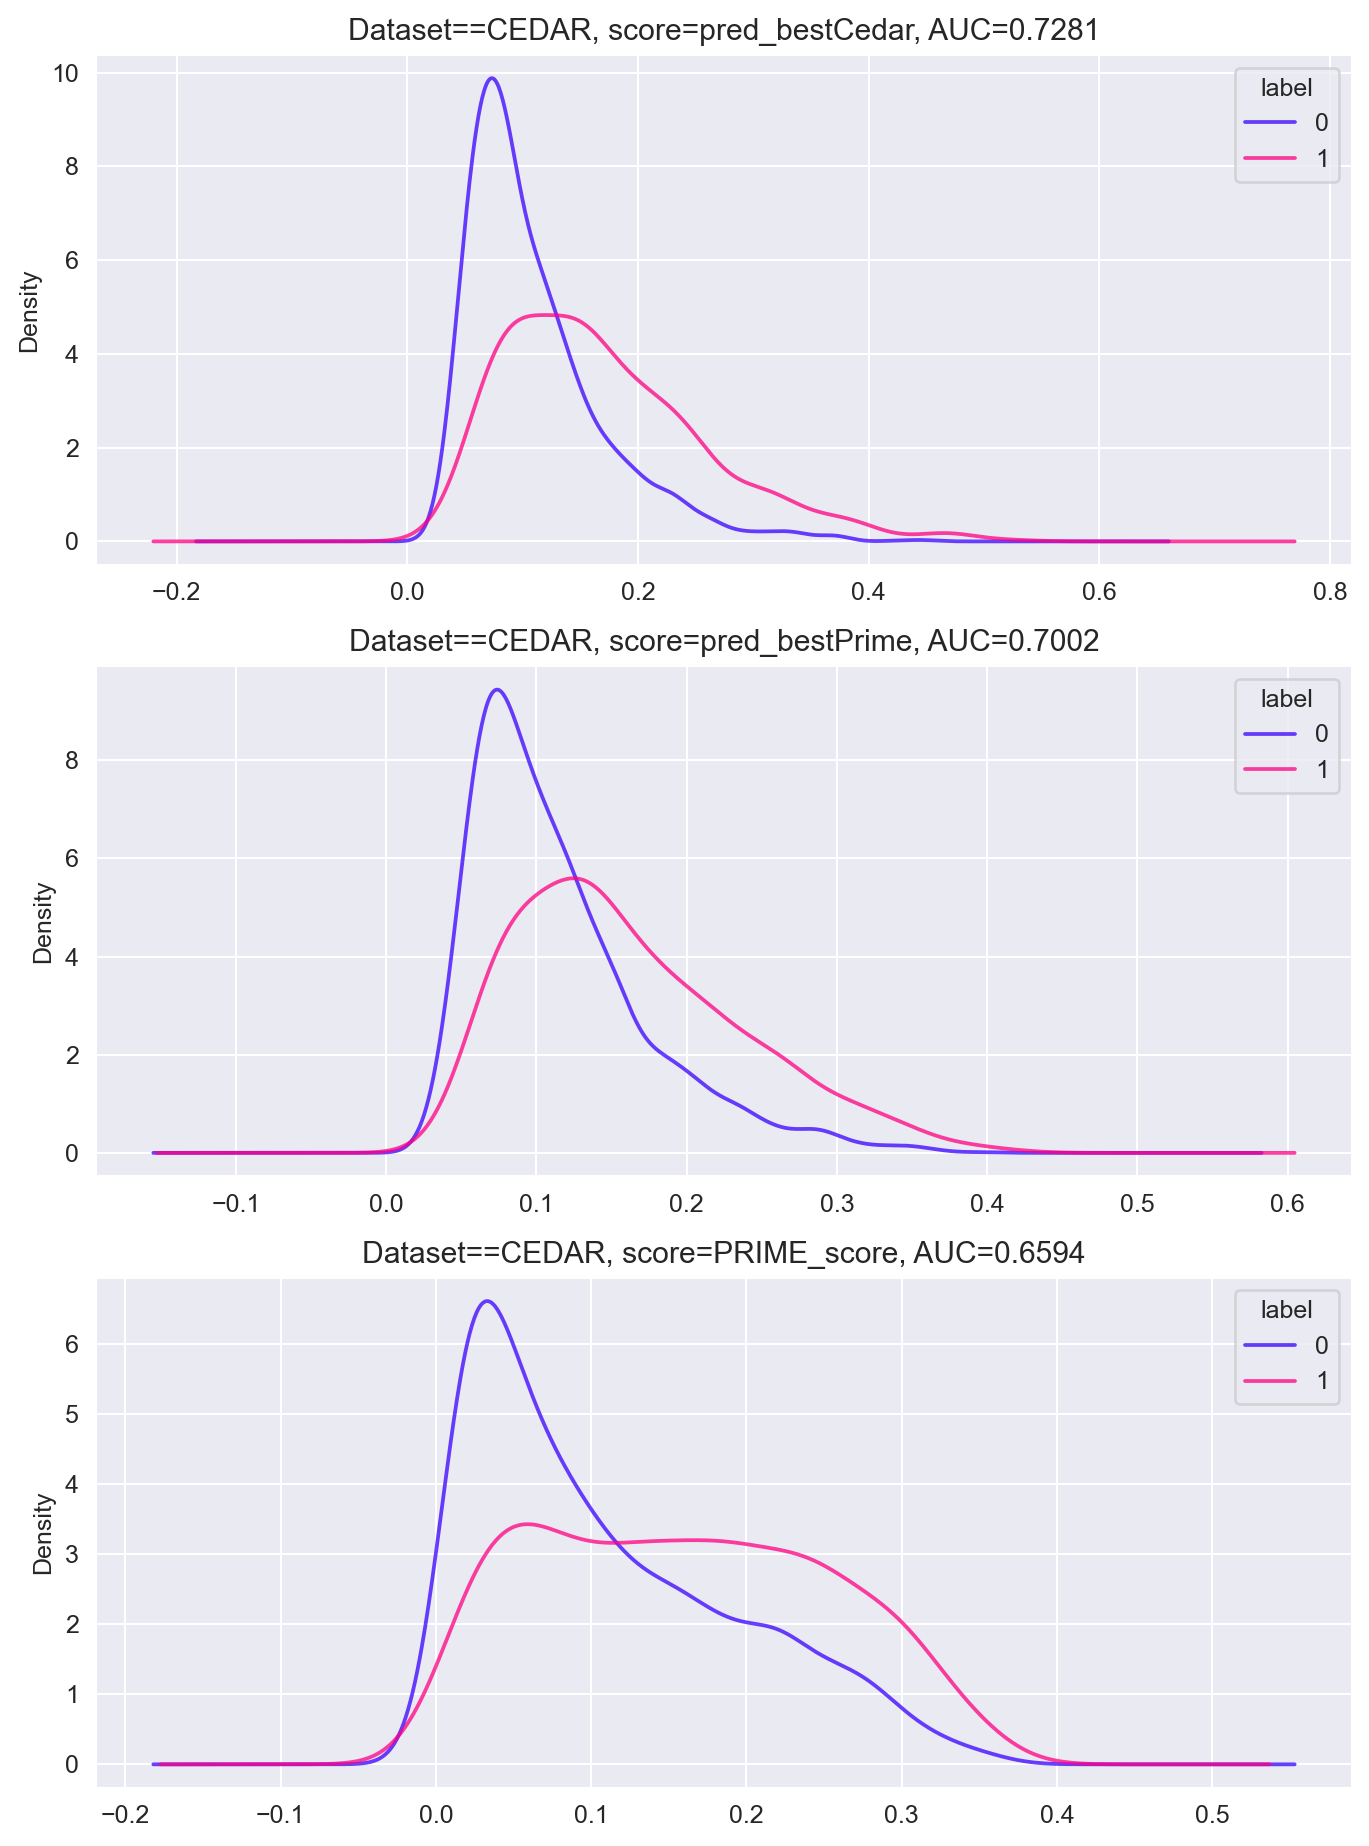

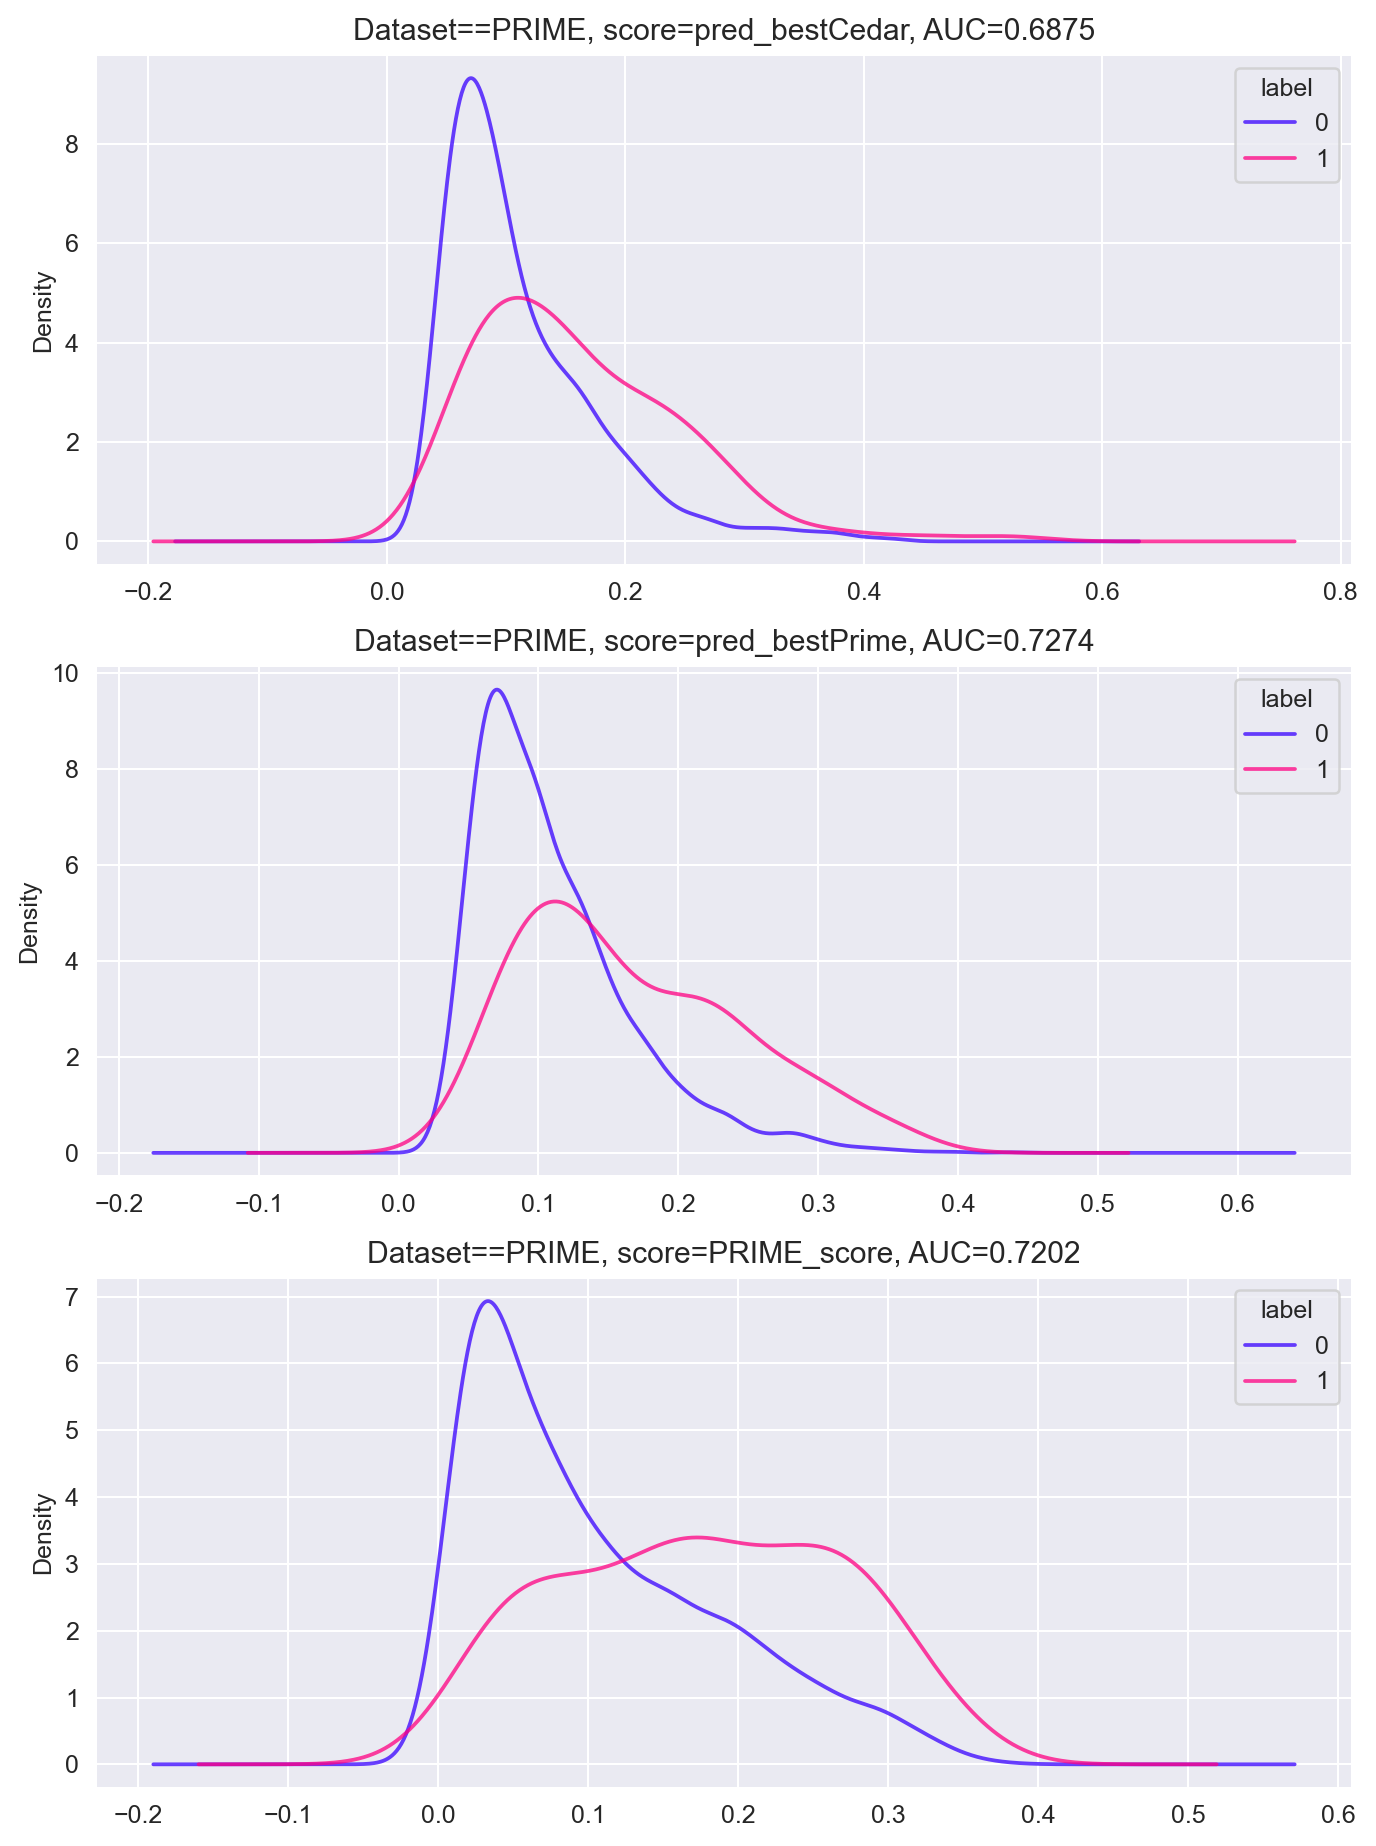

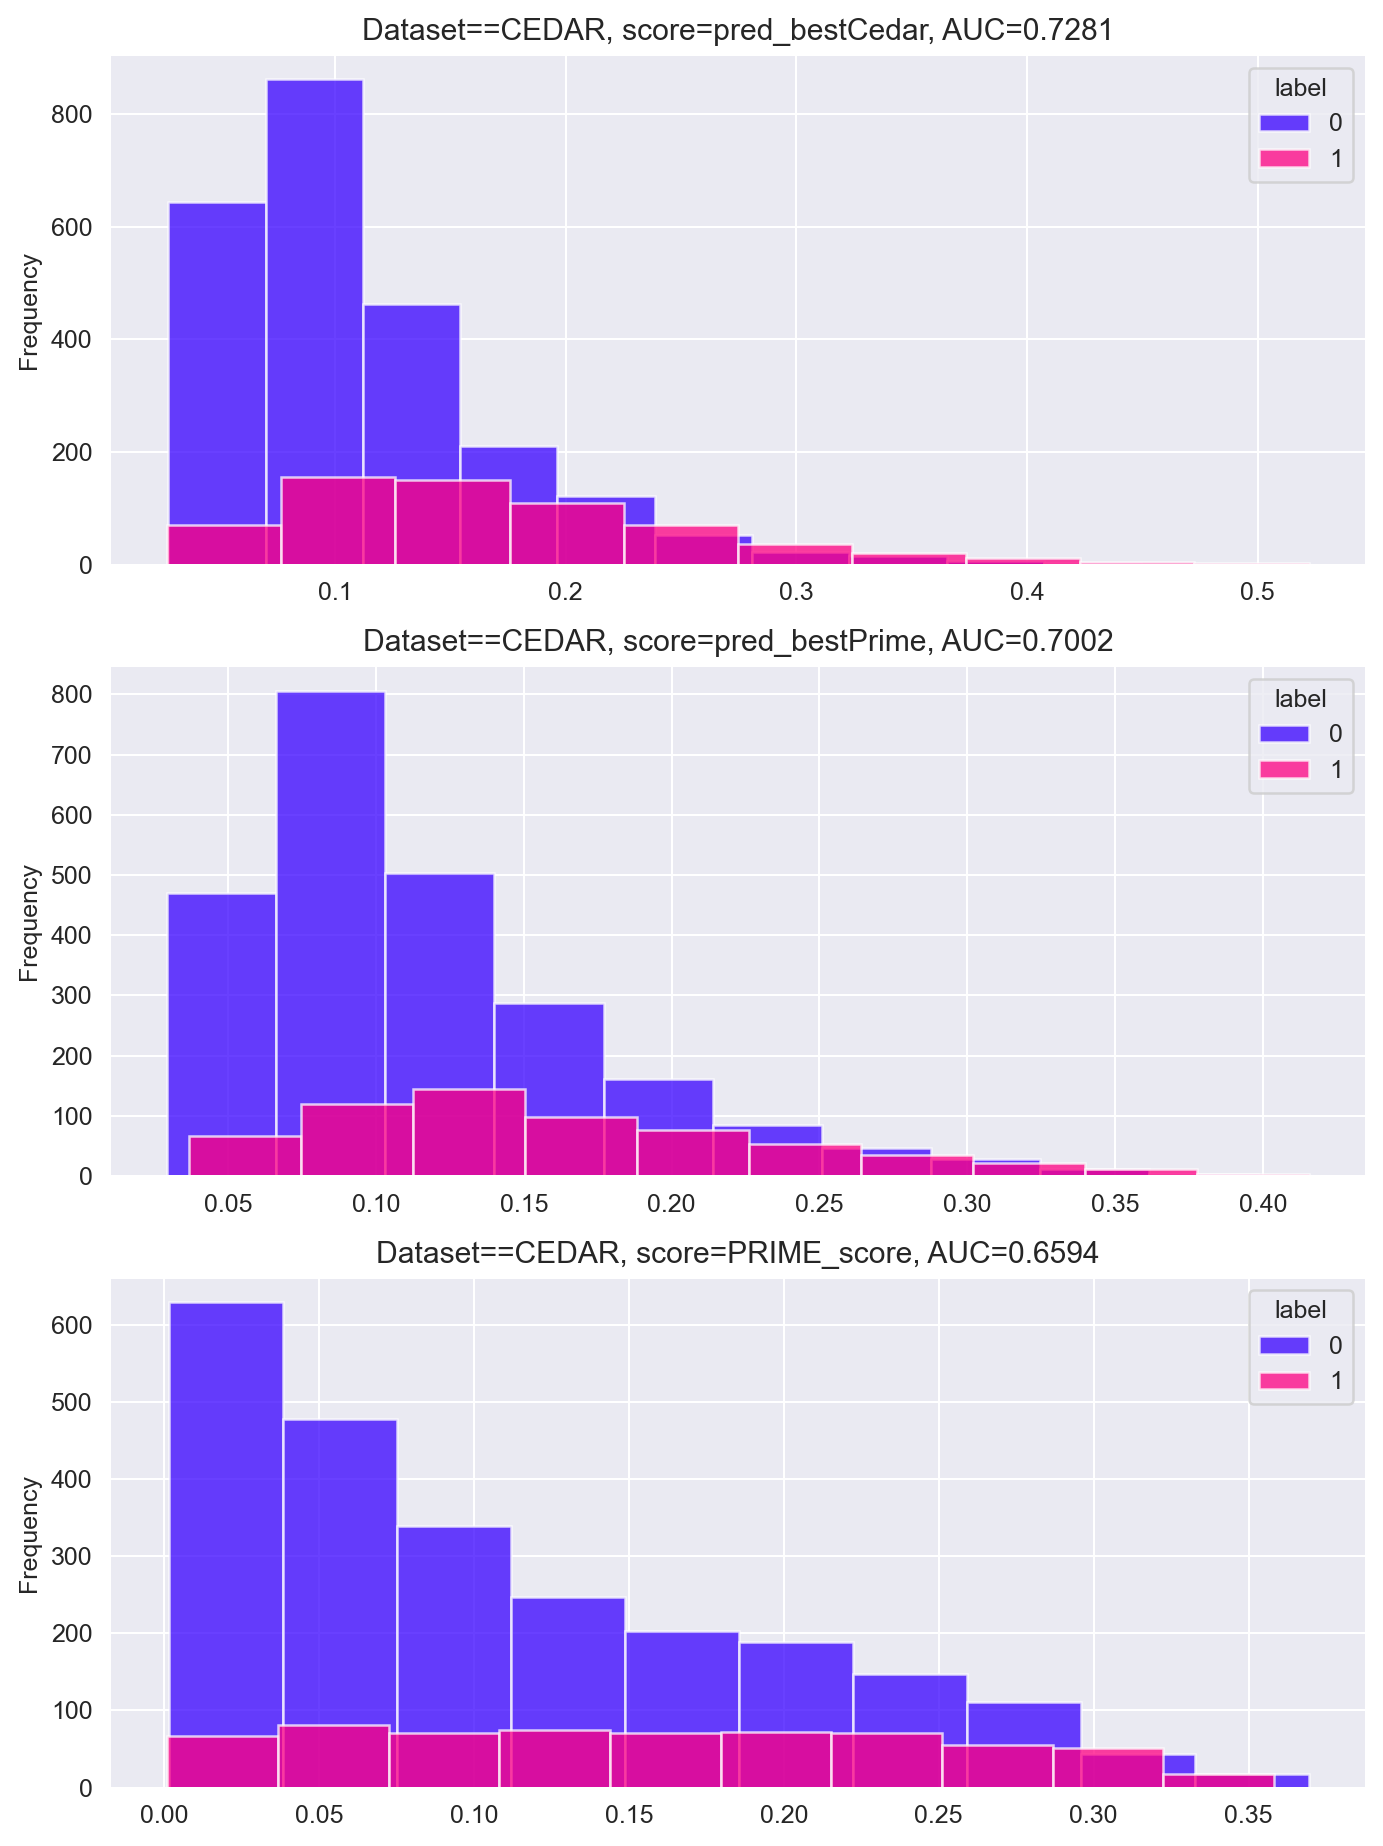

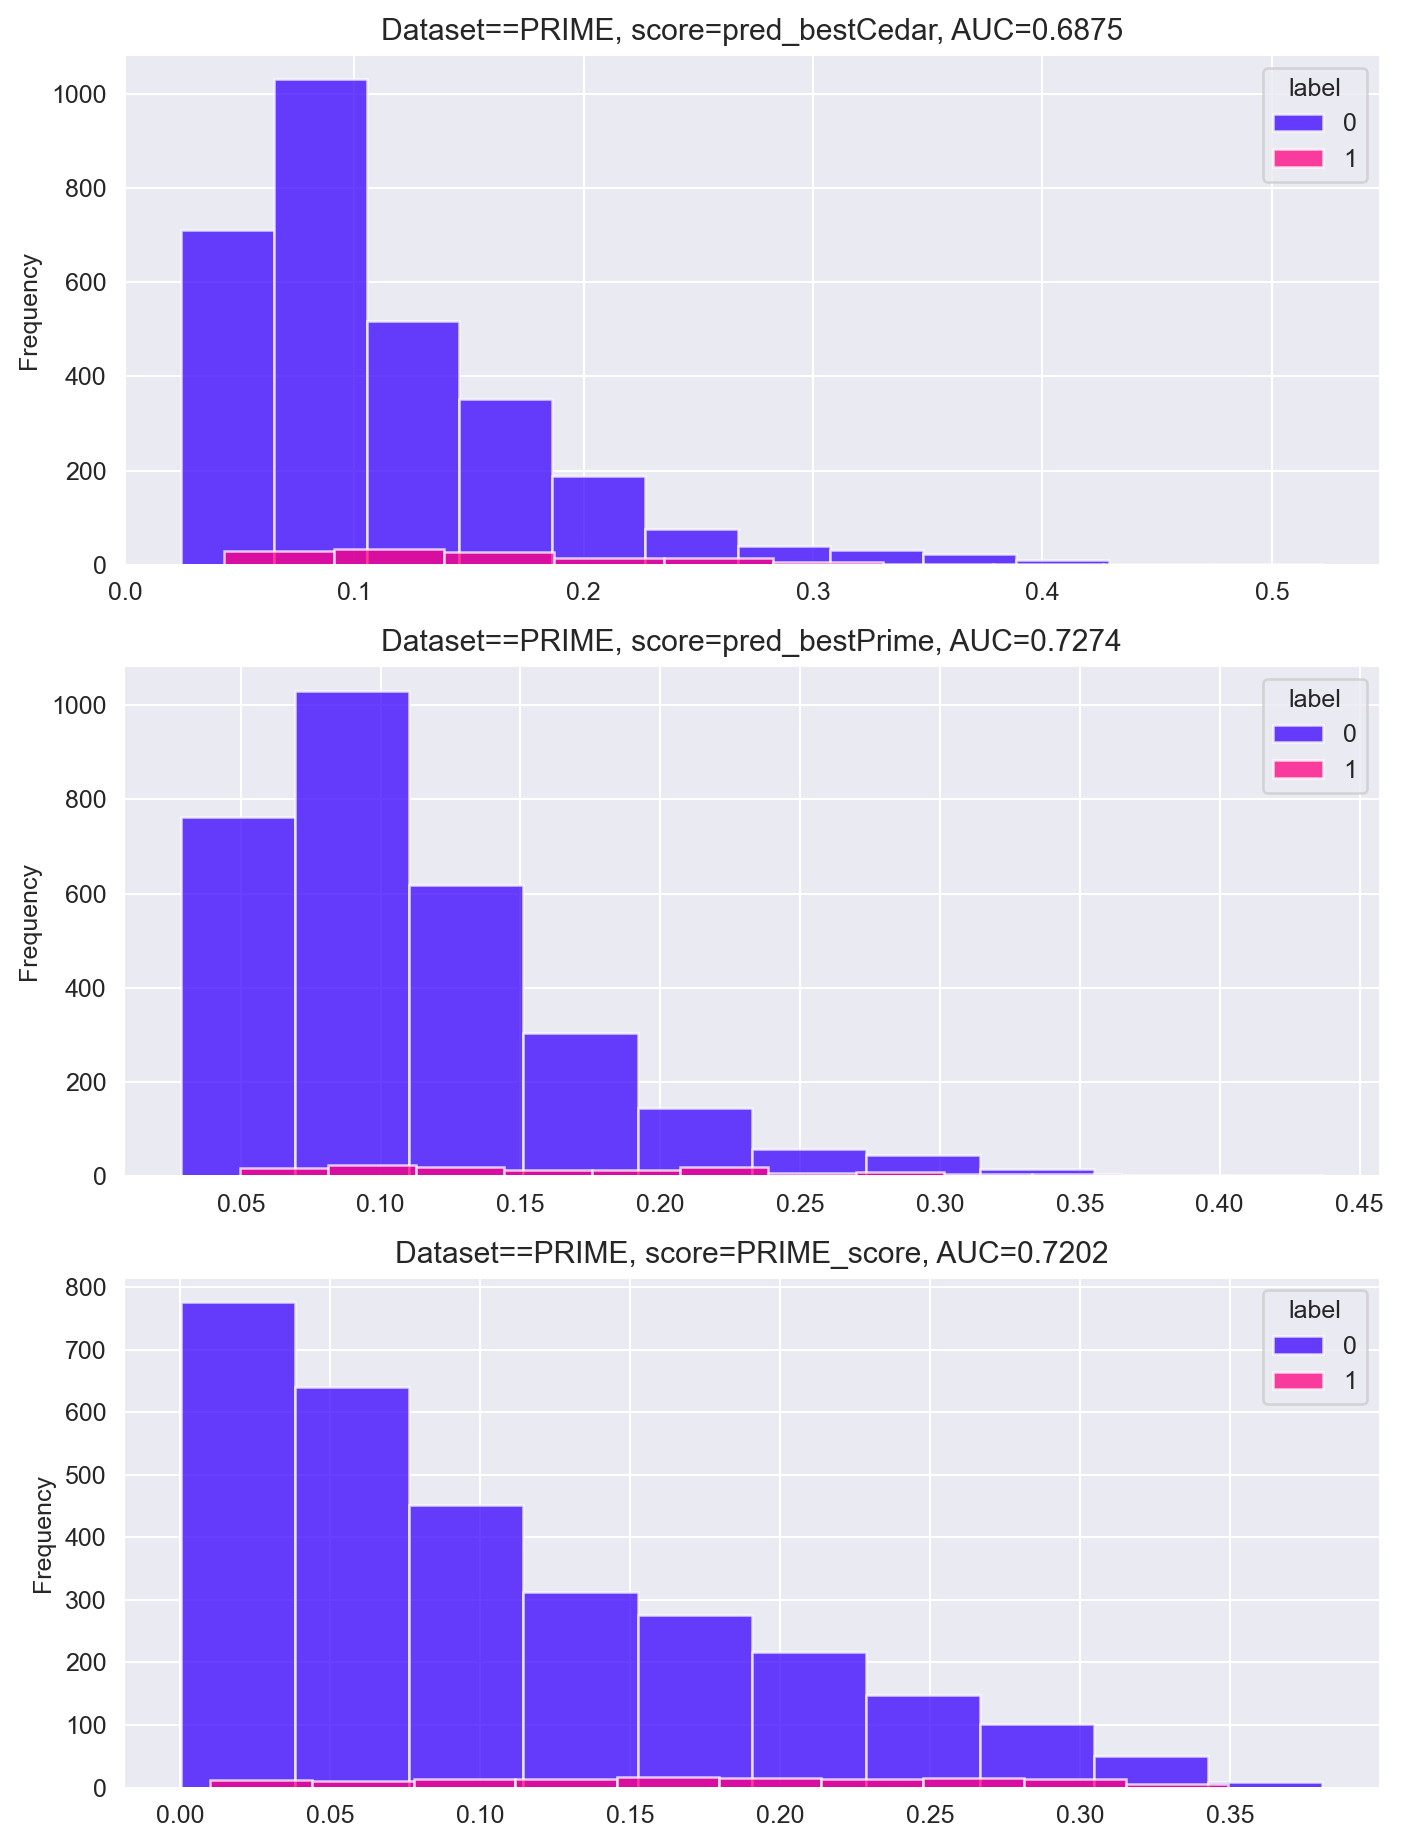

In [259]:
# KDE
f_cedar, a_cedar = plt.subplots(3,1, figsize=(9, 12.5))
f_prime, a_prime = plt.subplots(3,1, figsize=(9, 12.5))

for i, score in enumerate(['pred_bestCedar', 'pred_bestPrime', 'PRIME_score']):
    merged_preds_cedar.groupby('agg_label')[score].plot(kind='kde', ax=a_cedar[i], alpha=0.75)
    auc_cedar = round(get_roc(merged_preds_cedar, score)['auc'],4)
    a_cedar[i].legend(title='label')
    a_cedar[i].set_title(f'Dataset==CEDAR, score={score}, AUC={auc_cedar}')
    # plt.setp(a_cedar[i].collections, alpha=0.75)
    merged_preds_prime.groupby('agg_label')[score].plot(kind='kde', ax=a_prime[i], alpha=0.75)
    auc_prime = round(get_roc(merged_preds_prime, score)['auc'],4)
    a_prime[i].legend(title='label')
    a_prime[i].set_title(f'Dataset==PRIME, score={score}, AUC={auc_prime}')
    # plt.setp(a_prime[i].collections, alpha=0.75)
f_cedar.savefig('../../../meetings/slides/22112X_mutscore_cont/figs/CEDAR_scores_kde.png', 
                dpi=200, bbox_inches='tight', pad_inches=0.15)

f_prime.savefig('../../../meetings/slides/22112X_mutscore_cont/figs/PRIME_scores_kde.png', 
                dpi=200, bbox_inches='tight', pad_inches=0.15)
# HIST
f_cedar,a_cedar = plt.subplots(3,1, figsize=(9, 12.5))
f_prime,a_prime = plt.subplots(3,1, figsize=(9, 12.5))

for i, score in enumerate(['pred_bestCedar', 'pred_bestPrime', 'PRIME_score']):
    merged_preds_cedar.groupby('agg_label')[score].plot(kind='hist', ax=a_cedar[i], alpha=0.75)
    auc_cedar = round(get_roc(merged_preds_cedar, score)['auc'],4)
    a_cedar[i].legend(title='label')
    a_cedar[i].set_title(f'Dataset==CEDAR, score={score}, AUC={auc_cedar}')
    # plt.setp(a_cedar[i].collections, alpha=0.75)
    merged_preds_prime.groupby('agg_label')[score].plot(kind='hist', ax=a_prime[i], alpha=0.75)
    auc_prime = round(get_roc(merged_preds_prime, score)['auc'],4)
    a_prime[i].legend(title='label')
    a_prime[i].set_title(f'Dataset==PRIME, score={score}, AUC={auc_prime}')
    

f_cedar.savefig('../../../meetings/slides/22112X_mutscore_cont/figs/CEDAR_scores_hist.png', 
                dpi=200, bbox_inches='tight', pad_inches=0.15)

f_prime.savefig('../../../meetings/slides/22112X_mutscore_cont/figs/PRIME_scores_hist.png', 
                dpi=200, bbox_inches='tight', pad_inches=0.15)

## Top 5% of given label with "opposite score"

In [387]:
pd.set_option('display.max_rows', 20)
simple_cols = mrg_cols+['agg_label']+pred_cols
# Label == 0, looking at highest scores (False positives)
top = 10 # top 5%

top_cedar = int( 0.01*top *len(merged_preds_cedar))
top_prime = int( 0.01*top *len(merged_preds_cedar))

fp_cedar_bc = merged_preds_cedar.query('agg_label==0').sort_values('pred_bestCedar', ascending=False).head(top_cedar)
fp_cedar_bp = merged_preds_cedar.query('agg_label==0').sort_values('pred_bestPrime', ascending=False).head(top_cedar)
fp_cedar_prime = merged_preds_cedar.query('agg_label==0').sort_values('PRIME_score', ascending=False).head(top_cedar)

# Label == 1, looking at lowest scores (False negatives) and also highest scores (most confident predictions)

fn_cedar_bc = merged_preds_cedar.query('agg_label==1').sort_values('pred_bestCedar', ascending=True).head(top_cedar)
fn_cedar_bp = merged_preds_cedar.query('agg_label==1').sort_values('pred_bestPrime', ascending=True).head(top_cedar)
fn_cedar_prime = merged_preds_cedar.query('agg_label==1').sort_values('PRIME_score', ascending=True).head(top_cedar)

tp_cedar_bc = merged_preds_cedar.query('agg_label==1').sort_values('pred_bestCedar', ascending=False).head(top_cedar)
tp_cedar_bp = merged_preds_cedar.query('agg_label==1').sort_values('pred_bestPrime', ascending=False).head(top_cedar)
tp_cedar_prime = merged_preds_cedar.query('agg_label==1').sort_values('PRIME_score', ascending=False).head(top_cedar)


In [512]:
fn_cedar_bc_only = fn_cedar_bc.query('Peptide not in @fn_cedar_bp.Peptide.values or Peptide not in @fn_cedar_prime.Peptide.values')
fn_cedar_bp_only = fn_cedar_bp.query('Peptide not in @fn_cedar_bc.Peptide.values or Peptide not in @fn_cedar_prime.Peptide.values')
fn_cedar_prime_only = fn_cedar_prime.query('Peptide not in @fn_cedar_bp.Peptide.values or Peptide not in @fn_cedar_bc.Peptide.values')

tp_cedar_bc_only = tp_cedar_bc.query('Peptide not in @tp_cedar_bp.Peptide.values or Peptide not in @tp_cedar_prime.Peptide.values')
tp_cedar_bp_only = tp_cedar_bp.query('Peptide not in @tp_cedar_bc.Peptide.values or Peptide not in @tp_cedar_prime.Peptide.values')
tp_cedar_prime_only = tp_cedar_prime.query('Peptide not in @tp_cedar_bp.Peptide.values or Peptide not in @tp_cedar_bc.Peptide.values')
tp_cedar_common = tp_cedar_bc.query('Peptide in @tp_cedar_bp.Peptide.values or Peptide in @tp_cedar_prime.Peptide.values')

In [577]:
cedar_related.groupby(['binder', 'anchor_mutation']).agg(count=('Peptide', 'count'))

count
binder    anchor_mutation       
Conserved False             1829
          True               676
Improved  False              107
          True               421

In [581]:
prime_replaced_AC.columns

Index(['Peptide', 'HLA', 'trueHLA_EL_rank', 'agg_label', 'core', 'len',
       'wild_type', 'wt_EL_rank', 'mutation_type', 'mutation_position',
       'anchor_mutation', 'mhc_anchor', 'wt_core', 'ratio_rank',
       'core_mutation_position', 'binder', 'nnalign_score', 'MixMHCrank',
       'PRIME_score', 'MixMHCallele', 'StudyOrigin', 'Pos_mut', 'Peptide_mut',
       'core_mut', 'icore_mut', 'EL_rank_mut', 'Pos_wt', 'Peptide_wt',
       'core_wt', 'icore_wt', 'EL_rank_wt', 'mutation_score', 'blsm_mut_score',
       'core_mutation_score', 'core_blsm_mut_score', 'mut_wt_sim',
       'dissimilarity_score', 'aliphatic_index', 'boman', 'hydrophobicity',
       'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'seq_id'],
      dtype='object')

In [586]:
prime_replaced_AC.to_csv('../data/mutant/221122_prime_AC_switch.csv', index=False, header=True)

In [571]:
tp_cedar_bp_only.groupby(['binder', 'anchor_mutation']).agg(count=('Peptide', 'count'))

count
binder    anchor_mutation       
Conserved False               78
          True                20
Improved  False                4
          True                29

In [570]:
tp_cedar_bc_only.groupby(['binder', 'anchor_mutation']).agg(count=('Peptide', 'count'))

count
binder    anchor_mutation       
Conserved False               96
          True                16
Improved  False                6
          True                14

In [572]:
tp_cedar_prime_only.groupby(['binder', 'anchor_mutation']).agg(count=('Peptide', 'count'))

count
binder    anchor_mutation       
Conserved False               86
          True                18
Improved  False                5
          True                19

In [576]:
fp_cedar_prime_only.groupby(['binder', 'anchor_mutation']).agg(count=('Peptide', 'count'))

count
binder    anchor_mutation       
Conserved False               58
          True                15
Improved  False                4
          True                13

### make some "fake datasets" with randompeps for nnalign

In [456]:
randompeps9 = pd.read_csv('../../randompeps/randompeps_9mer_1000000.pep', header=None).sample(1500, random_state=13).rename(columns={0:'Peptide'}).assign(agg_label=0)
randompeps10 = pd.read_csv('../../randompeps/randompeps_10mer_1000000.pep', header=None).sample(500, random_state=13).rename(columns={0:'Peptide'}).assign(agg_label=0)
randompeps11 = pd.read_csv('../../randompeps/randompeps_11mer_1000000.pep', header=None).sample(200, random_state=13).rename(columns={0:'Peptide'}).assign(agg_label=0)

### Save TPs

In [462]:
tp_cedar_bp_only_save = tp_cedar_bp_only[['Peptide', 'agg_label']].copy()
for df, (i, row) in zip([randompeps9, randompeps10, randompeps11],
                        tp_cedar_bp_only.groupby('len').agg(count=('Peptide','count')).iterrows()):
    print(i, row['count'])
    tp_cedar_bp_only_save = tp_cedar_bp_only_save.append(df.sample(n=int(3*row['count']), random_state=13))
tp_cedar_bp_only_save.to_csv('../../nnalign_cedar/predictions_analysis/data_pa/tp_cedar_bp_only.txt', 
                             index=False, header=False, sep='\t')

9 87
10 28
11 16


In [463]:
tp_cedar_prime_only_save = tp_cedar_prime_only[['Peptide', 'agg_label']].copy()
for df, (i, row) in zip([randompeps9, randompeps10, randompeps11],
                        tp_cedar_prime_only.groupby('len').agg(count=('Peptide','count')).iterrows()):
    print(i, row['count'])
    tp_cedar_prime_only_save = tp_cedar_prime_only_save.append(df.sample(n=int(3*row['count']), random_state=13))
tp_cedar_prime_only_save.to_csv('../../nnalign_cedar/predictions_analysis/data_pa/tp_cedar_prime_only.txt', 
                             index=False, header=False, sep='\t')

9 117
10 10
11 1


In [464]:
tp_cedar_bc_only_save = tp_cedar_bc_only[['Peptide', 'agg_label']].copy()
for df, (i, row) in zip([randompeps9, randompeps10, randompeps11],
                        tp_cedar_bc_only.groupby('len').agg(count=('Peptide','count')).iterrows()):
    print(i, row['count'])
    tp_cedar_bc_only_save = tp_cedar_bc_only_save.append(df.sample(n=int(3*row['count']), random_state=13))
tp_cedar_bc_only_save.to_csv('../../nnalign_cedar/predictions_analysis/data_pa/tp_cedar_bc_only.txt', 
                             index=False, header=False, sep='\t')

9 75
10 44
11 13


### Save FNs

In [513]:
fn_cedar_bp_only_save = fn_cedar_bp_only[['Peptide', 'agg_label']].copy()
for df, (i, row) in zip([randompeps9, randompeps10, randompeps11],
                        fn_cedar_bp_only.groupby('len').agg(count=('Peptide','count')).iterrows()):
    print(i, row['count'])
    fn_cedar_bp_only_save = fn_cedar_bp_only_save.append(df.sample(n=int(3*row['count']), random_state=13))
fn_cedar_bp_only_save.to_csv('../../nnalign_cedar/predictions_analysis/data_pa/fn_cedar_bp_only.txt', 
                             index=False, header=False, sep='\t')

9 95
10 35
11 8


In [514]:
fn_cedar_prime_only_save = fn_cedar_prime_only[['Peptide', 'agg_label']].copy()
for df, (i, row) in zip([randompeps9, randompeps10, randompeps11],
                        fn_cedar_prime_only.groupby('len').agg(count=('Peptide','count')).iterrows()):
    print(i, row['count'])
    fn_cedar_prime_only_save = fn_cedar_prime_only_save.append(df.sample(n=int(3*row['count']), random_state=13))
fn_cedar_prime_only_save.to_csv('../../nnalign_cedar/predictions_analysis/data_pa/fn_cedar_prime_only.txt', 
                             index=False, header=False, sep='\t')

9 60
10 53
11 22


In [515]:
fn_cedar_bc_only_save = fn_cedar_bc_only[['Peptide', 'agg_label']].copy()
for df, (i, row) in zip([randompeps9, randompeps10, randompeps11],
                        fn_cedar_bc_only.groupby('len').agg(count=('Peptide','count')).iterrows()):
    print(i, row['count'])
    fn_cedar_bc_only_save = fn_cedar_bc_only_save.append(df.sample(n=int(3*row['count']), random_state=13))
fn_cedar_bc_only_save.to_csv('../../nnalign_cedar/predictions_analysis/data_pa/fn_cedar_bc_only.txt', 
                             index=False, header=False, sep='\t')

9 113
10 18
11 6


### Check quantiles and plots

In [391]:
# list(filter(lambda x: 'score' in x, feat_cols))
qtls = [.1, .25, .5, .75, .8, .9, .95]
print('CEDAR predicted by Prime top 10% True Positives')
display(tp_cedar_prime[pred_cols].describe(percentiles=qtls))

print('CEDAR predicted by BestCedar top 10% True Positives')
display(tp_cedar_bc[pred_cols].describe(percentiles=qtls))

CEDAR predicted by Prime top 10% True Positives


pred_bestCedar  pred_bestPrime  PRIME_score  nnalign_score
count      303.000000      303.000000   303.000000     303.000000
mean         0.202287        0.201962     0.242543       0.285283
std          0.092598        0.073812     0.050668       0.087582
min          0.043398        0.066624     0.162223       0.096690
10%          0.097886        0.116387     0.176890       0.178730
25%          0.135956        0.141211     0.197952       0.220405
50%          0.187157        0.193669     0.236651       0.277280
75%          0.246758        0.254898     0.282464       0.347590
80%          0.263451        0.265733     0.293300       0.355916
90%          0.325041        0.305551     0.312505       0.401844
95%          0.384749        0.338331     0.332944       0.436904
max          0.522047        0.415399     0.358210       0.534350

CEDAR predicted by BestCedar top 10% True Positives


pred_bestCedar  pred_bestPrime  PRIME_score  nnalign_score
count      303.000000      303.000000   303.000000     303.000000
mean         0.241500        0.207412     0.195784       0.271840
std          0.071969        0.072964     0.088743       0.094259
min          0.157519        0.056773     0.009906       0.071620
10%          0.167833        0.118125     0.067642       0.153034
25%          0.185973        0.151430     0.127550       0.197915
50%          0.223942        0.203375     0.203577       0.262600
75%          0.276271        0.260740     0.263452       0.335040
80%          0.299668        0.269274     0.278616       0.351976
90%          0.343606        0.308652     0.306844       0.399318
95%          0.384749        0.338331     0.332944       0.431888
max          0.522047        0.415399     0.358210       0.534350

In [549]:
tp_cedar_common[['agg_label', 'PRIME_score', 'nnalign_score', 'pred_bestCedar', 'pred_bestPrime']].describe()

agg_label  PRIME_score  nnalign_score  pred_bestCedar  pred_bestPrime
count      253.0   253.000000     253.000000      253.000000      253.000000
mean         1.0     0.218047       0.285127        0.249459        0.225948
std          0.0     0.078655       0.092812        0.074235        0.064426
min          1.0     0.009906       0.084790        0.157519        0.088342
25%          1.0     0.171920       0.216980        0.191767        0.174464
50%          1.0     0.225771       0.279940        0.231458        0.218685
75%          1.0     0.275916       0.348230        0.289967        0.267795
max          1.0     0.358210       0.534350        0.522047        0.415399

In [548]:
fp_cedar_common[['agg_label', 'PRIME_score', 'nnalign_score', 'pred_bestCedar', 'pred_bestPrime']].describe()

agg_label  PRIME_score  nnalign_score  pred_bestCedar  pred_bestPrime
count       88.0    88.000000      88.000000       88.000000       88.000000
mean         0.0     0.244009       0.270957        0.285993        0.268297
std          0.0     0.081979       0.080478        0.054372        0.049402
min          0.0     0.018685       0.080770        0.220848        0.137177
25%          0.0     0.219468       0.210805        0.241096        0.233528
50%          0.0     0.264988       0.273225        0.272339        0.262596
75%          0.0     0.294509       0.325045        0.326084        0.295343
max          0.0     0.369308       0.479970        0.449492        0.398289

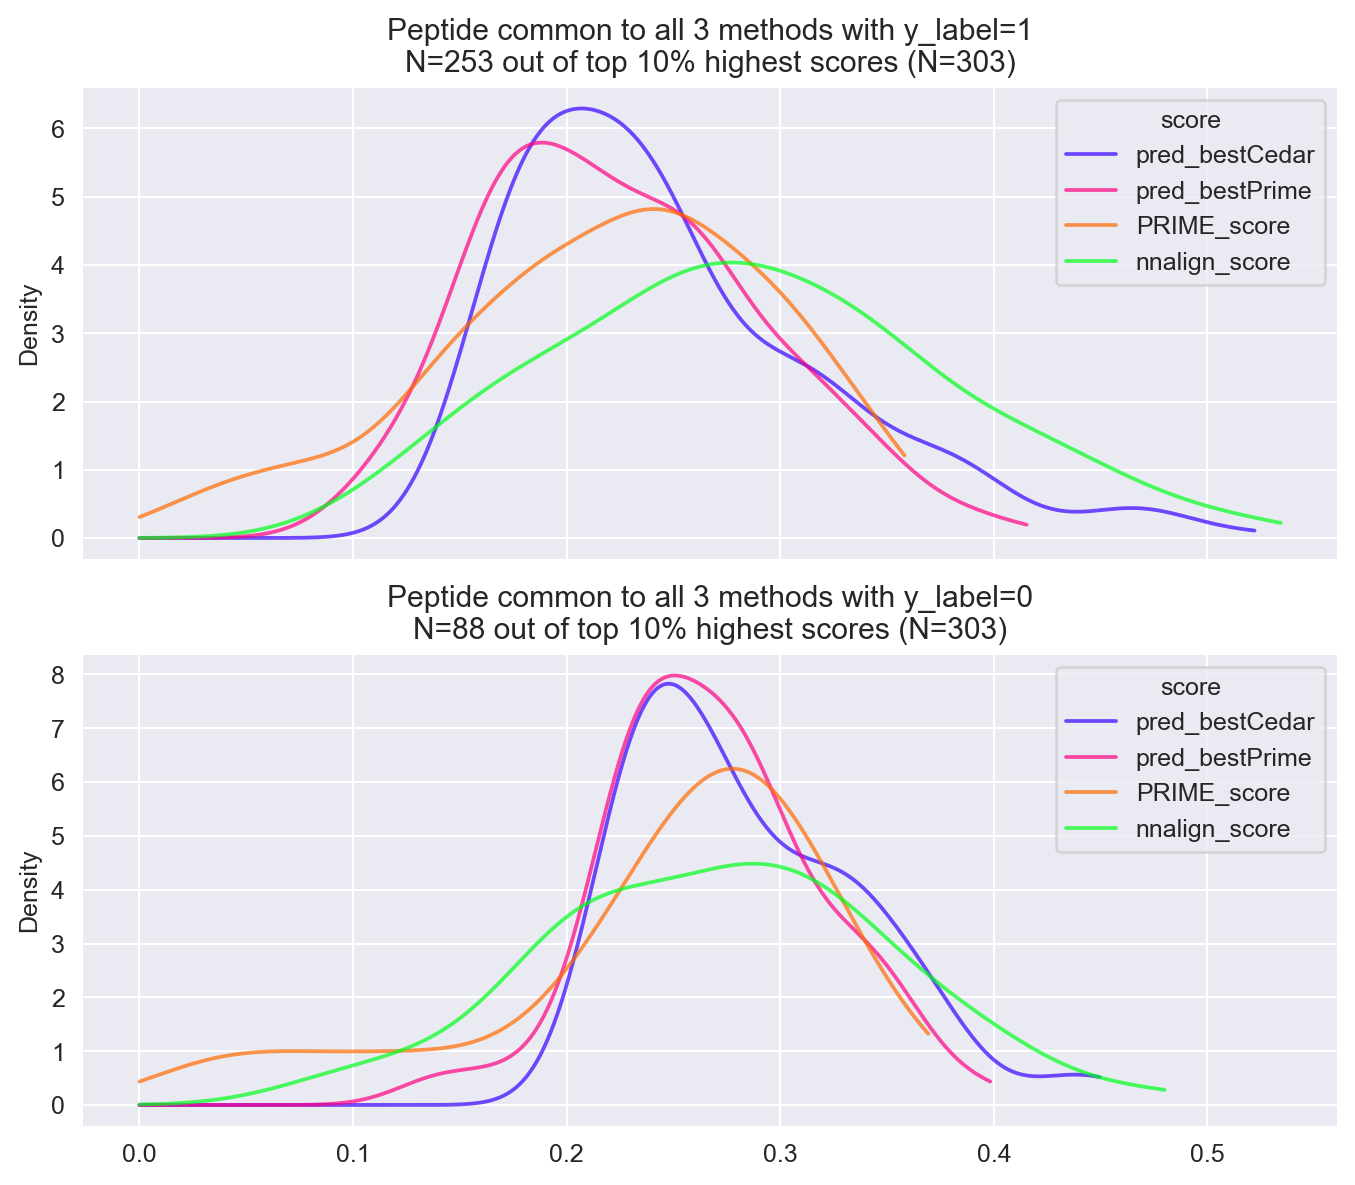

In [568]:
f,a = plt.subplots(2,1, figsize=(9,7.5), sharex=True)
for score in pred_cols:
    ind = np.linspace(0, tp_cedar_common[score].max(), 1000)
    tp_cedar_common[score].plot(ax=a[0], kind='kde', alpha=0.7, ind = ind, 
                                title=f'Peptide common to all 3 methods with y_label=1\nN={len(tp_cedar_common)} '\
                                      f'out of top 10% highest scores (N={len(tp_cedar_bc)})', 
                                label=score)
    # tp_cedar_common[score].plot(ax=a[0], kind='hist', alpha=0.45, bins=75, ) # ind = np.linspace(0, 0.5345, 1000), 
a[0].legend(title='score')
for score in pred_cols:
    ind = np.linspace(0, fp_cedar_common[score].max(), 1000)
    fp_cedar_common[score].plot(ax=a[1], kind='kde', alpha=0.7, ind = ind, 
                                title=f'Peptide common to all 3 methods with y_label=0\nN={len(fp_cedar_common)} '\
                                      f'out of top 10% highest scores (N={len(fp_cedar_bc)})', 
                                label=score)
    # fp_cedar_common[score].plot(ax=a[1], kind='hist', alpha=0.45, bins=75, ) # ind = np.linspace(0, 0.4495, 1000), 
a[1].legend(title='score')